# CIFAR 10

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

You can get the data via:

    wget http://pjreddie.com/media/files/cifar.tgz    
**Important:** Before proceeding, the student must reorganize the downloaded dataset files to match the expected directory structure, so that there is a dedicated folder for each class under 'test' and 'train', e.g.:

```
* test/airplane/airplane-1001.png
* test/bird/bird-1043.png

* train/bird/bird-10018.png
* train/automobile/automobile-10000.png
```

The filename of the image doesn't have to include its class.

In [25]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

- classes — image labels

In [26]:
def to_label_subdirs(path, subdirs, classes, labelfn):
    for sd in subdirs:
        for rf in os.listdir(os.path.join(path, sd)):
            af = os.path.join(path, sd, rf)
            if not os.path.isfile(af):
                continue
            lb = labelfn(rf)
            if not lb:
                continue
            os.renames(af, os.path.join(path, sd, lb, rf))

In [27]:
to_label_subdirs(PATH, 'train test'.split(), classes, lambda f: f[f.find('_')+1 : f.find('.')])

In [30]:
from fastai.conv_learner import *
PATH = "data/cifar/"
os.makedirs(PATH, exist_ok=True)

!ls {PATH}

if not os.path.exists(f"{PATH}/train/bird"):
   raise Exception("expecting class subdirs under 'train/' and 'test/'")
!ls {PATH}/train

labels.txt test       train
airplane   bird       deer       frog       ship
automobile cat        dog        horse      truck


In [31]:
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

In [32]:
def get_data(sz, bs):
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
    return ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

In [33]:
bs = 256

- **stats**  When we use pre-trained models, you can call tfms_from_model which creates the necessary transforms to convert our data set into a normalized dataset based on the means and standard deviations of each channel in the original model that was trained in. Since we are training a model from scratch, we ned to tell it the mean and standard deviation of our data to normalize it. Make sure you can calculate the mean and the standard deviation for each channel.

- **tfms**  For CIFAR 10 data augmentation, people typically do horizontal flip and black padding around the edge and randomly select 32 by 32 area within the padded image.

### Look at data

In [34]:
data = get_data(32, 4)

In [35]:
x, y = next(iter(data.trn_dl))

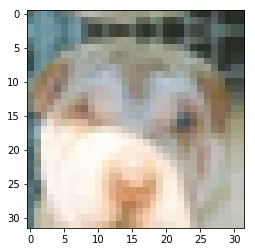

In [37]:
plt.imshow(data.trn_ds.denorm(x)[0]);

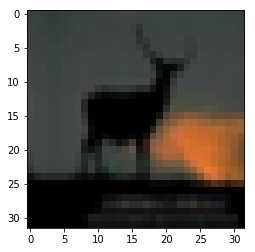

In [38]:
plt.imshow(data.trn_ds.denorm(x)[1]);

### Fully Connected Model

In [39]:
data = get_data(32, bs)

In [40]:
lr = 1e-2

### Simple NN

In [50]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)
        ])
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x, dim=-1)

In [51]:
learn = ConvLearner.from_model_data(SimpleNet([32*32*3, 40, 10]), data)

- Now we step up one level of API higher — rather than calling fit function, we create a learn object from a custom model. 

- ConvLearner.from_model_data takes standard PyTorch model and model data object.

In [52]:
learn, [o.numel() for o in learn.model.parameters()]

(SimpleNet(
   (layers): ModuleList(
     (0): Linear(in_features=3072, out_features=40, bias=True)
     (1): Linear(in_features=40, out_features=10, bias=True)
   )
 ), [122880, 40, 400, 10])

In [53]:
learn.summary()

OrderedDict([('Linear-1',
              OrderedDict([('input_shape', [-1, 3072]),
                           ('output_shape', [-1, 40]),
                           ('trainable', True),
                           ('nb_params', tensor(122920))])),
             ('Linear-2',
              OrderedDict([('input_shape', [-1, 40]),
                           ('output_shape', [-1, 10]),
                           ('trainable', True),
                           ('nb_params', tensor(410))]))])

In [54]:
learn.lr_find()

 75%|███████▌  | 147/196 [00:18<00:08,  5.68it/s, loss=3.03]

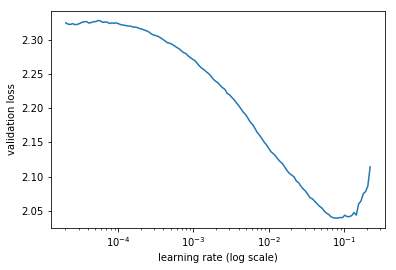

In [55]:
learn.sched.plot()

In [56]:
%time learn.fit(lr, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.763193   1.648006   0.4168    
    1      1.680627   1.591126   0.4361                     
CPU times: user 3min 15s, sys: 37.5 s, total: 3min 53s
Wall time: 54 s


[1.591126481628418, 0.4361]

In [58]:
%time learn.fit(lr, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.61723    1.515955   0.4667    
    1      1.58708    1.50213    0.4722                     
CPU times: user 3min 25s, sys: 37.4 s, total: 4min 3s
Wall time: 54.8 s


[1.5021299341201781, 0.4722]

With a simple one hidden layer model with 122,880 parameters, we achieved 46.9% accuracy. Let’s improve this and gradually build up to a basic ResNet architecture.

# CNN

- Let’s replace a fully connected model with a convolutional model. Fully connected layer is simply doing a dot product. That is why the weight matrix is big (3072 input * 40 = 122880). We are not using the parameters very efficiently because every single pixel in the input has a different weight. What we want to do is a group of 3 by 3 pixels that have particular patterns to them (i.e. convolution).

- We will use a filter with three by three kernel. When there are multiple filters, the output will have additional dimension.

In [59]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i + 1], kernel_size=3, stride=2)
            for i in range(len(layers) - 1)
        ])
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers:
            x = F.relu(l(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

- Replace nn.Linear with nn.Conv2d
- First two parameters are exactly the same as nn.Linear — the number of features coming in, and the number of features coming out
- kernel_size=3, the size of the filter
- stride=2 will use every other 3 by 3 area which will halve the output resolution in each dimension (i.e. it has the same effect as 2 by 2 max-pooling)

In [60]:
learn = ConvLearner.from_model_data(ConvNet([3, 20, 40, 80], 10), data)

In [61]:
learn, [o.numel() for o in learn.model.parameters()]

(ConvNet(
   (layers): ModuleList(
     (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(2, 2))
     (1): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2))
     (2): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2))
   )
   (pool): AdaptiveMaxPool2d(output_size=1)
   (out): Linear(in_features=80, out_features=10, bias=True)
 ), [540, 20, 7200, 40, 28800, 80, 800, 10])

In [62]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 15, 15]),
                           ('trainable', True),
                           ('nb_params', tensor(560))])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 20, 15, 15]),
                           ('output_shape', [-1, 40, 7, 7]),
                           ('trainable', True),
                           ('nb_params', tensor(7240))])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 40, 7, 7]),
                           ('output_shape', [-1, 80, 3, 3]),
                           ('trainable', True),
                           ('nb_params', tensor(28880))])),
             ('AdaptiveMaxPool2d-4',
              OrderedDict([('input_shape', [-1, 80, 3, 3]),
                           ('output_shape', [-1, 80, 1, 1]),
                           ('nb_params', 0)])),
             ('Linear-5',
 

- `ConvNet([3, 20, 40, 80], 10)` — It start with 3 RGB channels, 20, 40, 80 features, then 10 classes to predict.
- `AdaptiveMaxPool2d` — This followed by a linear layer is how you get from 3 by 3 down to a prediction of one of 10 classes and is now a standard for state-of-the-art algorithms. The very last layer, we do a special kind of max-pooling for which you specify the output activation resolution rather than how big of an area to poll. In other words, here we do 3 by 3 max-pool which is equivalent of 1 by 1 adaptive max-pool.
- `x = x.view(x.size(0), -1)` -- `x` has a shape of # of the features by 1 by 1, so it will remove the last two layers.
- This model is called “fully convolutional network” — where every layer is convolutional except for the very last.

 71%|███████▏  | 140/196 [00:20<00:08,  6.89it/s, loss=7.31]

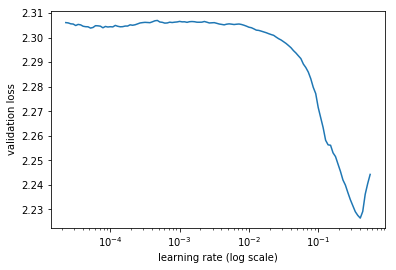

In [63]:
learn.lr_find(end_lr=100)
learn.sched.plot()

- The default final learning rate lr_find tries is 10. If the loss is still getting better at that point, you can overwrite by specifying end_lr .

In [64]:
%time learn.fit(1e-1, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.724445   1.692468   0.3944    
    1      1.506299   1.429631   0.4891                     
CPU times: user 6min 3s, sys: 42.2 s, total: 6min 45s
Wall time: 1min 9s


[1.4296310916900634, 0.4891]

In [65]:
%time learn.fit(1e-1, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.473162   1.3859     0.4933    
    1      1.35009    1.281189   0.5372                     
    2      1.286003   1.227919   0.5556                     
    3      1.251286   1.184306   0.5766                     
CPU times: user 12min 10s, sys: 1min 16s, total: 13min 27s
Wall time: 2min 13s


[1.184305938720703, 0.5766]

- It flattened out around 60% accuracy. Considering it uses about 30,000 parameters (compared to 47% with 122k parameters)
- Time per epoch is about the same since their architectures are both simple and most of time is spent doing memory transfer.

## Refactored

Simplify forward function by creating ConvLayer (our first custom layer!). In PyTorch, layer definition and neural network definitions are identical. Anytime you have a layer, you can use it as a neural net, when you have a neural net, you can use it as a layer.

In [66]:
class ConvLayer(nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
    
    def forward(self, x):
        return F.relu(self.conv(x))

- `padding=1` -- When you do convolution the image shrink by 1 pixel on each side. So it does not go from 32 by 32 to 16 by 16 but actually 15 by 15. `padding` will add a border so we can keep the edge pixel information. It is not as big of a deal for a big image, but when it’s down to 4 by 4, you really don’t want to throw away a whole piece.

In [68]:
class ConvNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            ConvLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)
        ])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers:
            x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

- Another difference from the last model is that `nn.AdaptiveMaxPool2d` does not have any state (i.e. no weights). So we can just call it as a function `F.adaptive_max_pool2d`.

In [69]:
learn = ConvLearner.from_model_data(ConvNet2([3, 20, 40, 80], 10), data)

In [70]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', tensor(560))])),
             ('ConvLayer-2',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', tensor(7240))])),
             ('ConvLayer-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 40, 8, 8]),
 

In [71]:
%time learn.fit(1e-1, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.70116    1.595327   0.4174    
    1      1.523405   1.418659   0.4841                     
CPU times: user 6min 27s, sys: 46.3 s, total: 7min 13s
Wall time: 1min 10s


[1.418658731842041, 0.4841]

In [72]:
%time learn.fit(1e-1, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.451674   1.342269   0.5168    
    1      1.309393   1.23193    0.5546                     
CPU times: user 6min 41s, sys: 50.1 s, total: 7min 31s
Wall time: 1min 15s


[1.23192967376709, 0.5546]

# BatchNorm 

- The last model, when we tried to add more layers, we had trouble training. The reason we had trouble training was that if we used larger learning rates, it would go off to NaN and if we used smaller learning rate, it would take forever and doesn’t have a chance to explore properly — so it was not resilient.

- To make it resilient, we will use something called batch normalization. BatchNorm came out about two years ago and it has been quite transformative since it suddenly makes it really easy to train deeper networks.

- We can simply use nn.BatchNorm but to learn about it, we will write it from scratch.

- It is unlikely that the weight matrices on average are not going to cause your activations to keep getting smaller and smaller or keep getting bigger and bigger. It is important to keep them at reasonable scale. So we start things off with zero-mean standard deviation one by normalizing the input. What we really want to do is to do this for all layers, not just the inputs.


In [82]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf, 1, 1))
        self.m = nn.Parameter(torch.zeros(nf, 1, 1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0, 1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:, None, None]
            self.stds  = x_chan.std(1)[:, None, None]
        return (x - self.means) / self.stds * self.m + self.a

- Calculate the mean of each channel or each filter and standard deviation of each channel or each filter. Then subtract the means and divide by the standard deviations.

- We no longer need to normalize our input because it is normalizing it per channel or for later layers it is normalizing per filter.

- If SGD decided that it wants matrix to be bigger/smaller overall, doing `(x=self.means) / self.stds` is not enough because SGD will undo it and try to do it again in the next mini-batch. So we will add two parameters: `a` — adder (initial value zeros) and `m` — multiplier (initial value ones) for each channel.

- `Parameter` tells PyTorch that it is `allowed` to learn these as weights.

- Why does this work? If it wants to scale the layer up, it does not have to scale up every single value in the matrix. It can just scale up this single trio of numbers `self.m` , if it wants to shift it all up or down a bit, it does not have to shift the entire weight matrix, they can just shift this trio of numbers `self.a`. Intuition: We are normalizing the data and then we are saying you can then shift it and scale it using far fewer parameters than would have been necessary if it were to actually shift and scale the entire set of convolutional filters. In practice, it allows us to increase our learning rates, it increase the resilience of training, and it allows us to add more layers and still train effectively.

- The other thing batch norm does is that it regularizes, in other words, you can often decrease or remove dropout or weight decay. The reason why is each mini-batch is going to have a different mean and a different standard deviation to the previous mini-batch. So they keep changing and it is changing the meaning of the filters in a subtle way acting as a noise (i.e. regularization).

- In real version, it does not use this batch’s mean and standard deviation but takes an exponentially weighted moving average standard deviation and mean.

- `if self.training` — this is important because when you are going through the validation set, you do not want to be changing the meaning of the model. There are some types of layer that are actually sensitive to what the mode of the network is whether it is in training mode or evaluation/test mode. There was a bug when we implemented mini net for MovieLens that dropout was applied during the validation — which was fixed. In PyTorch, there are two such layer: dropout and batch norm. nn.Dropout already does the check.

- The key difference in fast.ai which no other library does is that these means and standard deviations get updated in training mode in every other library as soon as you basically say I am training, regardless of whether that layer is set to trainable or not. With a pre-trained network, that is a terrible idea. If you have a pre-trained network for specific values of those means and standard deviations in batch norm, if you change them, it changes the meaning of those pre-trained layers. In fast.ai, always by default, it will not touch those means and standard deviations if your layer is frozen. As soon as you un-freeze it, it will start updating them unless you set learn.bn_freeze=True. In practice, this often seems to work a lot better for pre-trained models particularly if you are working with data that is quite similar to what the pre-trained model was trained with.

#### BN

- Try and always use batch norm on every layer if you can
- Don’t stop normalizing your data so that people using your data will know how you normalized your data. Other libraries might not deal with batch norm for pre-trained models correctly, so when people start re-training, it might cause problems.

In [83]:
class ConvBnNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([
            BnLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)
        ])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l in self.layers:
            x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

- A single convolutional layer was added at the start trying to get closer to the modern approaches. It has a bigger kernel size and a stride of 1. The basic idea is that we want the first layer to have a richer input. It does convolution using the 5 by 5 area which allows it to try and find more interesting richer features in that 5 by 5 area, then spit out bigger output (in this case, it’s 10 by 5 by 5 filters). Typically it is 5 by 5 or 7 by 7, or even 11 by 11 convolution with quite a few filters coming out (e.g. 32 filters).

- Since `padding = kernel_size — 1 / 2 and stride=1` , the input size is the same as the output size — just more filters.

- It is a good way of trying to create a richer starting point.

In [84]:
learn = ConvLearner.from_model_data(ConvBnNet([10, 20, 40, 80, 160], 10), data)

In [85]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 10, 32, 32]),
                           ('trainable', True),
                           ('nb_params', tensor(760))])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', tensor(1800))])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', tensor(7200))])),
             ('BnLayer-5',
   

In [86]:
%time learn.fit(3e-2, 2)

epoch      trn_loss   val_loss   accuracy                  
    0      nan        nan        0.1       
    1      nan        nan        0.1                       
CPU times: user 13min 8s, sys: 1min 14s, total: 14min 22s
Wall time: 2min 57s


[nan, 0.1]

In [ ]:
%time learn.fit(1e-1, 4, cycle_len=1)

## Deep BatchNorm

Let’s increase the depth of the model. We cannot just add more of stride 2 layers since it halves the size of the image each time. Instead, after each stride 2 layer, we insert a stride 1 layer.



In [90]:
class ConvBnNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([
            BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)
        ])
        self.layers2 = nn.ModuleList([
            BnLayer(layers[i + 1], layers[i+1])
            for i in range(len(layers) - 1)
        ])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l, l2 in zip(self.layers, self.layers2):
            x = l(x)
            x = l2(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [93]:
learn = ConvLearner.from_model_data(ConvBnNet2([10, 20, 40, 80, 160], 10), data)

In [94]:
%time learn.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy                  
    0      nan        nan        0.1       
    1      nan        nan        0.1                       
CPU times: user 12min 55s, sys: 1min 10s, total: 14min 5s
Wall time: 3min 10s


[nan, 0.1]

In [ ]:
%time learn.fit(1e-2, 2, cycle_len=1)

The accuracy remained the same as before. This is now 12 layers deep, and it is too deep even for batch norm to handle. It is possible to train 12 layer deep conv net but it starts to get difficult. And it does not seem to be helping much if at all.

## ResNet

In [95]:
class ResnetLayer(BnLayer):
    def forward(self, x):
        return x + super().forward(x)

In [96]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([
            BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)
        ])
        self.layers2 = nn.ModuleList([
            ResnetLayer(layers[i+1], layers[i+1], 1)
            for i in range(len(layers) - 1)
        ])
        self.layers3 = nn.ModuleList([
            ResnetLayer(layers[i+1], layers[i+1], 1)
            for i in range(len(layers) - 1)
        ])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l, l2, l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

- ResnetLayer inherit from BnLayer and override forward.
- Then add bunch of layers and make it 3 times deeper, ad it still trains beautifully just because of x + super().forward(x).

In [97]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 10), data)

In [98]:
wd=1e-5

In [99]:
%time learn.fit(1e-2, 2, wds=wd)

epoch      trn_loss   val_loss   accuracy                  
    0      nan        nan        0.1       
    1      nan        nan        0.1                       
CPU times: user 18min 29s, sys: 2min 1s, total: 20min 30s
Wall time: 7min 21s


[nan, 0.1]

In [ ]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

In [ ]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

#### ResNet block 

`return x + super().forward(x)`

y = x + f(x)

Where x is prediction from the previous layer, y is prediction from the current layer. Shuffle around the formula and we get: formula shuffle

f(x) = y - x

The difference y − x is residual. The residual is the error in terms of what we have calculated so far. What this is saying is that try to find a set of convolutional weights that attempts to fill in the amount we were off by. So in other words, we have an input, and we have a function which tries to predict the error (i.e. how much we are off by). Then we add a prediction of how much we were wrong by to the input, then add another prediction of how much we were wrong by that time, and repeat that layer after layer — zooming into the correct answer. This is based on a theory called **boosting**.

- The full ResNet does two convolutions before it gets added back to the original input (we did just one here).

- In every block `x = l3(l2(l(x)))` , one of the layers is not a `ResnetLayer` but a standard convolution with stride=2 — this is called a “bottleneck layer”. ResNet does not convolutional layer but a different form of bottleneck block which we will cover in Part 2.

## ResNet 2
Here, we increased the size of features and added dropout.

In [100]:
class Resnet2(nn.Module):
    def __init__(self, layers, c, p=0.5):
        super().__init__()
        self.conv1 = BnLayer(3, 16, stride=1, kernel_size=7)
        self.layers = nn.ModuleList([
            BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)
        ])
        self.layers2 = nn.ModuleList([
            BnLayer(layers[i+1], layers[i+1], 1)
            for i in range(len(layers) - 1)
        ])
        self.layers3 = nn.ModuleList([
            BnLayer(layers[i+1], layers[i+1], 1)
            for i in range(len(layers) - 1)
        ])
        self.out = nn.Linear(layers[-1], c)
        self.drop = nn.Dropout(p)
    
    def forward(self, x):
        x = self.conv1(x)
        for l, l2, l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        return F.log_softmax(self.out(x), dim=-1)

In [101]:
learn = ConvLearner.from_model_data(Resnet2([16, 32, 64, 128, 256], 10, 0.2), data)

In [102]:
wd = 1e-6

In [ ]:
%time learn.fit(1e-2, 2, wds=wd)

In [ ]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

In [ ]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

In [ ]:
learn.save('tmp3')

In [ ]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)

In [ ]:
metrics.log_loss(y,preds), accuracy_np(preds,y)

In [ ]:
# Required to get the data file

In [22]:
%ls data/cifar/train

0_frog.png            25000_frog.png        40000_automobile.png
10000_automobile.png  25001_truck.png       40001_ship.png
10001_frog.png        25002_ship.png        40002_dog.png
10002_frog.png        25003_deer.png        40003_automobile.png
10003_ship.png        25004_airplane.png    40004_dog.png
10004_ship.png        25005_frog.png        40005_horse.png
10005_cat.png         25006_cat.png         40006_deer.png
10006_deer.png        25007_automobile.png  40007_cat.png
10007_frog.png        25008_cat.png         40008_ship.png
10008_airplane.png    25009_truck.png       40009_bird.png
10009_frog.png        2500_dog.png          4000_dog.png
1000_truck.png        25010_truck.png       40010_horse.png
10010_airplane.png    25011_ship.png        40011_bird.png
10011_cat.png         25012_dog.png         40012_airplane.png
10012_frog.png        25013_ship.png        40013_automobile.png
10013_frog.png        25014_deer.png        40014_dog.png
10014_dog.png         25015_dog.png   

1024_bird.png         25250_deer.png        40250_automobile.png
10250_deer.png        25251_airplane.png    40251_horse.png
10251_automobile.png  25252_dog.png         40252_ship.png
10252_truck.png       25253_cat.png         40253_horse.png
10253_frog.png        25254_cat.png         40254_truck.png
10254_cat.png         25255_frog.png        40255_ship.png
10255_cat.png         25256_cat.png         40256_bird.png
10256_frog.png        25257_cat.png         40257_truck.png
10257_truck.png       25258_ship.png        40258_automobile.png
10258_dog.png         25259_cat.png         40259_deer.png
10259_horse.png       2525_cat.png          4025_cat.png
1025_cat.png          25260_dog.png         40260_ship.png
10260_frog.png        25261_airplane.png    40261_frog.png
10261_truck.png       25262_dog.png         40262_horse.png
10262_deer.png        25263_bird.png        40263_cat.png
10263_bird.png        25264_automobile.png  40264_frog.png
10264_deer.png        25265_dog.png       

14229_bird.png        2922_deer.png         4422_cat.png
1422_truck.png        29230_automobile.png  44230_bird.png
14230_cat.png         29231_automobile.png  44231_automobile.png
14231_frog.png        29232_airplane.png    44232_cat.png
14232_cat.png         29233_frog.png        44233_cat.png
14233_horse.png       29234_truck.png       44234_cat.png
14234_cat.png         29235_cat.png         44235_automobile.png
14235_deer.png        29236_horse.png       44236_ship.png
14236_frog.png        29237_deer.png        44237_dog.png
14237_cat.png         29238_truck.png       44238_bird.png
14238_automobile.png  29239_ship.png        44239_frog.png
14239_cat.png         2923_ship.png         4423_automobile.png
1423_dog.png          29240_deer.png        44240_truck.png
14240_automobile.png  29241_frog.png        44241_bird.png
14241_frog.png        29242_dog.png         44242_truck.png
14242_horse.png       29243_bird.png        44243_airplane.png
14243_deer.png        29244_airplane.pn

17492_automobile.png  32492_automobile.png  47493_dog.png
17493_dog.png         32493_frog.png        47494_cat.png
17494_horse.png       32494_deer.png        47495_automobile.png
17495_dog.png         32495_truck.png       47496_dog.png
17496_cat.png         32496_deer.png        47497_frog.png
17497_cat.png         32497_frog.png        47498_bird.png
17498_deer.png        32498_horse.png       47499_frog.png
17499_horse.png       32499_bird.png        4749_truck.png
1749_ship.png         3249_dog.png          474_bird.png
174_cat.png           324_dog.png           47500_bird.png
17500_deer.png        32500_frog.png        47501_truck.png
17501_dog.png         32501_ship.png        47502_cat.png
17502_horse.png       32502_automobile.png  47503_deer.png
17503_horse.png       32503_horse.png       47504_truck.png
17504_bird.png        32504_cat.png         47505_dog.png
17505_cat.png         32505_airplane.png    47506_ship.png
17506_bird.png        32506_ship.png        47507_dog.p

21343_horse.png       36344_bird.png        6344_deer.png
21344_horse.png       36345_deer.png        6345_dog.png
21345_airplane.png    36346_horse.png       6346_ship.png
21346_deer.png        36347_dog.png         6347_automobile.png
21347_cat.png         36348_frog.png        6348_cat.png
21348_bird.png        36349_bird.png        6349_automobile.png
21349_frog.png        3634_ship.png         634_truck.png
2134_frog.png         36350_dog.png         6350_frog.png
21350_truck.png       36351_cat.png         6351_cat.png
21351_cat.png         36352_horse.png       6352_dog.png
21352_dog.png         36353_airplane.png    6353_automobile.png
21353_horse.png       36354_dog.png         6354_airplane.png
21354_deer.png        36355_bird.png        6355_dog.png
21355_truck.png       36356_airplane.png    6356_automobile.png
21356_dog.png         36357_airplane.png    6357_truck.png
21357_frog.png        36358_airplane.png    6358_dog.png
21358_frog.png        36359_automobile.png  6359_

In [14]:
!mv cifar.tgz data/

In [11]:
!curl -O -L http://pjreddie.com/media/files/cifar.tgz -o cifar.tgz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   184  100   184    0     0    322      0 --:--:-- --:--:-- --:--:--   321
100  160M  100  160M    0     0  1226k      0  0:02:14  0:02:14 --:--:-- 1345k    0   186k      0  0:14:40  0:00:06  0:14:34  237k   0  1282k      0  0:02:08  0:00:42  0:01:26 1670k   0  1322k      0  0:02:04  0:00:47  0:01:17 1652k   0  1437k      0  0:01:54  0:01:11  0:00:43 1127k   0  1201k      0  0:02:16  0:02:00  0:00:16 1460k


In [17]:
!tar -xvzf data/cifar.tgz -C data/

x cifar/
x cifar/test/
x cifar/test/3661_automobile.png
x cifar/test/4572_bird.png
x cifar/test/416_airplane.png
x cifar/test/4863_automobile.png
x cifar/test/9523_dog.png
x cifar/test/3612_automobile.png
x cifar/test/9090_bird.png
x cifar/test/3443_deer.png
x cifar/test/8274_frog.png
x cifar/test/6245_frog.png
x cifar/test/2356_ship.png
x cifar/test/3249_cat.png
x cifar/test/5034_ship.png
x cifar/test/4010_horse.png
x cifar/test/955_horse.png
x cifar/test/8074_horse.png
x cifar/test/4971_truck.png
x cifar/test/1297_bird.png
x cifar/test/9235_airplane.png
x cifar/test/6504_horse.png
x cifar/test/780_truck.png
x cifar/test/6980_airplane.png
x cifar/test/9664_airplane.png
x cifar/test/3495_bird.png
x cifar/test/31_dog.png
x cifar/test/8033_cat.png
x cifar/test/9838_dog.png
x cifar/test/7081_deer.png
x cifar/test/2862_frog.png
x cifar/test/2088_horse.png
x cifar/test/6576_horse.png
x cifar/test/6518_frog.png
x cifar/test/9969_frog.png
x cifar/test/9030_bird.png
x cifar/test/6795_truck.png

x cifar/test/769_deer.png
x cifar/test/2481_horse.png
x cifar/test/6869_dog.png
x cifar/test/3929_cat.png
x cifar/test/2147_horse.png
x cifar/test/1601_truck.png
x cifar/test/8934_horse.png
x cifar/test/7888_horse.png
x cifar/test/4690_bird.png
x cifar/test/7822_bird.png
x cifar/test/9782_bird.png
x cifar/test/2480_ship.png
x cifar/test/7650_bird.png
x cifar/test/8927_truck.png
x cifar/test/5233_automobile.png
x cifar/test/5207_ship.png
x cifar/test/1913_truck.png
x cifar/test/4568_ship.png
x cifar/test/7160_dog.png
x cifar/test/3527_automobile.png
x cifar/test/1654_truck.png
x cifar/test/4743_frog.png
x cifar/test/7622_truck.png
x cifar/test/4113_airplane.png
x cifar/test/8483_airplane.png
x cifar/test/72_ship.png
x cifar/test/942_horse.png
x cifar/test/685_frog.png
x cifar/test/7925_airplane.png
x cifar/test/7242_horse.png
x cifar/test/3580_deer.png
x cifar/test/6651_frog.png
x cifar/test/5871_frog.png
x cifar/test/6513_dog.png
x cifar/test/4628_dog.png
x cifar/test/7051_cat.png
x ci

x cifar/test/9017_airplane.png
x cifar/test/6381_truck.png
x cifar/test/1343_airplane.png
x cifar/test/6337_truck.png
x cifar/test/4837_horse.png
x cifar/test/2573_dog.png
x cifar/test/4106_cat.png
x cifar/test/650_cat.png
x cifar/test/4626_dog.png
x cifar/test/3000_dog.png
x cifar/test/7901_automobile.png
x cifar/test/7999_frog.png
x cifar/test/5732_cat.png
x cifar/test/3600_deer.png
x cifar/test/982_airplane.png
x cifar/test/2116_truck.png
x cifar/test/1535_deer.png
x cifar/test/9504_frog.png
x cifar/test/4313_airplane.png
x cifar/test/1490_ship.png
x cifar/test/8850_automobile.png
x cifar/test/8575_truck.png
x cifar/test/240_automobile.png
x cifar/test/7742_airplane.png
x cifar/test/8054_truck.png
x cifar/test/3945_dog.png
x cifar/test/2645_automobile.png
x cifar/test/3182_ship.png
x cifar/test/4048_dog.png
x cifar/test/8006_truck.png
x cifar/test/577_truck.png
x cifar/test/7497_cat.png
x cifar/test/3720_bird.png
x cifar/test/2060_dog.png
x cifar/test/4830_cat.png
x cifar/test/2959_

x cifar/test/4404_cat.png
x cifar/test/331_truck.png
x cifar/test/8645_automobile.png
x cifar/test/1109_airplane.png
x cifar/test/7744_deer.png
x cifar/test/8601_cat.png
x cifar/test/1873_frog.png
x cifar/test/1220_truck.png
x cifar/test/27_airplane.png
x cifar/test/1494_horse.png
x cifar/test/8998_truck.png
x cifar/test/2029_cat.png
x cifar/test/2319_horse.png
x cifar/test/9963_ship.png
x cifar/test/5490_cat.png
x cifar/test/7913_ship.png
x cifar/test/411_truck.png
x cifar/test/1350_deer.png
x cifar/test/9400_frog.png
x cifar/test/5464_horse.png
x cifar/test/1852_bird.png
x cifar/test/6810_ship.png
x cifar/test/7667_frog.png
x cifar/test/9211_automobile.png
x cifar/test/9118_deer.png
x cifar/test/6536_automobile.png
x cifar/test/7632_airplane.png
x cifar/test/8436_dog.png
x cifar/test/8285_truck.png
x cifar/test/620_horse.png
x cifar/test/8052_horse.png
x cifar/test/7070_horse.png
x cifar/test/9708_truck.png
x cifar/test/4102_airplane.png
x cifar/test/3273_ship.png
x cifar/test/4052_d

x cifar/test/5985_deer.png
x cifar/test/8502_automobile.png
x cifar/test/1734_truck.png
x cifar/test/288_horse.png
x cifar/test/753_automobile.png
x cifar/test/6353_bird.png
x cifar/test/8899_deer.png
x cifar/test/8823_deer.png
x cifar/test/1219_cat.png
x cifar/test/5400_truck.png
x cifar/test/6936_truck.png
x cifar/test/9722_cat.png
x cifar/test/9451_ship.png
x cifar/test/1375_deer.png
x cifar/test/3817_ship.png
x cifar/test/8036_frog.png
x cifar/test/4278_automobile.png
x cifar/test/1174_automobile.png
x cifar/test/7941_dog.png
x cifar/test/2200_airplane.png
x cifar/test/3119_deer.png
x cifar/test/2276_airplane.png
x cifar/test/3512_deer.png
x cifar/test/5281_cat.png
x cifar/test/7985_dog.png
x cifar/test/9157_cat.png
x cifar/test/7797_cat.png
x cifar/test/1901_dog.png
x cifar/test/5481_horse.png
x cifar/test/3156_truck.png
x cifar/test/8992_dog.png
x cifar/test/1277_bird.png
x cifar/test/1614_automobile.png
x cifar/test/2613_frog.png
x cifar/test/9862_cat.png
x cifar/test/7395_bird.

x cifar/test/111_airplane.png
x cifar/test/4794_deer.png
x cifar/test/3791_bird.png
x cifar/test/2087_airplane.png
x cifar/test/4566_ship.png
x cifar/test/2953_ship.png
x cifar/test/9807_automobile.png
x cifar/test/1128_deer.png
x cifar/test/7268_cat.png
x cifar/test/6249_dog.png
x cifar/test/4848_automobile.png
x cifar/test/8293_airplane.png
x cifar/test/903_dog.png
x cifar/test/8564_automobile.png
x cifar/test/1486_horse.png
x cifar/test/3184_airplane.png
x cifar/test/1962_frog.png
x cifar/test/7245_deer.png
x cifar/test/4038_airplane.png
x cifar/test/1263_ship.png
x cifar/test/1519_frog.png
x cifar/test/75_bird.png
x cifar/test/7438_dog.png
x cifar/test/9883_horse.png
x cifar/test/5477_bird.png
x cifar/test/7147_dog.png
x cifar/test/7396_ship.png
x cifar/test/7190_bird.png
x cifar/test/9389_ship.png
x cifar/test/7537_deer.png
x cifar/test/5825_cat.png
x cifar/test/1571_dog.png
x cifar/test/5095_ship.png
x cifar/test/6122_dog.png
x cifar/test/4485_cat.png
x cifar/test/7306_deer.png
x

x cifar/test/9803_automobile.png
x cifar/test/7874_frog.png
x cifar/test/7678_ship.png
x cifar/test/5424_cat.png
x cifar/test/4876_cat.png
x cifar/test/5612_ship.png
x cifar/test/305_automobile.png
x cifar/test/3002_horse.png
x cifar/test/7591_frog.png
x cifar/test/4470_airplane.png
x cifar/test/9196_airplane.png
x cifar/test/1010_airplane.png
x cifar/test/9425_frog.png
x cifar/test/7700_frog.png
x cifar/test/5523_frog.png
x cifar/test/7527_frog.png
x cifar/test/342_bird.png
x cifar/test/4131_automobile.png
x cifar/test/8040_bird.png
x cifar/test/9658_truck.png
x cifar/test/8057_truck.png
x cifar/test/9138_dog.png
x cifar/test/967_truck.png
x cifar/test/8530_ship.png
x cifar/test/2692_ship.png
x cifar/test/224_cat.png
x cifar/test/1722_frog.png
x cifar/test/510_dog.png
x cifar/test/9701_deer.png
x cifar/test/7482_deer.png
x cifar/test/228_horse.png
x cifar/test/8353_horse.png
x cifar/test/5590_deer.png
x cifar/test/1076_airplane.png
x cifar/test/8602_ship.png
x cifar/test/3055_truck.pn

x cifar/test/8310_cat.png
x cifar/test/4096_ship.png
x cifar/test/6963_truck.png
x cifar/test/6480_airplane.png
x cifar/test/1885_dog.png
x cifar/test/6732_cat.png
x cifar/test/4051_dog.png
x cifar/test/9599_horse.png
x cifar/test/7058_truck.png
x cifar/test/7200_deer.png
x cifar/test/8816_horse.png
x cifar/test/1196_bird.png
x cifar/test/8321_deer.png
x cifar/test/2155_truck.png
x cifar/test/9396_dog.png
x cifar/test/6323_bird.png
x cifar/test/726_automobile.png
x cifar/test/6777_bird.png
x cifar/test/3244_horse.png
x cifar/test/6101_truck.png
x cifar/test/2732_horse.png
x cifar/test/1661_frog.png
x cifar/test/5315_truck.png
x cifar/test/4331_bird.png
x cifar/test/8156_airplane.png
x cifar/test/1446_airplane.png
x cifar/test/7371_frog.png
x cifar/test/7610_horse.png
x cifar/test/6439_cat.png
x cifar/test/3256_deer.png
x cifar/test/3217_horse.png
x cifar/test/9330_deer.png
x cifar/test/4254_ship.png
x cifar/test/7367_cat.png
x cifar/test/6022_airplane.png
x cifar/test/3871_ship.png
x c

x cifar/test/517_truck.png
x cifar/test/9684_horse.png
x cifar/test/2889_horse.png
x cifar/test/8332_truck.png
x cifar/test/1451_bird.png
x cifar/test/4764_dog.png
x cifar/test/1014_cat.png
x cifar/test/7902_bird.png
x cifar/test/6405_automobile.png
x cifar/test/3892_dog.png
x cifar/test/5746_horse.png
x cifar/test/4856_horse.png
x cifar/test/752_truck.png
x cifar/test/2636_automobile.png
x cifar/test/2935_ship.png
x cifar/test/9063_horse.png
x cifar/test/1507_bird.png
x cifar/test/8194_automobile.png
x cifar/test/6459_frog.png
x cifar/test/9524_deer.png
x cifar/test/5111_frog.png
x cifar/test/4984_horse.png
x cifar/test/6053_deer.png
x cifar/test/1845_horse.png
x cifar/test/2333_frog.png
x cifar/test/7310_cat.png
x cifar/test/1858_deer.png
x cifar/test/7864_automobile.png
x cifar/test/8855_deer.png
x cifar/test/831_cat.png
x cifar/test/6873_cat.png
x cifar/test/4435_cat.png
x cifar/test/8881_frog.png
x cifar/test/7460_dog.png
x cifar/test/2387_truck.png
x cifar/test/8587_horse.png
x c

x cifar/test/2813_automobile.png
x cifar/test/8863_dog.png
x cifar/test/7668_dog.png
x cifar/test/9497_cat.png
x cifar/test/2808_bird.png
x cifar/test/483_dog.png
x cifar/test/5533_bird.png
x cifar/test/5679_airplane.png
x cifar/test/412_cat.png
x cifar/test/8211_dog.png
x cifar/test/2385_deer.png
x cifar/test/4354_horse.png
x cifar/test/1215_horse.png
x cifar/test/3758_bird.png
x cifar/test/6515_bird.png
x cifar/test/1052_airplane.png
x cifar/test/5785_bird.png
x cifar/test/7868_ship.png
x cifar/test/6857_bird.png
x cifar/test/760_cat.png
x cifar/test/736_automobile.png
x cifar/test/5150_deer.png
x cifar/test/1182_automobile.png
x cifar/test/6403_deer.png
x cifar/test/2868_truck.png
x cifar/test/3782_airplane.png
x cifar/test/8871_truck.png
x cifar/test/5299_horse.png
x cifar/test/588_ship.png
x cifar/test/9403_truck.png
x cifar/test/1944_deer.png
x cifar/test/7875_bird.png
x cifar/test/2334_automobile.png
x cifar/test/730_deer.png
x cifar/test/8885_cat.png
x cifar/test/3170_truck.png

x cifar/test/9756_dog.png
x cifar/test/4933_cat.png
x cifar/test/7151_automobile.png
x cifar/test/8981_horse.png
x cifar/test/1092_frog.png
x cifar/test/4867_truck.png
x cifar/test/9861_frog.png
x cifar/test/8845_bird.png
x cifar/test/9238_truck.png
x cifar/test/3090_deer.png
x cifar/test/7535_automobile.png
x cifar/test/6391_truck.png
x cifar/test/8610_bird.png
x cifar/test/1283_dog.png
x cifar/test/6717_airplane.png
x cifar/test/854_airplane.png
x cifar/test/4700_frog.png
x cifar/test/6298_cat.png
x cifar/test/2932_truck.png
x cifar/test/5817_cat.png
x cifar/test/4614_cat.png
x cifar/test/5809_airplane.png
x cifar/test/8646_bird.png
x cifar/test/6690_dog.png
x cifar/test/9698_horse.png
x cifar/test/3915_deer.png
x cifar/test/4584_deer.png
x cifar/test/7184_dog.png
x cifar/test/6468_ship.png
x cifar/test/4953_airplane.png
x cifar/test/270_bird.png
x cifar/test/9505_cat.png
x cifar/test/3515_ship.png
x cifar/test/1861_cat.png
x cifar/test/9435_bird.png
x cifar/test/2127_bird.png
x cifa

x cifar/test/5020_ship.png
x cifar/test/6466_ship.png
x cifar/test/8516_ship.png
x cifar/test/4884_deer.png
x cifar/test/9898_truck.png
x cifar/test/4950_bird.png
x cifar/test/3750_truck.png
x cifar/test/4159_deer.png
x cifar/test/9108_bird.png
x cifar/test/4097_cat.png
x cifar/test/18_ship.png
x cifar/test/4679_deer.png
x cifar/test/7896_deer.png
x cifar/test/5170_truck.png
x cifar/test/9402_frog.png
x cifar/test/141_dog.png
x cifar/test/1726_airplane.png
x cifar/test/5853_dog.png
x cifar/test/2885_dog.png
x cifar/test/3995_horse.png
x cifar/test/8497_deer.png
x cifar/test/8848_cat.png
x cifar/test/8125_ship.png
x cifar/test/9536_deer.png
x cifar/test/3704_dog.png
x cifar/test/6534_horse.png
x cifar/test/3454_bird.png
x cifar/test/5710_frog.png
x cifar/test/6743_ship.png
x cifar/test/1590_deer.png
x cifar/test/1781_frog.png
x cifar/test/3133_truck.png
x cifar/test/9538_ship.png
x cifar/test/428_airplane.png
x cifar/test/6907_frog.png
x cifar/test/9117_truck.png
x cifar/test/3544_autom

x cifar/test/9927_truck.png
x cifar/test/9889_ship.png
x cifar/test/4552_dog.png
x cifar/test/5421_frog.png
x cifar/test/3187_horse.png
x cifar/test/1166_cat.png
x cifar/test/500_deer.png
x cifar/test/5777_ship.png
x cifar/test/3107_dog.png
x cifar/test/1669_frog.png
x cifar/test/1089_frog.png
x cifar/test/4864_cat.png
x cifar/test/7762_horse.png
x cifar/test/1646_airplane.png
x cifar/test/5425_frog.png
x cifar/test/8386_cat.png
x cifar/test/8050_horse.png
x cifar/test/624_horse.png
x cifar/test/725_bird.png
x cifar/test/1127_ship.png
x cifar/test/6738_airplane.png
x cifar/test/5167_bird.png
x cifar/test/7771_bird.png
x cifar/test/256_cat.png
x cifar/test/2119_frog.png
x cifar/test/7525_ship.png
x cifar/test/404_ship.png
x cifar/test/2249_airplane.png
x cifar/test/2572_frog.png
x cifar/test/6111_cat.png
x cifar/test/5893_truck.png
x cifar/test/1608_deer.png
x cifar/test/4657_horse.png
x cifar/test/8851_airplane.png
x cifar/test/838_truck.png
x cifar/test/1974_frog.png
x cifar/test/1137

x cifar/test/4501_dog.png
x cifar/test/4410_truck.png
x cifar/test/1013_automobile.png
x cifar/test/4231_bird.png
x cifar/test/7480_automobile.png
x cifar/test/2153_ship.png
x cifar/test/2814_automobile.png
x cifar/test/5313_cat.png
x cifar/test/8041_ship.png
x cifar/test/4945_truck.png
x cifar/test/905_horse.png
x cifar/test/3106_ship.png
x cifar/test/1106_truck.png
x cifar/test/6213_cat.png
x cifar/test/472_ship.png
x cifar/test/2649_frog.png
x cifar/test/5307_automobile.png
x cifar/test/9535_automobile.png
x cifar/test/8781_frog.png
x cifar/test/4471_dog.png
x cifar/test/4316_ship.png
x cifar/test/1617_airplane.png
x cifar/test/5301_horse.png
x cifar/test/1575_bird.png
x cifar/test/8895_airplane.png
x cifar/test/9717_truck.png
x cifar/test/2393_automobile.png
x cifar/test/3233_ship.png
x cifar/test/3847_airplane.png
x cifar/test/5454_airplane.png
x cifar/test/2663_horse.png
x cifar/test/4302_bird.png
x cifar/test/1427_truck.png
x cifar/test/1876_bird.png
x cifar/test/3570_cat.png
x 

x cifar/test/9876_airplane.png
x cifar/test/4561_cat.png
x cifar/test/3925_automobile.png
x cifar/test/561_horse.png
x cifar/test/1752_dog.png
x cifar/test/7009_frog.png
x cifar/test/3809_deer.png
x cifar/test/8813_automobile.png
x cifar/test/6823_dog.png
x cifar/test/505_deer.png
x cifar/test/1426_horse.png
x cifar/test/9224_frog.png
x cifar/test/5554_truck.png
x cifar/test/6572_deer.png
x cifar/test/3998_bird.png
x cifar/test/2755_dog.png
x cifar/test/5475_airplane.png
x cifar/test/2080_automobile.png
x cifar/test/4004_airplane.png
x cifar/test/82_automobile.png
x cifar/test/495_ship.png
x cifar/test/4598_automobile.png
x cifar/test/6976_cat.png
x cifar/test/9715_deer.png
x cifar/test/9034_bird.png
x cifar/test/8192_dog.png
x cifar/test/4436_deer.png
x cifar/test/2449_deer.png
x cifar/test/2776_horse.png
x cifar/test/1870_bird.png
x cifar/test/8344_horse.png
x cifar/test/9215_dog.png
x cifar/test/5551_horse.png
x cifar/test/1497_ship.png
x cifar/test/7449_airplane.png
x cifar/test/95

x cifar/test/4706_bird.png
x cifar/test/5385_bird.png
x cifar/test/6695_deer.png
x cifar/test/8043_airplane.png
x cifar/test/6607_horse.png
x cifar/test/7776_dog.png
x cifar/test/746_frog.png
x cifar/test/259_truck.png
x cifar/test/1329_dog.png
x cifar/test/3548_airplane.png
x cifar/test/2214_deer.png
x cifar/test/6916_deer.png
x cifar/test/2165_bird.png
x cifar/test/8276_truck.png
x cifar/test/7003_horse.png
x cifar/test/1724_deer.png
x cifar/test/4727_truck.png
x cifar/test/8225_truck.png
x cifar/test/6575_cat.png
x cifar/test/6248_bird.png
x cifar/test/7858_bird.png
x cifar/test/8724_frog.png
x cifar/test/9721_frog.png
x cifar/test/6037_dog.png
x cifar/test/3122_automobile.png
x cifar/test/9587_horse.png
x cifar/test/8833_frog.png
x cifar/test/7881_cat.png
x cifar/test/7397_deer.png
x cifar/test/5565_cat.png
x cifar/test/7642_truck.png
x cifar/test/3095_deer.png
x cifar/test/2995_deer.png
x cifar/test/2807_truck.png
x cifar/test/5097_horse.png
x cifar/test/5331_bird.png
x cifar/test

x cifar/test/9900_ship.png
x cifar/test/7246_airplane.png
x cifar/test/5157_frog.png
x cifar/test/8818_cat.png
x cifar/test/5712_bird.png
x cifar/test/9493_airplane.png
x cifar/test/7643_ship.png
x cifar/test/7221_cat.png
x cifar/test/34_truck.png
x cifar/test/6999_ship.png
x cifar/test/7129_automobile.png
x cifar/test/8316_dog.png
x cifar/test/1923_automobile.png
x cifar/test/5287_horse.png
x cifar/test/9127_ship.png
x cifar/test/7795_dog.png
x cifar/test/520_dog.png
x cifar/test/243_truck.png
x cifar/test/1149_horse.png
x cifar/test/4020_ship.png
x cifar/test/8787_deer.png
x cifar/test/100_deer.png
x cifar/test/7318_deer.png
x cifar/test/842_horse.png
x cifar/test/6822_deer.png
x cifar/test/8914_deer.png
x cifar/test/3348_automobile.png
x cifar/test/124_ship.png
x cifar/test/4980_automobile.png
x cifar/test/2330_airplane.png
x cifar/test/1596_airplane.png
x cifar/test/3930_automobile.png
x cifar/test/2527_ship.png
x cifar/test/3433_deer.png
x cifar/test/1776_airplane.png
x cifar/test

x cifar/test/4357_deer.png
x cifar/test/6322_deer.png
x cifar/test/6620_horse.png
x cifar/test/6760_dog.png
x cifar/test/8659_deer.png
x cifar/test/3298_cat.png
x cifar/test/1691_ship.png
x cifar/test/3830_dog.png
x cifar/test/5754_cat.png
x cifar/test/5607_frog.png
x cifar/test/2982_deer.png
x cifar/test/7179_truck.png
x cifar/test/5204_cat.png
x cifar/test/1806_automobile.png
x cifar/test/8088_horse.png
x cifar/test/4327_automobile.png
x cifar/test/7233_dog.png
x cifar/test/9665_cat.png
x cifar/test/4947_dog.png
x cifar/test/3595_bird.png
x cifar/test/5930_dog.png
x cifar/test/1168_cat.png
x cifar/test/2078_bird.png
x cifar/test/4518_truck.png
x cifar/test/8172_dog.png
x cifar/test/6331_airplane.png
x cifar/test/4394_dog.png
x cifar/test/6741_truck.png
x cifar/test/5613_dog.png
x cifar/test/9765_deer.png
x cifar/test/521_horse.png
x cifar/test/699_dog.png
x cifar/test/1892_frog.png
x cifar/test/8450_truck.png
x cifar/test/1855_dog.png
x cifar/test/5987_cat.png
x cifar/test/3078_ship.

x cifar/test/9731_bird.png
x cifar/test/5028_truck.png
x cifar/test/5001_frog.png
x cifar/test/637_cat.png
x cifar/test/2421_ship.png
x cifar/test/9885_ship.png
x cifar/test/2836_cat.png
x cifar/test/9654_dog.png
x cifar/test/3080_automobile.png
x cifar/test/5765_truck.png
x cifar/test/1071_frog.png
x cifar/test/2539_ship.png
x cifar/test/3635_deer.png
x cifar/test/1318_dog.png
x cifar/test/9832_bird.png
x cifar/test/5829_deer.png
x cifar/test/9922_dog.png
x cifar/test/2617_cat.png
x cifar/test/3796_dog.png
x cifar/test/1387_truck.png
x cifar/test/3329_cat.png
x cifar/test/9439_airplane.png
x cifar/test/9427_automobile.png
x cifar/test/8373_ship.png
x cifar/test/9612_deer.png
x cifar/test/1172_bird.png
x cifar/test/104_automobile.png
x cifar/test/4016_frog.png
x cifar/test/9896_deer.png
x cifar/test/9171_bird.png
x cifar/test/7127_dog.png
x cifar/test/2793_truck.png
x cifar/test/6437_airplane.png
x cifar/test/2731_dog.png
x cifar/test/5190_airplane.png
x cifar/test/6818_horse.png
x cif

x cifar/test/402_horse.png
x cifar/test/6084_automobile.png
x cifar/test/6156_truck.png
x cifar/test/8868_deer.png
x cifar/test/4676_horse.png
x cifar/test/8503_automobile.png
x cifar/test/5415_deer.png
x cifar/test/5760_bird.png
x cifar/test/6767_automobile.png
x cifar/test/4425_automobile.png
x cifar/test/5031_deer.png
x cifar/test/4212_automobile.png
x cifar/test/8650_bird.png
x cifar/test/9983_airplane.png
x cifar/test/405_deer.png
x cifar/test/238_dog.png
x cifar/test/1818_dog.png
x cifar/test/5279_airplane.png
x cifar/test/2729_dog.png
x cifar/test/3195_dog.png
x cifar/test/8683_horse.png
x cifar/test/4600_deer.png
x cifar/test/235_airplane.png
x cifar/test/1448_deer.png
x cifar/test/114_automobile.png
x cifar/test/338_airplane.png
x cifar/test/6796_frog.png
x cifar/test/723_automobile.png
x cifar/test/4760_cat.png
x cifar/test/8017_airplane.png
x cifar/test/5227_deer.png
x cifar/test/4431_automobile.png
x cifar/test/9187_deer.png
x cifar/test/4424_automobile.png
x cifar/test/825

x cifar/test/440_automobile.png
x cifar/test/710_frog.png
x cifar/test/7045_cat.png
x cifar/test/6390_horse.png
x cifar/test/2505_horse.png
x cifar/test/7640_truck.png
x cifar/test/4680_truck.png
x cifar/test/751_bird.png
x cifar/test/9593_automobile.png
x cifar/test/1384_truck.png
x cifar/test/6128_airplane.png
x cifar/test/1557_ship.png
x cifar/test/5433_cat.png
x cifar/test/7383_deer.png
x cifar/test/6129_deer.png
x cifar/test/540_automobile.png
x cifar/test/2766_deer.png
x cifar/test/4795_dog.png
x cifar/test/6708_bird.png
x cifar/test/3472_horse.png
x cifar/test/5076_dog.png
x cifar/test/343_dog.png
x cifar/test/409_bird.png
x cifar/test/654_truck.png
x cifar/test/2508_frog.png
x cifar/test/8335_horse.png
x cifar/test/8679_ship.png
x cifar/test/7997_automobile.png
x cifar/test/9967_cat.png
x cifar/test/4397_ship.png
x cifar/test/9027_dog.png
x cifar/test/9213_bird.png
x cifar/test/4739_frog.png
x cifar/test/3814_automobile.png
x cifar/test/6093_bird.png
x cifar/test/3872_horse.png

x cifar/test/840_horse.png
x cifar/test/6648_airplane.png
x cifar/test/39_dog.png
x cifar/test/2053_frog.png
x cifar/test/7959_dog.png
x cifar/test/51_ship.png
x cifar/test/5289_deer.png
x cifar/test/9551_dog.png
x cifar/test/8089_truck.png
x cifar/test/8011_ship.png
x cifar/test/7054_bird.png
x cifar/test/7359_automobile.png
x cifar/test/1904_automobile.png
x cifar/test/3770_truck.png
x cifar/test/3848_ship.png
x cifar/test/6413_frog.png
x cifar/test/9463_truck.png
x cifar/test/1180_cat.png
x cifar/test/4127_frog.png
x cifar/test/3766_deer.png
x cifar/test/7262_bird.png
x cifar/test/2429_ship.png
x cifar/test/873_bird.png
x cifar/test/5632_cat.png
x cifar/test/1622_deer.png
x cifar/test/9502_frog.png
x cifar/test/1327_frog.png
x cifar/test/7709_cat.png
x cifar/test/5066_deer.png
x cifar/test/2873_truck.png
x cifar/test/5769_cat.png
x cifar/test/9674_truck.png
x cifar/test/9065_airplane.png
x cifar/test/4295_airplane.png
x cifar/test/3903_airplane.png
x cifar/test/7475_cat.png
x cifar/

x cifar/test/3961_ship.png
x cifar/test/7658_horse.png
x cifar/test/9130_ship.png
x cifar/test/1326_frog.png
x cifar/test/2548_airplane.png
x cifar/test/959_ship.png
x cifar/test/1210_airplane.png
x cifar/test/7620_dog.png
x cifar/test/1307_bird.png
x cifar/test/5641_deer.png
x cifar/test/8248_automobile.png
x cifar/test/7433_dog.png
x cifar/test/8710_horse.png
x cifar/test/1587_bird.png
x cifar/test/1967_horse.png
x cifar/test/11_truck.png
x cifar/test/525_dog.png
x cifar/test/1812_dog.png
x cifar/test/4959_horse.png
x cifar/test/1249_deer.png
x cifar/test/6853_deer.png
x cifar/test/7595_automobile.png
x cifar/test/9994_cat.png
x cifar/test/7022_bird.png
x cifar/test/5945_truck.png
x cifar/test/2232_airplane.png
x cifar/test/462_automobile.png
x cifar/test/1997_truck.png
x cifar/test/5762_airplane.png
x cifar/test/3028_automobile.png
x cifar/test/4638_frog.png
x cifar/test/3710_bird.png
x cifar/test/3399_airplane.png
x cifar/test/4366_bird.png
x cifar/test/4170_automobile.png
x cifar/

x cifar/test/7855_bird.png
x cifar/test/1101_ship.png
x cifar/test/8173_dog.png
x cifar/test/7540_dog.png
x cifar/test/9174_truck.png
x cifar/test/2588_deer.png
x cifar/test/4461_airplane.png
x cifar/test/929_airplane.png
x cifar/test/4243_frog.png
x cifar/test/7986_automobile.png
x cifar/test/4497_ship.png
x cifar/test/784_horse.png
x cifar/test/4199_ship.png
x cifar/test/153_airplane.png
x cifar/test/2637_frog.png
x cifar/test/9322_bird.png
x cifar/test/1200_ship.png
x cifar/test/2592_bird.png
x cifar/test/7353_ship.png
x cifar/test/3695_ship.png
x cifar/test/7907_frog.png
x cifar/test/3405_horse.png
x cifar/test/3731_frog.png
x cifar/test/6326_horse.png
x cifar/test/8095_bird.png
x cifar/test/1037_horse.png
x cifar/test/1717_horse.png
x cifar/test/781_automobile.png
x cifar/test/3786_horse.png
x cifar/test/6367_deer.png
x cifar/test/6847_ship.png
x cifar/test/7088_ship.png
x cifar/test/2603_airplane.png
x cifar/test/1875_airplane.png
x cifar/test/4372_automobile.png
x cifar/test/219

x cifar/test/2114_bird.png
x cifar/test/1185_automobile.png
x cifar/test/3857_automobile.png
x cifar/test/6484_ship.png
x cifar/test/2913_airplane.png
x cifar/test/3657_horse.png
x cifar/test/4229_ship.png
x cifar/test/6897_truck.png
x cifar/test/9148_cat.png
x cifar/test/4232_dog.png
x cifar/test/2431_ship.png
x cifar/test/6995_automobile.png
x cifar/test/3434_dog.png
x cifar/test/2118_ship.png
x cifar/test/6693_frog.png
x cifar/test/9261_dog.png
x cifar/test/2400_airplane.png
x cifar/test/9905_automobile.png
x cifar/test/7059_deer.png
x cifar/test/8260_automobile.png
x cifar/test/7036_cat.png
x cifar/test/7013_automobile.png
x cifar/test/5660_truck.png
x cifar/test/2684_cat.png
x cifar/test/267_deer.png
x cifar/test/6010_automobile.png
x cifar/test/9277_cat.png
x cifar/test/6727_frog.png
x cifar/test/6881_bird.png
x cifar/test/1687_ship.png
x cifar/test/6989_horse.png
x cifar/test/4047_deer.png
x cifar/test/2309_frog.png
x cifar/test/2553_ship.png
x cifar/test/6395_ship.png
x cifar/t

x cifar/train/35077_deer.png
x cifar/train/48906_bird.png
x cifar/train/4621_airplane.png
x cifar/train/6013_airplane.png
x cifar/train/42738_cat.png
x cifar/train/10942_cat.png
x cifar/train/44631_cat.png
x cifar/train/15275_automobile.png
x cifar/train/48685_dog.png
x cifar/train/40125_airplane.png
x cifar/train/9969_frog.png
x cifar/train/13925_cat.png
x cifar/train/40426_horse.png
x cifar/train/5439_dog.png
x cifar/train/22291_horse.png
x cifar/train/37397_bird.png
x cifar/train/7833_horse.png
x cifar/train/21978_deer.png
x cifar/train/8947_cat.png
x cifar/train/12119_dog.png
x cifar/train/30857_deer.png
x cifar/train/35159_truck.png
x cifar/train/7057_dog.png
x cifar/train/22593_cat.png
x cifar/train/22979_cat.png
x cifar/train/8882_airplane.png
x cifar/train/21357_frog.png
x cifar/train/25461_truck.png
x cifar/train/28691_dog.png
x cifar/train/28600_deer.png
x cifar/train/35939_automobile.png
x cifar/train/3236_deer.png
x cifar/train/48525_frog.png
x cifar/train/43654_dog.png
x c

x cifar/train/3201_cat.png
x cifar/train/8329_ship.png
x cifar/train/41505_truck.png
x cifar/train/21777_airplane.png
x cifar/train/12868_ship.png
x cifar/train/48295_airplane.png
x cifar/train/43352_cat.png
x cifar/train/10253_frog.png
x cifar/train/34284_ship.png
x cifar/train/3331_bird.png
x cifar/train/26871_dog.png
x cifar/train/47362_automobile.png
x cifar/train/27897_deer.png
x cifar/train/9248_cat.png
x cifar/train/16851_cat.png
x cifar/train/19329_airplane.png
x cifar/train/39244_deer.png
x cifar/train/1744_truck.png
x cifar/train/13685_dog.png
x cifar/train/1228_frog.png
x cifar/train/48256_horse.png
x cifar/train/10066_cat.png
x cifar/train/38101_deer.png
x cifar/train/15621_bird.png
x cifar/train/31107_automobile.png
x cifar/train/29976_frog.png
x cifar/train/48491_ship.png
x cifar/train/38761_cat.png
x cifar/train/7624_horse.png
x cifar/train/7543_airplane.png
x cifar/train/32639_bird.png
x cifar/train/25626_bird.png
x cifar/train/9727_frog.png
x cifar/train/32340_frog.png

x cifar/train/12430_airplane.png
x cifar/train/27769_automobile.png
x cifar/train/27665_cat.png
x cifar/train/36552_deer.png
x cifar/train/18846_truck.png
x cifar/train/14275_airplane.png
x cifar/train/32_automobile.png
x cifar/train/44562_cat.png
x cifar/train/16332_automobile.png
x cifar/train/8786_cat.png
x cifar/train/41579_automobile.png
x cifar/train/22796_airplane.png
x cifar/train/47459_horse.png
x cifar/train/39722_dog.png
x cifar/train/32544_bird.png
x cifar/train/28558_airplane.png
x cifar/train/40079_truck.png
x cifar/train/27755_truck.png
x cifar/train/24032_truck.png
x cifar/train/24721_airplane.png
x cifar/train/41658_cat.png
x cifar/train/5481_airplane.png
x cifar/train/29076_bird.png
x cifar/train/40011_bird.png
x cifar/train/19231_bird.png
x cifar/train/41002_ship.png
x cifar/train/39176_dog.png
x cifar/train/6608_automobile.png
x cifar/train/2942_ship.png
x cifar/train/43600_automobile.png
x cifar/train/15586_truck.png
x cifar/train/34486_cat.png
x cifar/train/45118_

x cifar/train/19135_frog.png
x cifar/train/27374_horse.png
x cifar/train/1608_cat.png
x cifar/train/2918_ship.png
x cifar/train/12450_cat.png
x cifar/train/2875_bird.png
x cifar/train/20673_bird.png
x cifar/train/26602_deer.png
x cifar/train/14018_cat.png
x cifar/train/7592_airplane.png
x cifar/train/49847_automobile.png
x cifar/train/38970_airplane.png
x cifar/train/9117_ship.png
x cifar/train/1740_airplane.png
x cifar/train/34553_bird.png
x cifar/train/42470_horse.png
x cifar/train/37705_frog.png
x cifar/train/36532_dog.png
x cifar/train/21521_bird.png
x cifar/train/31900_cat.png
x cifar/train/41817_dog.png
x cifar/train/35018_ship.png
x cifar/train/11709_airplane.png
x cifar/train/7887_automobile.png
x cifar/train/17645_dog.png
x cifar/train/17350_deer.png
x cifar/train/5953_ship.png
x cifar/train/46660_deer.png
x cifar/train/34278_automobile.png
x cifar/train/14930_bird.png
x cifar/train/23720_truck.png
x cifar/train/12761_airplane.png
x cifar/train/26204_bird.png
x cifar/train/176

x cifar/train/40441_deer.png
x cifar/train/1636_dog.png
x cifar/train/22408_airplane.png
x cifar/train/15181_cat.png
x cifar/train/34649_cat.png
x cifar/train/27455_deer.png
x cifar/train/6100_dog.png
x cifar/train/5784_horse.png
x cifar/train/33987_bird.png
x cifar/train/30426_airplane.png
x cifar/train/22548_cat.png
x cifar/train/8134_dog.png
x cifar/train/43164_automobile.png
x cifar/train/37673_airplane.png
x cifar/train/34662_frog.png
x cifar/train/34272_frog.png
x cifar/train/46251_deer.png
x cifar/train/43341_truck.png
x cifar/train/41191_deer.png
x cifar/train/6813_automobile.png
x cifar/train/37681_ship.png
x cifar/train/41909_frog.png
x cifar/train/37291_dog.png
x cifar/train/8016_bird.png
x cifar/train/6059_horse.png
x cifar/train/20138_bird.png
x cifar/train/8228_automobile.png
x cifar/train/33904_horse.png
x cifar/train/3350_ship.png
x cifar/train/13427_deer.png
x cifar/train/5398_frog.png
x cifar/train/49178_cat.png
x cifar/train/22285_truck.png
x cifar/train/7750_dog.png

x cifar/train/23692_bird.png
x cifar/train/1063_frog.png
x cifar/train/1257_cat.png
x cifar/train/21388_horse.png
x cifar/train/21721_airplane.png
x cifar/train/23680_frog.png
x cifar/train/12546_cat.png
x cifar/train/5103_airplane.png
x cifar/train/31198_cat.png
x cifar/train/36697_truck.png
x cifar/train/26580_ship.png
x cifar/train/36079_frog.png
x cifar/train/20813_airplane.png
x cifar/train/767_dog.png
x cifar/train/43170_deer.png
x cifar/train/47763_airplane.png
x cifar/train/24375_automobile.png
x cifar/train/43951_airplane.png
x cifar/train/6620_frog.png
x cifar/train/38678_horse.png
x cifar/train/13172_truck.png
x cifar/train/1352_horse.png
x cifar/train/13213_frog.png
x cifar/train/17921_dog.png
x cifar/train/7948_bird.png
x cifar/train/38995_deer.png
x cifar/train/23815_cat.png
x cifar/train/36718_horse.png
x cifar/train/15335_cat.png
x cifar/train/22059_dog.png
x cifar/train/47852_airplane.png
x cifar/train/21518_truck.png
x cifar/train/9497_deer.png
x cifar/train/16975_tru

x cifar/train/5305_dog.png
x cifar/train/25942_airplane.png
x cifar/train/12810_deer.png
x cifar/train/26512_deer.png
x cifar/train/7866_frog.png
x cifar/train/28695_horse.png
x cifar/train/34089_ship.png
x cifar/train/30613_automobile.png
x cifar/train/33785_frog.png
x cifar/train/9916_bird.png
x cifar/train/9184_horse.png
x cifar/train/18490_deer.png
x cifar/train/7182_horse.png
x cifar/train/34295_ship.png
x cifar/train/22049_cat.png
x cifar/train/1936_bird.png
x cifar/train/13133_truck.png
x cifar/train/20184_cat.png
x cifar/train/9323_frog.png
x cifar/train/20690_horse.png
x cifar/train/11421_automobile.png
x cifar/train/12421_bird.png
x cifar/train/37305_bird.png
x cifar/train/47624_frog.png
x cifar/train/28241_dog.png
x cifar/train/22537_ship.png
x cifar/train/8599_cat.png
x cifar/train/38868_truck.png
x cifar/train/29909_truck.png
x cifar/train/5526_frog.png
x cifar/train/27540_cat.png
x cifar/train/10784_cat.png
x cifar/train/10809_cat.png
x cifar/train/10665_frog.png
x cifar/

x cifar/train/18795_ship.png
x cifar/train/36281_horse.png
x cifar/train/35020_horse.png
x cifar/train/5584_bird.png
x cifar/train/31376_dog.png
x cifar/train/4240_airplane.png
x cifar/train/4093_ship.png
x cifar/train/3383_deer.png
x cifar/train/8784_deer.png
x cifar/train/7218_deer.png
x cifar/train/9123_airplane.png
x cifar/train/39299_ship.png
x cifar/train/37415_cat.png
x cifar/train/20215_cat.png
x cifar/train/17033_deer.png
x cifar/train/35970_deer.png
x cifar/train/14695_truck.png
x cifar/train/25856_automobile.png
x cifar/train/54_bird.png
x cifar/train/18715_truck.png
x cifar/train/29032_dog.png
x cifar/train/23327_deer.png
x cifar/train/45827_airplane.png
x cifar/train/17725_deer.png
x cifar/train/33618_horse.png
x cifar/train/23396_automobile.png
x cifar/train/4072_cat.png
x cifar/train/18299_airplane.png
x cifar/train/38098_airplane.png
x cifar/train/24512_automobile.png
x cifar/train/24358_cat.png
x cifar/train/42894_bird.png
x cifar/train/24188_truck.png
x cifar/train/21

x cifar/train/22178_airplane.png
x cifar/train/38184_ship.png
x cifar/train/32847_automobile.png
x cifar/train/34032_airplane.png
x cifar/train/36781_cat.png
x cifar/train/9304_cat.png
x cifar/train/7112_ship.png
x cifar/train/17025_frog.png
x cifar/train/34091_frog.png
x cifar/train/42091_bird.png
x cifar/train/2567_bird.png
x cifar/train/45291_automobile.png
x cifar/train/16693_bird.png
x cifar/train/38443_ship.png
x cifar/train/33252_automobile.png
x cifar/train/35764_bird.png
x cifar/train/16599_truck.png
x cifar/train/40761_airplane.png
x cifar/train/8218_bird.png
x cifar/train/36940_ship.png
x cifar/train/7603_cat.png
x cifar/train/7595_deer.png
x cifar/train/46499_ship.png
x cifar/train/5324_airplane.png
x cifar/train/38268_frog.png
x cifar/train/6442_frog.png
x cifar/train/44985_frog.png
x cifar/train/44286_horse.png
x cifar/train/2869_bird.png
x cifar/train/20638_cat.png
x cifar/train/15255_airplane.png
x cifar/train/40194_airplane.png
x cifar/train/32195_dog.png
x cifar/train

x cifar/train/20143_cat.png
x cifar/train/36357_airplane.png
x cifar/train/41361_truck.png
x cifar/train/31212_horse.png
x cifar/train/23787_frog.png
x cifar/train/14415_deer.png
x cifar/train/27607_automobile.png
x cifar/train/5917_automobile.png
x cifar/train/31801_dog.png
x cifar/train/12354_frog.png
x cifar/train/15165_frog.png
x cifar/train/46700_dog.png
x cifar/train/29861_cat.png
x cifar/train/14794_cat.png
x cifar/train/16510_dog.png
x cifar/train/31651_frog.png
x cifar/train/4631_automobile.png
x cifar/train/25203_bird.png
x cifar/train/30305_cat.png
x cifar/train/10994_horse.png
x cifar/train/13603_frog.png
x cifar/train/5393_dog.png
x cifar/train/45475_automobile.png
x cifar/train/48069_airplane.png
x cifar/train/30747_automobile.png
x cifar/train/21849_bird.png
x cifar/train/17935_ship.png
x cifar/train/26839_truck.png
x cifar/train/45632_cat.png
x cifar/train/34500_airplane.png
x cifar/train/26458_truck.png
x cifar/train/15757_ship.png
x cifar/train/16333_frog.png
x cifar/

x cifar/train/13239_automobile.png
x cifar/train/3330_ship.png
x cifar/train/10872_airplane.png
x cifar/train/49613_automobile.png
x cifar/train/5882_frog.png
x cifar/train/45271_dog.png
x cifar/train/30687_cat.png
x cifar/train/1201_truck.png
x cifar/train/43919_horse.png
x cifar/train/44187_frog.png
x cifar/train/31279_frog.png
x cifar/train/31778_ship.png
x cifar/train/42188_automobile.png
x cifar/train/42408_cat.png
x cifar/train/5702_airplane.png
x cifar/train/24937_dog.png
x cifar/train/27050_deer.png
x cifar/train/46734_dog.png
x cifar/train/16497_airplane.png
x cifar/train/12209_airplane.png
x cifar/train/2438_ship.png
x cifar/train/41599_bird.png
x cifar/train/11007_automobile.png
x cifar/train/5973_airplane.png
x cifar/train/13916_frog.png
x cifar/train/18824_deer.png
x cifar/train/10497_truck.png
x cifar/train/33790_truck.png
x cifar/train/9962_deer.png
x cifar/train/17558_automobile.png
x cifar/train/45073_ship.png
x cifar/train/38351_deer.png
x cifar/train/37257_automobile

x cifar/train/28399_bird.png
x cifar/train/26409_frog.png
x cifar/train/14691_dog.png
x cifar/train/36007_airplane.png
x cifar/train/31827_truck.png
x cifar/train/20131_cat.png
x cifar/train/206_automobile.png
x cifar/train/26587_dog.png
x cifar/train/14044_horse.png
x cifar/train/37557_ship.png
x cifar/train/19240_dog.png
x cifar/train/45058_horse.png
x cifar/train/1558_ship.png
x cifar/train/43645_frog.png
x cifar/train/38139_truck.png
x cifar/train/27269_dog.png
x cifar/train/35298_cat.png
x cifar/train/45558_bird.png
x cifar/train/42543_airplane.png
x cifar/train/44568_airplane.png
x cifar/train/21950_deer.png
x cifar/train/6235_horse.png
x cifar/train/27003_deer.png
x cifar/train/21980_deer.png
x cifar/train/15005_truck.png
x cifar/train/15830_frog.png
x cifar/train/42150_automobile.png
x cifar/train/9120_cat.png
x cifar/train/35339_automobile.png
x cifar/train/20688_dog.png
x cifar/train/19453_bird.png
x cifar/train/15738_automobile.png
x cifar/train/5969_airplane.png
x cifar/tra

x cifar/train/17225_ship.png
x cifar/train/5384_bird.png
x cifar/train/2344_ship.png
x cifar/train/9975_ship.png
x cifar/train/29134_ship.png
x cifar/train/5490_deer.png
x cifar/train/21734_dog.png
x cifar/train/16251_horse.png
x cifar/train/29679_deer.png
x cifar/train/27997_truck.png
x cifar/train/13734_frog.png
x cifar/train/32561_horse.png
x cifar/train/28944_bird.png
x cifar/train/25330_airplane.png
x cifar/train/33562_ship.png
x cifar/train/47656_truck.png
x cifar/train/16341_cat.png
x cifar/train/11307_cat.png
x cifar/train/21726_dog.png
x cifar/train/37389_deer.png
x cifar/train/44890_ship.png
x cifar/train/46375_truck.png
x cifar/train/6660_bird.png
x cifar/train/39027_airplane.png
x cifar/train/10716_airplane.png
x cifar/train/41930_bird.png
x cifar/train/6895_automobile.png
x cifar/train/46233_automobile.png
x cifar/train/39311_airplane.png
x cifar/train/17933_ship.png
x cifar/train/34611_bird.png
x cifar/train/5659_airplane.png
x cifar/train/45374_dog.png
x cifar/train/1211

x cifar/train/19431_horse.png
x cifar/train/10006_deer.png
x cifar/train/14799_horse.png
x cifar/train/29216_frog.png
x cifar/train/6125_frog.png
x cifar/train/17818_bird.png
x cifar/train/43758_deer.png
x cifar/train/6720_deer.png
x cifar/train/47314_automobile.png
x cifar/train/3180_airplane.png
x cifar/train/6354_airplane.png
x cifar/train/47166_deer.png
x cifar/train/4223_truck.png
x cifar/train/16555_automobile.png
x cifar/train/45033_truck.png
x cifar/train/40566_bird.png
x cifar/train/16501_airplane.png
x cifar/train/47967_truck.png
x cifar/train/6473_frog.png
x cifar/train/22449_airplane.png
x cifar/train/33691_cat.png
x cifar/train/33910_automobile.png
x cifar/train/7762_frog.png
x cifar/train/16372_bird.png
x cifar/train/33147_truck.png
x cifar/train/43293_horse.png
x cifar/train/39960_bird.png
x cifar/train/10020_airplane.png
x cifar/train/927_airplane.png
x cifar/train/48787_deer.png
x cifar/train/1041_cat.png
x cifar/train/27059_airplane.png
x cifar/train/18252_truck.png
x

x cifar/train/30346_cat.png
x cifar/train/15533_deer.png
x cifar/train/48261_ship.png
x cifar/train/18559_deer.png
x cifar/train/47913_dog.png
x cifar/train/12798_cat.png
x cifar/train/49488_deer.png
x cifar/train/24883_deer.png
x cifar/train/8959_truck.png
x cifar/train/15519_deer.png
x cifar/train/49911_truck.png
x cifar/train/13557_bird.png
x cifar/train/21212_truck.png
x cifar/train/46230_cat.png
x cifar/train/19311_truck.png
x cifar/train/8740_bird.png
x cifar/train/13428_deer.png
x cifar/train/23378_cat.png
x cifar/train/26897_deer.png
x cifar/train/45044_truck.png
x cifar/train/24000_frog.png
x cifar/train/35717_truck.png
x cifar/train/37789_frog.png
x cifar/train/26484_ship.png
x cifar/train/16835_dog.png
x cifar/train/24501_ship.png
x cifar/train/1659_deer.png
x cifar/train/35652_dog.png
x cifar/train/6786_automobile.png
x cifar/train/3840_automobile.png
x cifar/train/32779_horse.png
x cifar/train/12910_airplane.png
x cifar/train/2732_ship.png
x cifar/train/44593_dog.png
x cif

x cifar/train/17585_deer.png
x cifar/train/48062_cat.png
x cifar/train/32923_cat.png
x cifar/train/9270_truck.png
x cifar/train/27456_dog.png
x cifar/train/13758_dog.png
x cifar/train/3568_cat.png
x cifar/train/28874_ship.png
x cifar/train/23630_frog.png
x cifar/train/35040_cat.png
x cifar/train/22875_airplane.png
x cifar/train/8437_airplane.png
x cifar/train/9589_bird.png
x cifar/train/29895_ship.png
x cifar/train/37497_horse.png
x cifar/train/7782_airplane.png
x cifar/train/2865_cat.png
x cifar/train/10286_ship.png
x cifar/train/34991_truck.png
x cifar/train/34825_ship.png
x cifar/train/17159_horse.png
x cifar/train/22360_deer.png
x cifar/train/15619_ship.png
x cifar/train/43538_frog.png
x cifar/train/10971_dog.png
x cifar/train/7997_cat.png
x cifar/train/26215_bird.png
x cifar/train/26080_automobile.png
x cifar/train/27985_horse.png
x cifar/train/40927_frog.png
x cifar/train/28945_horse.png
x cifar/train/12018_horse.png
x cifar/train/6469_bird.png
x cifar/train/43565_cat.png
x cifar

x cifar/train/15327_horse.png
x cifar/train/13422_automobile.png
x cifar/train/24015_dog.png
x cifar/train/8271_deer.png
x cifar/train/26482_cat.png
x cifar/train/45830_ship.png
x cifar/train/15314_bird.png
x cifar/train/24523_truck.png
x cifar/train/11640_automobile.png
x cifar/train/15612_frog.png
x cifar/train/45282_cat.png
x cifar/train/39290_deer.png
x cifar/train/2058_truck.png
x cifar/train/12317_bird.png
x cifar/train/5189_bird.png
x cifar/train/9674_ship.png
x cifar/train/10323_airplane.png
x cifar/train/48008_deer.png
x cifar/train/18446_cat.png
x cifar/train/49069_bird.png
x cifar/train/48712_bird.png
x cifar/train/6137_automobile.png
x cifar/train/16260_horse.png
x cifar/train/8840_truck.png
x cifar/train/44220_automobile.png
x cifar/train/18435_horse.png
x cifar/train/18729_dog.png
x cifar/train/40255_ship.png
x cifar/train/42177_dog.png
x cifar/train/19076_truck.png
x cifar/train/38620_cat.png
x cifar/train/36069_frog.png
x cifar/train/23004_airplane.png
x cifar/train/383

x cifar/train/7231_ship.png
x cifar/train/45982_airplane.png
x cifar/train/45548_automobile.png
x cifar/train/29997_cat.png
x cifar/train/41702_airplane.png
x cifar/train/29193_truck.png
x cifar/train/47687_truck.png
x cifar/train/26401_horse.png
x cifar/train/27661_ship.png
x cifar/train/38202_dog.png
x cifar/train/45522_bird.png
x cifar/train/26369_ship.png
x cifar/train/17885_truck.png
x cifar/train/30925_horse.png
x cifar/train/23107_automobile.png
x cifar/train/8993_dog.png
x cifar/train/439_airplane.png
x cifar/train/27379_frog.png
x cifar/train/18359_frog.png
x cifar/train/4756_deer.png
x cifar/train/15121_bird.png
x cifar/train/32180_cat.png
x cifar/train/28213_deer.png
x cifar/train/40197_airplane.png
x cifar/train/34400_automobile.png
x cifar/train/1817_deer.png
x cifar/train/40893_horse.png
x cifar/train/46435_ship.png
x cifar/train/44822_ship.png
x cifar/train/43056_dog.png
x cifar/train/46322_frog.png
x cifar/train/39970_ship.png
x cifar/train/430_ship.png
x cifar/train/43

x cifar/train/20398_airplane.png
x cifar/train/18204_bird.png
x cifar/train/23800_dog.png
x cifar/train/20938_dog.png
x cifar/train/7545_dog.png
x cifar/train/6822_horse.png
x cifar/train/5163_airplane.png
x cifar/train/43323_dog.png
x cifar/train/22677_deer.png
x cifar/train/27461_deer.png
x cifar/train/6402_cat.png
x cifar/train/14080_airplane.png
x cifar/train/3079_truck.png
x cifar/train/21182_truck.png
x cifar/train/37732_dog.png
x cifar/train/2036_ship.png
x cifar/train/18737_airplane.png
x cifar/train/160_automobile.png
x cifar/train/17370_frog.png
x cifar/train/44519_deer.png
x cifar/train/36174_horse.png
x cifar/train/32276_deer.png
x cifar/train/45735_truck.png
x cifar/train/16847_ship.png
x cifar/train/15656_deer.png
x cifar/train/46142_ship.png
x cifar/train/31011_automobile.png
x cifar/train/35474_deer.png
x cifar/train/2544_deer.png
x cifar/train/38512_horse.png
x cifar/train/2518_cat.png
x cifar/train/19792_automobile.png
x cifar/train/1336_ship.png
x cifar/train/19117_c

x cifar/train/22516_automobile.png
x cifar/train/5050_airplane.png
x cifar/train/24139_ship.png
x cifar/train/15695_bird.png
x cifar/train/41476_frog.png
x cifar/train/20614_horse.png
x cifar/train/7169_ship.png
x cifar/train/29591_automobile.png
x cifar/train/26945_truck.png
x cifar/train/44848_dog.png
x cifar/train/46682_cat.png
x cifar/train/36716_frog.png
x cifar/train/11621_horse.png
x cifar/train/29214_frog.png
x cifar/train/43148_automobile.png
x cifar/train/4711_ship.png
x cifar/train/28087_horse.png
x cifar/train/13302_cat.png
x cifar/train/1006_automobile.png
x cifar/train/32024_deer.png
x cifar/train/36689_frog.png
x cifar/train/78_cat.png
x cifar/train/39928_bird.png
x cifar/train/11439_frog.png
x cifar/train/37843_airplane.png
x cifar/train/14833_frog.png
x cifar/train/26086_horse.png
x cifar/train/33429_dog.png
x cifar/train/15069_automobile.png
x cifar/train/48619_frog.png
x cifar/train/28430_dog.png
x cifar/train/32107_airplane.png
x cifar/train/4163_airplane.png
x cifa

x cifar/train/4929_airplane.png
x cifar/train/25073_cat.png
x cifar/train/34490_cat.png
x cifar/train/24591_automobile.png
x cifar/train/3243_frog.png
x cifar/train/12614_ship.png
x cifar/train/48531_bird.png
x cifar/train/27308_bird.png
x cifar/train/42089_dog.png
x cifar/train/26563_ship.png
x cifar/train/9434_truck.png
x cifar/train/49402_deer.png
x cifar/train/29172_deer.png
x cifar/train/27689_dog.png
x cifar/train/33432_truck.png
x cifar/train/22225_dog.png
x cifar/train/43268_frog.png
x cifar/train/41115_dog.png
x cifar/train/48251_bird.png
x cifar/train/6878_dog.png
x cifar/train/33563_truck.png
x cifar/train/12802_airplane.png
x cifar/train/39736_truck.png
x cifar/train/38382_ship.png
x cifar/train/33612_cat.png
x cifar/train/12790_bird.png
x cifar/train/48870_bird.png
x cifar/train/43423_ship.png
x cifar/train/19060_cat.png
x cifar/train/48397_dog.png
x cifar/train/44551_dog.png
x cifar/train/15292_horse.png
x cifar/train/38609_cat.png
x cifar/train/49492_cat.png
x cifar/trai

x cifar/train/48433_deer.png
x cifar/train/25117_automobile.png
x cifar/train/1734_truck.png
x cifar/train/753_automobile.png
x cifar/train/7909_cat.png
x cifar/train/47766_airplane.png
x cifar/train/33901_bird.png
x cifar/train/45682_horse.png
x cifar/train/45241_truck.png
x cifar/train/46409_airplane.png
x cifar/train/33253_deer.png
x cifar/train/48700_ship.png
x cifar/train/18955_airplane.png
x cifar/train/46954_horse.png
x cifar/train/13312_airplane.png
x cifar/train/19841_truck.png
x cifar/train/10315_dog.png
x cifar/train/16512_ship.png
x cifar/train/14653_horse.png
x cifar/train/6167_cat.png
x cifar/train/7390_automobile.png
x cifar/train/32352_dog.png
x cifar/train/575_horse.png
x cifar/train/27172_horse.png
x cifar/train/34397_cat.png
x cifar/train/23908_truck.png
x cifar/train/18220_ship.png
x cifar/train/49111_dog.png
x cifar/train/34019_airplane.png
x cifar/train/39769_automobile.png
x cifar/train/27201_bird.png
x cifar/train/33431_truck.png
x cifar/train/19709_truck.png
x 

x cifar/train/46944_ship.png
x cifar/train/29592_horse.png
x cifar/train/49494_automobile.png
x cifar/train/19889_dog.png
x cifar/train/48339_truck.png
x cifar/train/8838_truck.png
x cifar/train/26156_ship.png
x cifar/train/19518_cat.png
x cifar/train/22367_truck.png
x cifar/train/36895_horse.png
x cifar/train/47704_automobile.png
x cifar/train/24925_deer.png
x cifar/train/26915_automobile.png
x cifar/train/49815_horse.png
x cifar/train/30422_horse.png
x cifar/train/36719_truck.png
x cifar/train/26684_airplane.png
x cifar/train/4001_ship.png
x cifar/train/11393_horse.png
x cifar/train/18935_airplane.png
x cifar/train/44246_automobile.png
x cifar/train/41825_deer.png
x cifar/train/22402_cat.png
x cifar/train/771_horse.png
x cifar/train/31261_cat.png
x cifar/train/32144_airplane.png
x cifar/train/7608_truck.png
x cifar/train/29668_truck.png
x cifar/train/34766_airplane.png
x cifar/train/1157_dog.png
x cifar/train/30338_cat.png
x cifar/train/30478_bird.png
x cifar/train/32604_bird.png
x c

x cifar/train/32988_automobile.png
x cifar/train/2435_airplane.png
x cifar/train/9687_airplane.png
x cifar/train/3816_deer.png
x cifar/train/18138_bird.png
x cifar/train/46337_cat.png
x cifar/train/23674_airplane.png
x cifar/train/17751_frog.png
x cifar/train/33763_horse.png
x cifar/train/4366_dog.png
x cifar/train/18527_automobile.png
x cifar/train/7209_bird.png
x cifar/train/21832_cat.png
x cifar/train/211_horse.png
x cifar/train/48337_frog.png
x cifar/train/41461_cat.png
x cifar/train/13923_ship.png
x cifar/train/36023_frog.png
x cifar/train/13617_frog.png
x cifar/train/46432_cat.png
x cifar/train/31517_truck.png
x cifar/train/42200_bird.png
x cifar/train/27387_dog.png
x cifar/train/40752_airplane.png
x cifar/train/29414_ship.png
x cifar/train/29459_dog.png
x cifar/train/5238_bird.png
x cifar/train/15151_automobile.png
x cifar/train/6346_ship.png
x cifar/train/43586_deer.png
x cifar/train/11400_airplane.png
x cifar/train/46275_dog.png
x cifar/train/7433_ship.png
x cifar/train/15535_

x cifar/train/4464_automobile.png
x cifar/train/17287_frog.png
x cifar/train/26487_ship.png
x cifar/train/4611_ship.png
x cifar/train/6619_cat.png
x cifar/train/15828_bird.png
x cifar/train/39376_truck.png
x cifar/train/4784_truck.png
x cifar/train/44727_ship.png
x cifar/train/46028_ship.png
x cifar/train/32949_frog.png
x cifar/train/21505_ship.png
x cifar/train/13069_airplane.png
x cifar/train/29129_deer.png
x cifar/train/49888_bird.png
x cifar/train/44147_deer.png
x cifar/train/33822_bird.png
x cifar/train/23394_deer.png
x cifar/train/12630_dog.png
x cifar/train/41600_airplane.png
x cifar/train/5586_cat.png
x cifar/train/46265_cat.png
x cifar/train/34863_truck.png
x cifar/train/3143_truck.png
x cifar/train/17812_horse.png
x cifar/train/12483_truck.png
x cifar/train/49503_automobile.png
x cifar/train/2550_bird.png
x cifar/train/35450_deer.png
x cifar/train/35900_frog.png
x cifar/train/21960_truck.png
x cifar/train/8397_ship.png
x cifar/train/16913_frog.png
x cifar/train/28377_bird.png

x cifar/train/47142_bird.png
x cifar/train/46592_automobile.png
x cifar/train/24463_automobile.png
x cifar/train/38706_cat.png
x cifar/train/46719_horse.png
x cifar/train/11915_bird.png
x cifar/train/34974_bird.png
x cifar/train/2893_frog.png
x cifar/train/31568_dog.png
x cifar/train/18565_ship.png
x cifar/train/36054_cat.png
x cifar/train/36046_automobile.png
x cifar/train/31101_automobile.png
x cifar/train/47708_ship.png
x cifar/train/12987_dog.png
x cifar/train/28958_automobile.png
x cifar/train/24230_deer.png
x cifar/train/15859_horse.png
x cifar/train/11670_deer.png
x cifar/train/47835_horse.png
x cifar/train/4678_frog.png
x cifar/train/32143_cat.png
x cifar/train/14876_ship.png
x cifar/train/8308_truck.png
x cifar/train/16122_horse.png
x cifar/train/33519_bird.png
x cifar/train/30160_airplane.png
x cifar/train/16463_deer.png
x cifar/train/36005_automobile.png
x cifar/train/32147_automobile.png
x cifar/train/11118_deer.png
x cifar/train/29220_bird.png
x cifar/train/47604_horse.png

x cifar/train/38281_deer.png
x cifar/train/46729_cat.png
x cifar/train/14115_cat.png
x cifar/train/9976_cat.png
x cifar/train/37832_ship.png
x cifar/train/15815_dog.png
x cifar/train/11505_ship.png
x cifar/train/26448_frog.png
x cifar/train/43219_airplane.png
x cifar/train/30470_bird.png
x cifar/train/7971_airplane.png
x cifar/train/19065_airplane.png
x cifar/train/6139_ship.png
x cifar/train/17313_truck.png
x cifar/train/26715_deer.png
x cifar/train/23241_bird.png
x cifar/train/46947_deer.png
x cifar/train/2884_dog.png
x cifar/train/5767_horse.png
x cifar/train/30475_bird.png
x cifar/train/36909_airplane.png
x cifar/train/40530_deer.png
x cifar/train/5515_automobile.png
x cifar/train/12646_ship.png
x cifar/train/34244_cat.png
x cifar/train/3643_truck.png
x cifar/train/24119_automobile.png
x cifar/train/21334_truck.png
x cifar/train/31085_ship.png
x cifar/train/19686_bird.png
x cifar/train/29869_deer.png
x cifar/train/48500_ship.png
x cifar/train/26952_truck.png
x cifar/train/16482_tru

x cifar/train/8110_truck.png
x cifar/train/31679_deer.png
x cifar/train/43917_frog.png
x cifar/train/8462_deer.png
x cifar/train/48380_ship.png
x cifar/train/23114_cat.png
x cifar/train/43745_bird.png
x cifar/train/18264_deer.png
x cifar/train/3547_dog.png
x cifar/train/8316_horse.png
x cifar/train/13559_bird.png
x cifar/train/47104_airplane.png
x cifar/train/2644_truck.png
x cifar/train/47203_dog.png
x cifar/train/2777_frog.png
x cifar/train/11318_frog.png
x cifar/train/9725_horse.png
x cifar/train/27967_cat.png
x cifar/train/16226_truck.png
x cifar/train/3762_cat.png
x cifar/train/45789_cat.png
x cifar/train/9991_bird.png
x cifar/train/12211_cat.png
x cifar/train/48822_dog.png
x cifar/train/49149_airplane.png
x cifar/train/23550_truck.png
x cifar/train/30005_bird.png
x cifar/train/17030_automobile.png
x cifar/train/450_dog.png
x cifar/train/27169_bird.png
x cifar/train/26229_truck.png
x cifar/train/27860_deer.png
x cifar/train/37891_deer.png
x cifar/train/31869_truck.png
x cifar/trai

x cifar/train/29939_deer.png
x cifar/train/30645_airplane.png
x cifar/train/7276_truck.png
x cifar/train/17576_deer.png
x cifar/train/15711_automobile.png
x cifar/train/22573_truck.png
x cifar/train/14260_ship.png
x cifar/train/8257_deer.png
x cifar/train/37292_horse.png
x cifar/train/43482_frog.png
x cifar/train/5709_automobile.png
x cifar/train/39757_dog.png
x cifar/train/34957_truck.png
x cifar/train/31888_airplane.png
x cifar/train/39794_bird.png
x cifar/train/1674_airplane.png
x cifar/train/12262_truck.png
x cifar/train/47533_bird.png
x cifar/train/5618_bird.png
x cifar/train/31424_ship.png
x cifar/train/405_airplane.png
x cifar/train/39899_airplane.png
x cifar/train/32642_bird.png
x cifar/train/18013_airplane.png
x cifar/train/13792_dog.png
x cifar/train/2797_ship.png
x cifar/train/13497_airplane.png
x cifar/train/5015_airplane.png
x cifar/train/48665_frog.png
x cifar/train/40748_frog.png
x cifar/train/16997_automobile.png
x cifar/train/24084_deer.png
x cifar/train/42982_deer.png

x cifar/train/22406_cat.png
x cifar/train/41452_airplane.png
x cifar/train/33090_bird.png
x cifar/train/47236_ship.png
x cifar/train/15342_deer.png
x cifar/train/16453_dog.png
x cifar/train/14829_bird.png
x cifar/train/31340_ship.png
x cifar/train/28961_dog.png
x cifar/train/14990_truck.png
x cifar/train/3785_cat.png
x cifar/train/41302_deer.png
x cifar/train/27021_cat.png
x cifar/train/29015_cat.png
x cifar/train/45003_automobile.png
x cifar/train/29322_cat.png
x cifar/train/13530_cat.png
x cifar/train/48052_cat.png
x cifar/train/2767_truck.png
x cifar/train/41921_frog.png
x cifar/train/23017_deer.png
x cifar/train/21260_deer.png
x cifar/train/30356_dog.png
x cifar/train/32771_automobile.png
x cifar/train/31208_automobile.png
x cifar/train/26803_bird.png
x cifar/train/8310_truck.png
x cifar/train/20672_dog.png
x cifar/train/582_horse.png
x cifar/train/44386_horse.png
x cifar/train/30661_automobile.png
x cifar/train/7498_cat.png
x cifar/train/38054_bird.png
x cifar/train/44232_cat.png


x cifar/train/19070_bird.png
x cifar/train/13319_deer.png
x cifar/train/5275_truck.png
x cifar/train/47125_horse.png
x cifar/train/24447_airplane.png
x cifar/train/38795_automobile.png
x cifar/train/9247_automobile.png
x cifar/train/19626_automobile.png
x cifar/train/38556_bird.png
x cifar/train/11036_deer.png
x cifar/train/28522_deer.png
x cifar/train/11263_airplane.png
x cifar/train/9788_frog.png
x cifar/train/21592_truck.png
x cifar/train/41620_horse.png
x cifar/train/35036_ship.png
x cifar/train/2592_ship.png
x cifar/train/35053_dog.png
x cifar/train/26588_bird.png
x cifar/train/49802_bird.png
x cifar/train/21259_airplane.png
x cifar/train/3439_frog.png
x cifar/train/43638_automobile.png
x cifar/train/40423_automobile.png
x cifar/train/29817_dog.png
x cifar/train/41351_cat.png
x cifar/train/25749_ship.png
x cifar/train/31374_bird.png
x cifar/train/8997_deer.png
x cifar/train/25939_bird.png
x cifar/train/40963_ship.png
x cifar/train/10733_frog.png
x cifar/train/39586_truck.png
x cif

x cifar/train/25852_automobile.png
x cifar/train/1362_frog.png
x cifar/train/48627_frog.png
x cifar/train/32297_cat.png
x cifar/train/32978_dog.png
x cifar/train/29650_bird.png
x cifar/train/36317_deer.png
x cifar/train/10899_truck.png
x cifar/train/14941_cat.png
x cifar/train/33307_automobile.png
x cifar/train/36540_dog.png
x cifar/train/36693_airplane.png
x cifar/train/15836_cat.png
x cifar/train/38758_dog.png
x cifar/train/38697_cat.png
x cifar/train/4189_bird.png
x cifar/train/36395_airplane.png
x cifar/train/11964_frog.png
x cifar/train/46192_airplane.png
x cifar/train/44241_bird.png
x cifar/train/16805_cat.png
x cifar/train/39985_horse.png
x cifar/train/29690_ship.png
x cifar/train/48048_dog.png
x cifar/train/35044_dog.png
x cifar/train/34168_airplane.png
x cifar/train/49799_airplane.png
x cifar/train/43909_airplane.png
x cifar/train/20379_airplane.png
x cifar/train/1348_deer.png
x cifar/train/10766_deer.png
x cifar/train/32160_cat.png
x cifar/train/2167_dog.png
x cifar/train/443

x cifar/train/5984_airplane.png
x cifar/train/14264_cat.png
x cifar/train/2720_airplane.png
x cifar/train/17522_bird.png
x cifar/train/28744_deer.png
x cifar/train/25816_airplane.png
x cifar/train/10221_dog.png
x cifar/train/30067_bird.png
x cifar/train/39601_airplane.png
x cifar/train/23923_automobile.png
x cifar/train/18384_deer.png
x cifar/train/11892_deer.png
x cifar/train/40944_dog.png
x cifar/train/20199_automobile.png
x cifar/train/14065_frog.png
x cifar/train/37696_deer.png
x cifar/train/30314_automobile.png
x cifar/train/16670_frog.png
x cifar/train/33321_automobile.png
x cifar/train/36140_cat.png
x cifar/train/6367_frog.png
x cifar/train/23882_deer.png
x cifar/train/46634_automobile.png
x cifar/train/12584_bird.png
x cifar/train/12795_deer.png
x cifar/train/18867_cat.png
x cifar/train/13374_automobile.png
x cifar/train/4792_frog.png
x cifar/train/2510_frog.png
x cifar/train/5961_dog.png
x cifar/train/26566_frog.png
x cifar/train/21384_automobile.png
x cifar/train/3566_deer.pn

x cifar/train/28709_truck.png
x cifar/train/42864_ship.png
x cifar/train/42860_automobile.png
x cifar/train/47376_ship.png
x cifar/train/39316_dog.png
x cifar/train/16456_airplane.png
x cifar/train/21470_truck.png
x cifar/train/2001_truck.png
x cifar/train/44193_bird.png
x cifar/train/10173_frog.png
x cifar/train/10751_truck.png
x cifar/train/15394_automobile.png
x cifar/train/12424_automobile.png
x cifar/train/35619_ship.png
x cifar/train/12732_automobile.png
x cifar/train/6400_airplane.png
x cifar/train/10052_frog.png
x cifar/train/44864_airplane.png
x cifar/train/40983_ship.png
x cifar/train/36366_cat.png
x cifar/train/18111_cat.png
x cifar/train/8816_frog.png
x cifar/train/28782_ship.png
x cifar/train/35782_airplane.png
x cifar/train/9551_frog.png
x cifar/train/8315_horse.png
x cifar/train/1370_ship.png
x cifar/train/15534_frog.png
x cifar/train/21830_ship.png
x cifar/train/14342_frog.png
x cifar/train/23587_dog.png
x cifar/train/41488_bird.png
x cifar/train/12792_ship.png
x cifar/

x cifar/train/7491_frog.png
x cifar/train/6907_deer.png
x cifar/train/16390_frog.png
x cifar/train/10576_automobile.png
x cifar/train/20978_deer.png
x cifar/train/21841_bird.png
x cifar/train/29469_automobile.png
x cifar/train/35042_airplane.png
x cifar/train/26632_airplane.png
x cifar/train/39274_truck.png
x cifar/train/19473_bird.png
x cifar/train/46148_airplane.png
x cifar/train/44356_horse.png
x cifar/train/41119_dog.png
x cifar/train/4254_horse.png
x cifar/train/29266_dog.png
x cifar/train/38562_automobile.png
x cifar/train/48175_ship.png
x cifar/train/28688_automobile.png
x cifar/train/17806_ship.png
x cifar/train/31465_frog.png
x cifar/train/3671_truck.png
x cifar/train/45335_bird.png
x cifar/train/37293_horse.png
x cifar/train/22507_cat.png
x cifar/train/22056_ship.png
x cifar/train/6951_truck.png
x cifar/train/38565_bird.png
x cifar/train/38388_horse.png
x cifar/train/14533_dog.png
x cifar/train/28084_deer.png
x cifar/train/7961_horse.png
x cifar/train/17201_truck.png
x cifar/

x cifar/train/46630_bird.png
x cifar/train/36598_bird.png
x cifar/train/44582_airplane.png
x cifar/train/49201_ship.png
x cifar/train/4558_cat.png
x cifar/train/45694_deer.png
x cifar/train/37037_horse.png
x cifar/train/40497_horse.png
x cifar/train/23921_automobile.png
x cifar/train/39544_frog.png
x cifar/train/11046_horse.png
x cifar/train/39086_frog.png
x cifar/train/21463_frog.png
x cifar/train/47047_frog.png
x cifar/train/2979_ship.png
x cifar/train/8694_horse.png
x cifar/train/14775_horse.png
x cifar/train/10125_cat.png
x cifar/train/14366_dog.png
x cifar/train/34570_deer.png
x cifar/train/22421_automobile.png
x cifar/train/42955_horse.png
x cifar/train/4544_horse.png
x cifar/train/24468_horse.png
x cifar/train/45919_airplane.png
x cifar/train/35811_deer.png
x cifar/train/9232_automobile.png
x cifar/train/37777_deer.png
x cifar/train/23226_horse.png
x cifar/train/5446_ship.png
x cifar/train/16409_frog.png
x cifar/train/13436_airplane.png
x cifar/train/32700_horse.png
x cifar/trai

x cifar/train/22154_automobile.png
x cifar/train/15444_cat.png
x cifar/train/24536_horse.png
x cifar/train/49486_automobile.png
x cifar/train/9141_deer.png
x cifar/train/43317_automobile.png
x cifar/train/34912_frog.png
x cifar/train/1128_cat.png
x cifar/train/44575_automobile.png
x cifar/train/11196_automobile.png
x cifar/train/48907_cat.png
x cifar/train/26246_ship.png
x cifar/train/18977_deer.png
x cifar/train/6954_airplane.png
x cifar/train/20500_ship.png
x cifar/train/28875_deer.png
x cifar/train/5838_cat.png
x cifar/train/41558_frog.png
x cifar/train/39067_deer.png
x cifar/train/2928_automobile.png
x cifar/train/1612_truck.png
x cifar/train/17903_truck.png
x cifar/train/12644_truck.png
x cifar/train/45723_deer.png
x cifar/train/24331_truck.png
x cifar/train/9961_truck.png
x cifar/train/13375_dog.png
x cifar/train/47789_truck.png
x cifar/train/41093_deer.png
x cifar/train/38225_horse.png
x cifar/train/9740_bird.png
x cifar/train/6541_ship.png
x cifar/train/48622_truck.png
x cifar/

x cifar/train/11526_deer.png
x cifar/train/2045_horse.png
x cifar/train/27951_horse.png
x cifar/train/27908_airplane.png
x cifar/train/14693_ship.png
x cifar/train/6105_dog.png
x cifar/train/9984_airplane.png
x cifar/train/14992_dog.png
x cifar/train/40090_automobile.png
x cifar/train/15478_frog.png
x cifar/train/12334_deer.png
x cifar/train/9821_horse.png
x cifar/train/22642_deer.png
x cifar/train/39634_cat.png
x cifar/train/43765_deer.png
x cifar/train/27052_automobile.png
x cifar/train/4690_truck.png
x cifar/train/44726_automobile.png
x cifar/train/1252_cat.png
x cifar/train/19784_deer.png
x cifar/train/48216_deer.png
x cifar/train/48296_cat.png
x cifar/train/4460_horse.png
x cifar/train/35775_dog.png
x cifar/train/17385_cat.png
x cifar/train/46777_truck.png
x cifar/train/39832_truck.png
x cifar/train/21452_bird.png
x cifar/train/21375_truck.png
x cifar/train/49298_cat.png
x cifar/train/22550_frog.png
x cifar/train/5552_automobile.png
x cifar/train/9076_ship.png
x cifar/train/39156_

x cifar/train/19144_automobile.png
x cifar/train/42927_automobile.png
x cifar/train/34984_cat.png
x cifar/train/21759_ship.png
x cifar/train/19033_deer.png
x cifar/train/44744_truck.png
x cifar/train/7033_horse.png
x cifar/train/615_truck.png
x cifar/train/27648_frog.png
x cifar/train/19519_horse.png
x cifar/train/1429_ship.png
x cifar/train/8033_frog.png
x cifar/train/33420_frog.png
x cifar/train/14657_dog.png
x cifar/train/7367_cat.png
x cifar/train/22744_deer.png
x cifar/train/5417_bird.png
x cifar/train/7683_automobile.png
x cifar/train/35163_cat.png
x cifar/train/34177_truck.png
x cifar/train/226_automobile.png
x cifar/train/22504_ship.png
x cifar/train/24313_bird.png
x cifar/train/11983_deer.png
x cifar/train/7580_ship.png
x cifar/train/40529_deer.png
x cifar/train/28188_frog.png
x cifar/train/43193_horse.png
x cifar/train/16214_airplane.png
x cifar/train/32307_horse.png
x cifar/train/27060_horse.png
x cifar/train/28972_airplane.png
x cifar/train/49852_ship.png
x cifar/train/3567

x cifar/train/49093_bird.png
x cifar/train/42316_ship.png
x cifar/train/1793_bird.png
x cifar/train/2601_horse.png
x cifar/train/42054_dog.png
x cifar/train/24965_automobile.png
x cifar/train/24944_horse.png
x cifar/train/39018_dog.png
x cifar/train/9384_airplane.png
x cifar/train/48024_airplane.png
x cifar/train/4764_automobile.png
x cifar/train/325_automobile.png
x cifar/train/42476_airplane.png
x cifar/train/24031_cat.png
x cifar/train/7364_dog.png
x cifar/train/2924_frog.png
x cifar/train/5560_horse.png
x cifar/train/14563_truck.png
x cifar/train/19221_cat.png
x cifar/train/44986_horse.png
x cifar/train/9601_truck.png
x cifar/train/79_automobile.png
x cifar/train/47777_horse.png
x cifar/train/30306_deer.png
x cifar/train/27250_cat.png
x cifar/train/38305_dog.png
x cifar/train/39520_bird.png
x cifar/train/37227_frog.png
x cifar/train/39775_truck.png
x cifar/train/35559_frog.png
x cifar/train/44143_airplane.png
x cifar/train/26393_truck.png
x cifar/train/44807_ship.png
x cifar/train/

x cifar/train/46676_dog.png
x cifar/train/397_ship.png
x cifar/train/42535_deer.png
x cifar/train/47573_deer.png
x cifar/train/47956_bird.png
x cifar/train/2801_horse.png
x cifar/train/10950_deer.png
x cifar/train/3651_horse.png
x cifar/train/36602_frog.png
x cifar/train/18316_automobile.png
x cifar/train/27524_truck.png
x cifar/train/43418_dog.png
x cifar/train/9219_frog.png
x cifar/train/22141_ship.png
x cifar/train/22653_horse.png
x cifar/train/23092_dog.png
x cifar/train/1306_airplane.png
x cifar/train/19503_airplane.png
x cifar/train/10957_horse.png
x cifar/train/42937_dog.png
x cifar/train/22158_dog.png
x cifar/train/34767_truck.png
x cifar/train/41984_automobile.png
x cifar/train/631_ship.png
x cifar/train/47033_automobile.png
x cifar/train/3514_cat.png
x cifar/train/8900_automobile.png
x cifar/train/33975_airplane.png
x cifar/train/7749_cat.png
x cifar/train/46381_dog.png
x cifar/train/49407_horse.png
x cifar/train/22656_automobile.png
x cifar/train/30797_horse.png
x cifar/trai

x cifar/train/20784_cat.png
x cifar/train/19856_dog.png
x cifar/train/33707_dog.png
x cifar/train/3286_cat.png
x cifar/train/269_truck.png
x cifar/train/5737_horse.png
x cifar/train/19196_airplane.png
x cifar/train/46178_truck.png
x cifar/train/4959_frog.png
x cifar/train/46540_ship.png
x cifar/train/29146_automobile.png
x cifar/train/23549_frog.png
x cifar/train/36551_ship.png
x cifar/train/23641_dog.png
x cifar/train/41544_truck.png
x cifar/train/20819_horse.png
x cifar/train/45280_frog.png
x cifar/train/28657_cat.png
x cifar/train/47584_bird.png
x cifar/train/49432_bird.png
x cifar/train/47870_frog.png
x cifar/train/20397_cat.png
x cifar/train/46593_airplane.png
x cifar/train/22463_cat.png
x cifar/train/13376_horse.png
x cifar/train/36502_bird.png
x cifar/train/18469_cat.png
x cifar/train/20413_cat.png
x cifar/train/14442_ship.png
x cifar/train/22295_frog.png
x cifar/train/46378_dog.png
x cifar/train/18393_cat.png
x cifar/train/26593_bird.png
x cifar/train/5776_truck.png
x cifar/tra

x cifar/train/23235_cat.png
x cifar/train/15068_bird.png
x cifar/train/11662_dog.png
x cifar/train/13335_frog.png
x cifar/train/15598_bird.png
x cifar/train/27357_frog.png
x cifar/train/11326_bird.png
x cifar/train/11606_bird.png
x cifar/train/2624_truck.png
x cifar/train/37442_deer.png
x cifar/train/36247_deer.png
x cifar/train/2251_truck.png
x cifar/train/31155_dog.png
x cifar/train/11222_cat.png
x cifar/train/30464_deer.png
x cifar/train/49602_cat.png
x cifar/train/39860_truck.png
x cifar/train/13348_airplane.png
x cifar/train/44233_cat.png
x cifar/train/30156_deer.png
x cifar/train/5133_truck.png
x cifar/train/18698_automobile.png
x cifar/train/11273_frog.png
x cifar/train/17510_deer.png
x cifar/train/26660_cat.png
x cifar/train/24101_airplane.png
x cifar/train/46134_frog.png
x cifar/train/10259_horse.png
x cifar/train/31_truck.png
x cifar/train/30451_bird.png
x cifar/train/3072_automobile.png
x cifar/train/49788_ship.png
x cifar/train/7758_horse.png
x cifar/train/23009_truck.png
x

x cifar/train/35005_horse.png
x cifar/train/15610_automobile.png
x cifar/train/17499_horse.png
x cifar/train/2889_horse.png
x cifar/train/23329_deer.png
x cifar/train/8359_airplane.png
x cifar/train/18303_automobile.png
x cifar/train/19449_cat.png
x cifar/train/9872_deer.png
x cifar/train/35296_cat.png
x cifar/train/19628_automobile.png
x cifar/train/38276_ship.png
x cifar/train/7919_bird.png
x cifar/train/15732_horse.png
x cifar/train/24315_ship.png
x cifar/train/36330_bird.png
x cifar/train/49161_ship.png
x cifar/train/46968_deer.png
x cifar/train/39399_cat.png
x cifar/train/13298_truck.png
x cifar/train/4831_frog.png
x cifar/train/38857_ship.png
x cifar/train/48323_bird.png
x cifar/train/23831_dog.png
x cifar/train/28627_airplane.png
x cifar/train/28477_cat.png
x cifar/train/43442_airplane.png
x cifar/train/35117_frog.png
x cifar/train/36985_ship.png
x cifar/train/30061_deer.png
x cifar/train/25616_airplane.png
x cifar/train/8486_automobile.png
x cifar/train/15365_dog.png
x cifar/tr

x cifar/train/28785_deer.png
x cifar/train/30129_dog.png
x cifar/train/4205_ship.png
x cifar/train/7981_dog.png
x cifar/train/12519_bird.png
x cifar/train/21650_bird.png
x cifar/train/22083_dog.png
x cifar/train/9718_airplane.png
x cifar/train/42892_airplane.png
x cifar/train/25321_frog.png
x cifar/train/21232_airplane.png
x cifar/train/35986_horse.png
x cifar/train/13547_horse.png
x cifar/train/48606_truck.png
x cifar/train/35517_deer.png
x cifar/train/28766_deer.png
x cifar/train/34963_ship.png
x cifar/train/25893_deer.png
x cifar/train/45233_airplane.png
x cifar/train/17675_frog.png
x cifar/train/9299_bird.png
x cifar/train/44561_dog.png
x cifar/train/23233_dog.png
x cifar/train/33237_automobile.png
x cifar/train/37276_airplane.png
x cifar/train/19428_bird.png
x cifar/train/11282_deer.png
x cifar/train/21301_horse.png
x cifar/train/48374_ship.png
x cifar/train/31837_airplane.png
x cifar/train/37927_truck.png
x cifar/train/17003_cat.png
x cifar/train/7238_automobile.png
x cifar/train

x cifar/train/37564_frog.png
x cifar/train/33438_airplane.png
x cifar/train/49595_deer.png
x cifar/train/40975_bird.png
x cifar/train/16428_automobile.png
x cifar/train/2483_ship.png
x cifar/train/33578_dog.png
x cifar/train/48861_airplane.png
x cifar/train/49235_ship.png
x cifar/train/11038_frog.png
x cifar/train/45768_automobile.png
x cifar/train/23818_ship.png
x cifar/train/47664_deer.png
x cifar/train/40301_deer.png
x cifar/train/31288_automobile.png
x cifar/train/49873_automobile.png
x cifar/train/35054_deer.png
x cifar/train/26674_truck.png
x cifar/train/14353_bird.png
x cifar/train/37297_cat.png
x cifar/train/44186_bird.png
x cifar/train/46975_ship.png
x cifar/train/15997_horse.png
x cifar/train/9093_bird.png
x cifar/train/12942_horse.png
x cifar/train/11065_horse.png
x cifar/train/38327_automobile.png
x cifar/train/14195_bird.png
x cifar/train/34096_ship.png
x cifar/train/20153_cat.png
x cifar/train/35135_deer.png
x cifar/train/15249_truck.png
x cifar/train/36449_bird.png
x cif

x cifar/train/24487_dog.png
x cifar/train/5700_dog.png
x cifar/train/11206_ship.png
x cifar/train/10341_cat.png
x cifar/train/8859_horse.png
x cifar/train/41860_bird.png
x cifar/train/4964_truck.png
x cifar/train/43386_deer.png
x cifar/train/49601_truck.png
x cifar/train/49359_airplane.png
x cifar/train/5652_horse.png
x cifar/train/27048_airplane.png
x cifar/train/23667_airplane.png
x cifar/train/5380_frog.png
x cifar/train/40671_ship.png
x cifar/train/34954_dog.png
x cifar/train/7200_cat.png
x cifar/train/48887_truck.png
x cifar/train/24459_dog.png
x cifar/train/42615_bird.png
x cifar/train/4317_deer.png
x cifar/train/9765_automobile.png
x cifar/train/35487_dog.png
x cifar/train/16783_bird.png
x cifar/train/4649_truck.png
x cifar/train/19926_frog.png
x cifar/train/20731_automobile.png
x cifar/train/5676_deer.png
x cifar/train/10304_cat.png
x cifar/train/22495_bird.png
x cifar/train/33662_airplane.png
x cifar/train/23401_cat.png
x cifar/train/27513_deer.png
x cifar/train/31378_truck.pn

x cifar/train/8749_truck.png
x cifar/train/3066_airplane.png
x cifar/train/7034_frog.png
x cifar/train/49458_bird.png
x cifar/train/28003_airplane.png
x cifar/train/44291_deer.png
x cifar/train/12588_truck.png
x cifar/train/6155_dog.png
x cifar/train/45482_dog.png
x cifar/train/13773_dog.png
x cifar/train/41630_truck.png
x cifar/train/27192_bird.png
x cifar/train/1024_bird.png
x cifar/train/16908_deer.png
x cifar/train/24024_automobile.png
x cifar/train/552_frog.png
x cifar/train/20664_ship.png
x cifar/train/6252_frog.png
x cifar/train/33800_dog.png
x cifar/train/27726_horse.png
x cifar/train/4266_cat.png
x cifar/train/8098_airplane.png
x cifar/train/20458_airplane.png
x cifar/train/1330_dog.png
x cifar/train/37311_cat.png
x cifar/train/27546_bird.png
x cifar/train/11532_automobile.png
x cifar/train/32630_cat.png
x cifar/train/47135_frog.png
x cifar/train/11430_truck.png
x cifar/train/21310_airplane.png
x cifar/train/20561_frog.png
x cifar/train/40048_ship.png
x cifar/train/9408_bird.p

x cifar/train/24052_horse.png
x cifar/train/29823_horse.png
x cifar/train/25929_bird.png
x cifar/train/38649_cat.png
x cifar/train/8085_automobile.png
x cifar/train/9760_cat.png
x cifar/train/42342_deer.png
x cifar/train/36284_frog.png
x cifar/train/47187_truck.png
x cifar/train/19746_deer.png
x cifar/train/34591_horse.png
x cifar/train/10281_horse.png
x cifar/train/10135_cat.png
x cifar/train/25100_automobile.png
x cifar/train/41646_dog.png
x cifar/train/19505_truck.png
x cifar/train/30877_frog.png
x cifar/train/45769_automobile.png
x cifar/train/12498_ship.png
x cifar/train/8093_automobile.png
x cifar/train/5556_ship.png
x cifar/train/33558_airplane.png
x cifar/train/4829_cat.png
x cifar/train/18348_cat.png
x cifar/train/36242_bird.png
x cifar/train/29888_airplane.png
x cifar/train/36759_bird.png
x cifar/train/5661_frog.png
x cifar/train/34233_automobile.png
x cifar/train/2120_dog.png
x cifar/train/37644_cat.png
x cifar/train/13306_frog.png
x cifar/train/15440_frog.png
x cifar/train/

x cifar/train/14278_truck.png
x cifar/train/4870_frog.png
x cifar/train/25844_frog.png
x cifar/train/37200_horse.png
x cifar/train/3459_dog.png
x cifar/train/25728_ship.png
x cifar/train/34833_dog.png
x cifar/train/37991_ship.png
x cifar/train/36596_frog.png
x cifar/train/10703_dog.png
x cifar/train/3715_horse.png
x cifar/train/2536_frog.png
x cifar/train/20338_cat.png
x cifar/train/34704_dog.png
x cifar/train/31859_frog.png
x cifar/train/35950_frog.png
x cifar/train/41460_airplane.png
x cifar/train/14423_bird.png
x cifar/train/40611_cat.png
x cifar/train/44577_ship.png
x cifar/train/895_cat.png
x cifar/train/22624_horse.png
x cifar/train/25759_truck.png
x cifar/train/29307_airplane.png
x cifar/train/40238_horse.png
x cifar/train/16558_ship.png
x cifar/train/6559_automobile.png
x cifar/train/42199_airplane.png
x cifar/train/33943_airplane.png
x cifar/train/5294_bird.png
x cifar/train/44675_frog.png
x cifar/train/26875_truck.png
x cifar/train/32991_bird.png
x cifar/train/20633_bird.png


x cifar/train/9074_deer.png
x cifar/train/20083_dog.png
x cifar/train/21150_automobile.png
x cifar/train/22823_deer.png
x cifar/train/35930_frog.png
x cifar/train/22909_frog.png
x cifar/train/47778_dog.png
x cifar/train/34258_automobile.png
x cifar/train/38666_ship.png
x cifar/train/39471_airplane.png
x cifar/train/12920_automobile.png
x cifar/train/21434_ship.png
x cifar/train/11461_ship.png
x cifar/train/3325_bird.png
x cifar/train/1361_truck.png
x cifar/train/3706_truck.png
x cifar/train/37864_truck.png
x cifar/train/10940_bird.png
x cifar/train/17374_horse.png
x cifar/train/5197_automobile.png
x cifar/train/13835_airplane.png
x cifar/train/21722_frog.png
x cifar/train/18987_bird.png
x cifar/train/36946_cat.png
x cifar/train/17470_truck.png
x cifar/train/24864_frog.png
x cifar/train/33464_dog.png
x cifar/train/17490_airplane.png
x cifar/train/46008_ship.png
x cifar/train/23940_horse.png
x cifar/train/27632_frog.png
x cifar/train/32697_bird.png
x cifar/train/35620_frog.png
x cifar/tr

x cifar/train/46521_deer.png
x cifar/train/49094_frog.png
x cifar/train/48088_cat.png
x cifar/train/6991_truck.png
x cifar/train/23238_dog.png
x cifar/train/20572_bird.png
x cifar/train/7347_airplane.png
x cifar/train/16557_horse.png
x cifar/train/35236_ship.png
x cifar/train/13494_horse.png
x cifar/train/48097_cat.png
x cifar/train/44531_horse.png
x cifar/train/48630_dog.png
x cifar/train/47570_deer.png
x cifar/train/16334_horse.png
x cifar/train/10552_horse.png
x cifar/train/40413_truck.png
x cifar/train/20303_deer.png
x cifar/train/9314_airplane.png
x cifar/train/48201_frog.png
x cifar/train/40871_dog.png
x cifar/train/40833_truck.png
x cifar/train/35551_airplane.png
x cifar/train/33604_frog.png
x cifar/train/35911_ship.png
x cifar/train/33909_truck.png
x cifar/train/13361_dog.png
x cifar/train/14288_automobile.png
x cifar/train/38207_automobile.png
x cifar/train/22812_horse.png
x cifar/train/30289_deer.png
x cifar/train/22818_automobile.png
x cifar/train/21477_ship.png
x cifar/trai

x cifar/train/47035_automobile.png
x cifar/train/9768_horse.png
x cifar/train/35927_airplane.png
x cifar/train/15227_frog.png
x cifar/train/48332_truck.png
x cifar/train/13752_bird.png
x cifar/train/16406_bird.png
x cifar/train/31245_automobile.png
x cifar/train/48528_automobile.png
x cifar/train/28313_deer.png
x cifar/train/44481_cat.png
x cifar/train/26980_ship.png
x cifar/train/38090_deer.png
x cifar/train/22633_truck.png
x cifar/train/15885_automobile.png
x cifar/train/13894_airplane.png
x cifar/train/4450_frog.png
x cifar/train/10764_airplane.png
x cifar/train/626_airplane.png
x cifar/train/40342_bird.png
x cifar/train/17967_deer.png
x cifar/train/22076_horse.png
x cifar/train/31915_ship.png
x cifar/train/37580_truck.png
x cifar/train/42705_ship.png
x cifar/train/41024_bird.png
x cifar/train/33385_ship.png
x cifar/train/34516_dog.png
x cifar/train/35865_horse.png
x cifar/train/747_automobile.png
x cifar/train/14814_bird.png
x cifar/train/14203_airplane.png
x cifar/train/16897_deer

x cifar/train/18914_horse.png
x cifar/train/35530_automobile.png
x cifar/train/13548_dog.png
x cifar/train/39152_cat.png
x cifar/train/34975_truck.png
x cifar/train/4791_cat.png
x cifar/train/14154_bird.png
x cifar/train/28538_automobile.png
x cifar/train/1557_deer.png
x cifar/train/49778_ship.png
x cifar/train/19826_truck.png
x cifar/train/10151_airplane.png
x cifar/train/1701_airplane.png
x cifar/train/12561_frog.png
x cifar/train/46189_truck.png
x cifar/train/5331_airplane.png
x cifar/train/18297_truck.png
x cifar/train/35809_deer.png
x cifar/train/34735_bird.png
x cifar/train/13070_truck.png
x cifar/train/1280_dog.png
x cifar/train/47567_frog.png
x cifar/train/3507_deer.png
x cifar/train/39287_cat.png
x cifar/train/27895_bird.png
x cifar/train/31017_dog.png
x cifar/train/44788_dog.png
x cifar/train/23606_frog.png
x cifar/train/17780_dog.png
x cifar/train/8340_bird.png
x cifar/train/38818_automobile.png
x cifar/train/13072_ship.png
x cifar/train/793_ship.png
x cifar/train/46946_hors

x cifar/train/17578_cat.png
x cifar/train/47757_dog.png
x cifar/train/20775_frog.png
x cifar/train/8198_dog.png
x cifar/train/48379_ship.png
x cifar/train/23536_cat.png
x cifar/train/21092_airplane.png
x cifar/train/9037_ship.png
x cifar/train/44769_horse.png
x cifar/train/1555_cat.png
x cifar/train/31338_automobile.png
x cifar/train/20886_horse.png
x cifar/train/19766_truck.png
x cifar/train/9749_deer.png
x cifar/train/3878_truck.png
x cifar/train/11631_automobile.png
x cifar/train/33374_horse.png
x cifar/train/41441_deer.png
x cifar/train/37876_dog.png
x cifar/train/17942_horse.png
x cifar/train/982_deer.png
x cifar/train/36708_ship.png
x cifar/train/40692_horse.png
x cifar/train/4682_frog.png
x cifar/train/34484_automobile.png
x cifar/train/11340_bird.png
x cifar/train/33352_deer.png
x cifar/train/26806_ship.png
x cifar/train/4618_truck.png
x cifar/train/33373_deer.png
x cifar/train/49323_horse.png
x cifar/train/47279_automobile.png
x cifar/train/21153_automobile.png
x cifar/train/4

x cifar/train/22729_bird.png
x cifar/train/33638_airplane.png
x cifar/train/15873_cat.png
x cifar/train/39482_cat.png
x cifar/train/42044_airplane.png
x cifar/train/29838_frog.png
x cifar/train/20170_horse.png
x cifar/train/31445_automobile.png
x cifar/train/7900_ship.png
x cifar/train/6468_ship.png
x cifar/train/30048_airplane.png
x cifar/train/10384_horse.png
x cifar/train/20979_horse.png
x cifar/train/25986_cat.png
x cifar/train/6512_airplane.png
x cifar/train/24899_dog.png
x cifar/train/31577_frog.png
x cifar/train/42232_frog.png
x cifar/train/46423_cat.png
x cifar/train/38912_cat.png
x cifar/train/30756_cat.png
x cifar/train/13317_automobile.png
x cifar/train/3887_truck.png
x cifar/train/41182_cat.png
x cifar/train/11227_truck.png
x cifar/train/48594_bird.png
x cifar/train/29843_truck.png
x cifar/train/7149_ship.png
x cifar/train/30193_frog.png
x cifar/train/24650_dog.png
x cifar/train/38710_automobile.png
x cifar/train/3051_airplane.png
x cifar/train/49446_ship.png
x cifar/train/

x cifar/train/46376_automobile.png
x cifar/train/39836_bird.png
x cifar/train/48016_deer.png
x cifar/train/1568_cat.png
x cifar/train/34195_frog.png
x cifar/train/45371_ship.png
x cifar/train/23242_truck.png
x cifar/train/31235_frog.png
x cifar/train/11739_cat.png
x cifar/train/22140_truck.png
x cifar/train/24999_automobile.png
x cifar/train/3002_dog.png
x cifar/train/11446_horse.png
x cifar/train/49599_cat.png
x cifar/train/1321_cat.png
x cifar/train/46649_automobile.png
x cifar/train/33413_truck.png
x cifar/train/36122_bird.png
x cifar/train/4198_bird.png
x cifar/train/39265_deer.png
x cifar/train/25798_deer.png
x cifar/train/23217_bird.png
x cifar/train/23036_frog.png
x cifar/train/19297_ship.png
x cifar/train/11887_airplane.png
x cifar/train/30727_frog.png
x cifar/train/45639_bird.png
x cifar/train/9453_horse.png
x cifar/train/45992_dog.png
x cifar/train/32557_cat.png
x cifar/train/32298_horse.png
x cifar/train/35568_truck.png
x cifar/train/25527_cat.png
x cifar/train/38058_bird.pn

x cifar/train/40779_dog.png
x cifar/train/34239_horse.png
x cifar/train/14864_frog.png
x cifar/train/19488_truck.png
x cifar/train/46175_ship.png
x cifar/train/31399_truck.png
x cifar/train/17948_airplane.png
x cifar/train/32691_ship.png
x cifar/train/19455_cat.png
x cifar/train/47085_truck.png
x cifar/train/35466_bird.png
x cifar/train/22572_frog.png
x cifar/train/24004_horse.png
x cifar/train/29793_cat.png
x cifar/train/20516_truck.png
x cifar/train/15296_horse.png
x cifar/train/17166_airplane.png
x cifar/train/13088_automobile.png
x cifar/train/35224_ship.png
x cifar/train/32450_deer.png
x cifar/train/4171_automobile.png
x cifar/train/39777_cat.png
x cifar/train/43906_horse.png
x cifar/train/44355_cat.png
x cifar/train/17463_horse.png
x cifar/train/13144_automobile.png
x cifar/train/5141_deer.png
x cifar/train/4493_bird.png
x cifar/train/14284_deer.png
x cifar/train/39098_ship.png
x cifar/train/35792_bird.png
x cifar/train/39865_cat.png
x cifar/train/41349_cat.png
x cifar/train/2436

x cifar/train/38918_horse.png
x cifar/train/39_cat.png
x cifar/train/1090_automobile.png
x cifar/train/12367_frog.png
x cifar/train/31863_airplane.png
x cifar/train/1364_automobile.png
x cifar/train/35906_dog.png
x cifar/train/35614_frog.png
x cifar/train/26119_bird.png
x cifar/train/6212_deer.png
x cifar/train/38012_cat.png
x cifar/train/48846_cat.png
x cifar/train/5192_cat.png
x cifar/train/389_automobile.png
x cifar/train/14968_cat.png
x cifar/train/28170_deer.png
x cifar/train/22874_bird.png
x cifar/train/11618_airplane.png
x cifar/train/15916_horse.png
x cifar/train/44215_deer.png
x cifar/train/41025_dog.png
x cifar/train/46879_bird.png
x cifar/train/11356_airplane.png
x cifar/train/25129_truck.png
x cifar/train/46673_bird.png
x cifar/train/24835_bird.png
x cifar/train/36672_automobile.png
x cifar/train/19052_bird.png
x cifar/train/21572_frog.png
x cifar/train/9125_frog.png
x cifar/train/31906_frog.png
x cifar/train/9937_deer.png
x cifar/train/31776_automobile.png
x cifar/train/24

x cifar/train/41576_automobile.png
x cifar/train/13621_bird.png
x cifar/train/32895_dog.png
x cifar/train/33532_automobile.png
x cifar/train/33677_bird.png
x cifar/train/10902_automobile.png
x cifar/train/46646_truck.png
x cifar/train/7338_automobile.png
x cifar/train/29050_cat.png
x cifar/train/1422_truck.png
x cifar/train/31581_ship.png
x cifar/train/138_bird.png
x cifar/train/11006_bird.png
x cifar/train/4671_horse.png
x cifar/train/5941_ship.png
x cifar/train/33632_bird.png
x cifar/train/35064_truck.png
x cifar/train/40923_truck.png
x cifar/train/11333_cat.png
x cifar/train/46912_frog.png
x cifar/train/25953_cat.png
x cifar/train/31774_truck.png
x cifar/train/45773_deer.png
x cifar/train/9203_bird.png
x cifar/train/36523_deer.png
x cifar/train/9628_horse.png
x cifar/train/3660_dog.png
x cifar/train/30058_cat.png
x cifar/train/23807_cat.png
x cifar/train/37414_cat.png
x cifar/train/17174_airplane.png
x cifar/train/10650_airplane.png
x cifar/train/33762_automobile.png
x cifar/train/3

x cifar/train/8911_deer.png
x cifar/train/39792_automobile.png
x cifar/train/32783_ship.png
x cifar/train/13936_bird.png
x cifar/train/28029_cat.png
x cifar/train/95_frog.png
x cifar/train/18123_automobile.png
x cifar/train/17890_ship.png
x cifar/train/27528_dog.png
x cifar/train/18415_automobile.png
x cifar/train/45707_truck.png
x cifar/train/46735_ship.png
x cifar/train/17835_cat.png
x cifar/train/21103_cat.png
x cifar/train/28146_deer.png
x cifar/train/6087_truck.png
x cifar/train/44009_truck.png
x cifar/train/3289_cat.png
x cifar/train/13647_automobile.png
x cifar/train/10531_automobile.png
x cifar/train/30141_airplane.png
x cifar/train/42430_bird.png
x cifar/train/40684_horse.png
x cifar/train/29727_horse.png
x cifar/train/28774_truck.png
x cifar/train/13038_deer.png
x cifar/train/10904_deer.png
x cifar/train/47527_ship.png
x cifar/train/34457_bird.png
x cifar/train/31065_cat.png
x cifar/train/27677_dog.png
x cifar/train/5172_truck.png
x cifar/train/27446_deer.png
x cifar/train/26

x cifar/train/33514_airplane.png
x cifar/train/47739_dog.png
x cifar/train/24664_deer.png
x cifar/train/18160_automobile.png
x cifar/train/13915_airplane.png
x cifar/train/21010_truck.png
x cifar/train/5279_horse.png
x cifar/train/11474_airplane.png
x cifar/train/6617_airplane.png
x cifar/train/26665_cat.png
x cifar/train/45800_airplane.png
x cifar/train/26986_automobile.png
x cifar/train/27310_ship.png
x cifar/train/41889_ship.png
x cifar/train/9028_truck.png
x cifar/train/38363_truck.png
x cifar/train/49234_automobile.png
x cifar/train/12948_truck.png
x cifar/train/5717_bird.png
x cifar/train/46701_airplane.png
x cifar/train/20043_dog.png
x cifar/train/8272_airplane.png
x cifar/train/41824_deer.png
x cifar/train/6321_horse.png
x cifar/train/15112_deer.png
x cifar/train/13517_dog.png
x cifar/train/40456_dog.png
x cifar/train/25597_dog.png
x cifar/train/17937_deer.png
x cifar/train/23225_truck.png
x cifar/train/24281_ship.png
x cifar/train/34501_cat.png
x cifar/train/34894_ship.png
x c

x cifar/train/4732_bird.png
x cifar/train/4937_frog.png
x cifar/train/1549_horse.png
x cifar/train/3062_automobile.png
x cifar/train/39557_truck.png
x cifar/train/30430_horse.png
x cifar/train/28410_bird.png
x cifar/train/2162_cat.png
x cifar/train/17951_horse.png
x cifar/train/29510_ship.png
x cifar/train/37360_dog.png
x cifar/train/11882_bird.png
x cifar/train/16229_horse.png
x cifar/train/7092_frog.png
x cifar/train/46558_frog.png
x cifar/train/37006_dog.png
x cifar/train/13063_truck.png
x cifar/train/48704_dog.png
x cifar/train/46910_airplane.png
x cifar/train/27412_deer.png
x cifar/train/22261_automobile.png
x cifar/train/32354_horse.png
x cifar/train/30861_truck.png
x cifar/train/27253_bird.png
x cifar/train/44108_cat.png
x cifar/train/44867_bird.png
x cifar/train/11195_cat.png
x cifar/train/12279_truck.png
x cifar/train/10273_frog.png
x cifar/train/11978_ship.png
x cifar/train/27149_bird.png
x cifar/train/49232_automobile.png
x cifar/train/19419_frog.png
x cifar/train/48344_bird

x cifar/train/925_deer.png
x cifar/train/4320_ship.png
x cifar/train/17756_dog.png
x cifar/train/11141_ship.png
x cifar/train/14609_truck.png
x cifar/train/186_truck.png
x cifar/train/16565_horse.png
x cifar/train/4228_bird.png
x cifar/train/41795_horse.png
x cifar/train/4529_dog.png
x cifar/train/25421_truck.png
x cifar/train/33605_horse.png
x cifar/train/25920_airplane.png
x cifar/train/12627_horse.png
x cifar/train/48165_truck.png
x cifar/train/20704_cat.png
x cifar/train/38458_ship.png
x cifar/train/42949_cat.png
x cifar/train/27909_cat.png
x cifar/train/23023_truck.png
x cifar/train/31856_dog.png
x cifar/train/48294_automobile.png
x cifar/train/16803_truck.png
x cifar/train/6506_frog.png
x cifar/train/31990_horse.png
x cifar/train/35963_airplane.png
x cifar/train/35747_frog.png
x cifar/train/5011_truck.png
x cifar/train/3506_bird.png
x cifar/train/33174_horse.png
x cifar/train/6121_automobile.png
x cifar/train/7905_bird.png
x cifar/train/29189_airplane.png
x cifar/train/12869_hors

x cifar/train/16100_airplane.png
x cifar/train/29649_dog.png
x cifar/train/46014_bird.png
x cifar/train/12347_truck.png
x cifar/train/27406_horse.png
x cifar/train/4754_truck.png
x cifar/train/33027_deer.png
x cifar/train/42793_automobile.png
x cifar/train/49764_ship.png
x cifar/train/17659_dog.png
x cifar/train/19089_horse.png
x cifar/train/9521_frog.png
x cifar/train/14440_deer.png
x cifar/train/37212_bird.png
x cifar/train/49269_automobile.png
x cifar/train/8444_airplane.png
x cifar/train/37787_horse.png
x cifar/train/10447_deer.png
x cifar/train/44125_deer.png
x cifar/train/27766_cat.png
x cifar/train/34814_ship.png
x cifar/train/12034_frog.png
x cifar/train/44520_automobile.png
x cifar/train/38808_ship.png
x cifar/train/26975_deer.png
x cifar/train/36038_airplane.png
x cifar/train/37866_automobile.png
x cifar/train/19791_horse.png
x cifar/train/13651_dog.png
x cifar/train/24480_automobile.png
x cifar/train/40758_automobile.png
x cifar/train/18512_deer.png
x cifar/train/32752_frog.

x cifar/train/43525_airplane.png
x cifar/train/34066_automobile.png
x cifar/train/38595_horse.png
x cifar/train/49105_dog.png
x cifar/train/1727_bird.png
x cifar/train/44476_airplane.png
x cifar/train/33754_automobile.png
x cifar/train/10344_ship.png
x cifar/train/28476_automobile.png
x cifar/train/24635_frog.png
x cifar/train/28267_airplane.png
x cifar/train/28796_deer.png
x cifar/train/42127_truck.png
x cifar/train/24662_dog.png
x cifar/train/23900_automobile.png
x cifar/train/41375_ship.png
x cifar/train/3700_truck.png
x cifar/train/31126_automobile.png
x cifar/train/39214_dog.png
x cifar/train/36312_airplane.png
x cifar/train/18064_dog.png
x cifar/train/47402_airplane.png
x cifar/train/7249_truck.png
x cifar/train/33209_deer.png
x cifar/train/21863_airplane.png
x cifar/train/28492_frog.png
x cifar/train/15220_frog.png
x cifar/train/48640_automobile.png
x cifar/train/32506_ship.png
x cifar/train/48681_automobile.png
x cifar/train/965_airplane.png
x cifar/train/731_airplane.png
x cif

x cifar/train/26413_frog.png
x cifar/train/5673_airplane.png
x cifar/train/34372_horse.png
x cifar/train/19521_deer.png
x cifar/train/10854_cat.png
x cifar/train/30759_frog.png
x cifar/train/23659_airplane.png
x cifar/train/7322_deer.png
x cifar/train/17631_cat.png
x cifar/train/215_dog.png
x cifar/train/21801_truck.png
x cifar/train/38770_airplane.png
x cifar/train/16540_dog.png
x cifar/train/43558_truck.png
x cifar/train/37562_cat.png
x cifar/train/33894_cat.png
x cifar/train/37477_ship.png
x cifar/train/17969_airplane.png
x cifar/train/30290_dog.png
x cifar/train/1022_deer.png
x cifar/train/22153_deer.png
x cifar/train/26043_cat.png
x cifar/train/26687_horse.png
x cifar/train/37315_bird.png
x cifar/train/17001_horse.png
x cifar/train/36843_deer.png
x cifar/train/24596_horse.png
x cifar/train/29707_bird.png
x cifar/train/3080_dog.png
x cifar/train/25574_airplane.png
x cifar/train/26221_dog.png
x cifar/train/11564_cat.png
x cifar/train/25089_bird.png
x cifar/train/2956_truck.png
x cif

x cifar/train/22462_ship.png
x cifar/train/33613_ship.png
x cifar/train/46554_airplane.png
x cifar/train/48921_truck.png
x cifar/train/21681_ship.png
x cifar/train/12365_horse.png
x cifar/train/25960_truck.png
x cifar/train/18749_truck.png
x cifar/train/43554_cat.png
x cifar/train/36609_cat.png
x cifar/train/18246_automobile.png
x cifar/train/49262_horse.png
x cifar/train/13057_dog.png
x cifar/train/19087_frog.png
x cifar/train/44129_ship.png
x cifar/train/36319_deer.png
x cifar/train/44498_airplane.png
x cifar/train/24492_airplane.png
x cifar/train/5099_automobile.png
x cifar/train/43304_deer.png
x cifar/train/32333_dog.png
x cifar/train/38799_automobile.png
x cifar/train/26226_airplane.png
x cifar/train/20930_frog.png
x cifar/train/13416_deer.png
x cifar/train/49387_airplane.png
x cifar/train/42595_horse.png
x cifar/train/12548_automobile.png
x cifar/train/10021_cat.png
x cifar/train/46422_dog.png
x cifar/train/22644_ship.png
x cifar/train/11872_deer.png
x cifar/train/9185_cat.png
x 

x cifar/train/45645_deer.png
x cifar/train/18262_dog.png
x cifar/train/27255_horse.png
x cifar/train/25127_dog.png
x cifar/train/32939_cat.png
x cifar/train/19814_airplane.png
x cifar/train/31684_bird.png
x cifar/train/8876_cat.png
x cifar/train/18866_frog.png
x cifar/train/49239_automobile.png
x cifar/train/41456_airplane.png
x cifar/train/18716_automobile.png
x cifar/train/22482_truck.png
x cifar/train/34411_dog.png
x cifar/train/28016_ship.png
x cifar/train/18499_cat.png
x cifar/train/4267_frog.png
x cifar/train/2109_ship.png
x cifar/train/42809_deer.png
x cifar/train/35815_horse.png
x cifar/train/2768_truck.png
x cifar/train/36635_bird.png
x cifar/train/40525_airplane.png
x cifar/train/20787_truck.png
x cifar/train/6646_ship.png
x cifar/train/30849_bird.png
x cifar/train/36649_truck.png
x cifar/train/8066_deer.png
x cifar/train/46418_frog.png
x cifar/train/20182_ship.png
x cifar/train/19425_bird.png
x cifar/train/17042_truck.png
x cifar/train/33586_deer.png
x cifar/train/42575_deer

x cifar/train/44483_automobile.png
x cifar/train/7814_cat.png
x cifar/train/41598_ship.png
x cifar/train/856_deer.png
x cifar/train/30900_deer.png
x cifar/train/1849_dog.png
x cifar/train/7623_deer.png
x cifar/train/12389_automobile.png
x cifar/train/46332_automobile.png
x cifar/train/705_deer.png
x cifar/train/35610_truck.png
x cifar/train/2559_cat.png
x cifar/train/13040_automobile.png
x cifar/train/19899_bird.png
x cifar/train/43963_airplane.png
x cifar/train/48821_ship.png
x cifar/train/46877_bird.png
x cifar/train/18806_ship.png
x cifar/train/4567_airplane.png
x cifar/train/9781_automobile.png
x cifar/train/49948_frog.png
x cifar/train/16436_dog.png
x cifar/train/44545_airplane.png
x cifar/train/1180_bird.png
x cifar/train/32879_truck.png
x cifar/train/45191_cat.png
x cifar/train/19388_cat.png
x cifar/train/39760_airplane.png
x cifar/train/4088_horse.png
x cifar/train/16464_horse.png
x cifar/train/5484_airplane.png
x cifar/train/29064_horse.png
x cifar/train/491_dog.png
x cifar/tr

x cifar/train/23773_horse.png
x cifar/train/35162_airplane.png
x cifar/train/49974_deer.png
x cifar/train/11445_frog.png
x cifar/train/881_truck.png
x cifar/train/25713_cat.png
x cifar/train/5803_airplane.png
x cifar/train/19222_dog.png
x cifar/train/38597_horse.png
x cifar/train/13459_airplane.png
x cifar/train/36116_bird.png
x cifar/train/27076_bird.png
x cifar/train/40051_dog.png
x cifar/train/6988_automobile.png
x cifar/train/26813_cat.png
x cifar/train/19992_truck.png
x cifar/train/11871_deer.png
x cifar/train/29558_dog.png
x cifar/train/34953_frog.png
x cifar/train/2360_horse.png
x cifar/train/12143_deer.png
x cifar/train/18377_automobile.png
x cifar/train/43379_frog.png
x cifar/train/17674_deer.png
x cifar/train/3794_dog.png
x cifar/train/9868_airplane.png
x cifar/train/6337_ship.png
x cifar/train/29306_truck.png
x cifar/train/13092_horse.png
x cifar/train/36704_frog.png
x cifar/train/31130_bird.png
x cifar/train/36512_truck.png
x cifar/train/26252_truck.png
x cifar/train/40716_

x cifar/train/40447_horse.png
x cifar/train/20601_cat.png
x cifar/train/8430_horse.png
x cifar/train/8907_horse.png
x cifar/train/38022_bird.png
x cifar/train/5947_automobile.png
x cifar/train/2902_bird.png
x cifar/train/36179_truck.png
x cifar/train/8535_airplane.png
x cifar/train/38696_dog.png
x cifar/train/46288_dog.png
x cifar/train/1268_deer.png
x cifar/train/7255_automobile.png
x cifar/train/30009_automobile.png
x cifar/train/37484_dog.png
x cifar/train/8017_bird.png
x cifar/train/39436_bird.png
x cifar/train/797_horse.png
x cifar/train/12944_airplane.png
x cifar/train/43790_dog.png
x cifar/train/43766_bird.png
x cifar/train/4989_deer.png
x cifar/train/27719_truck.png
x cifar/train/29084_cat.png
x cifar/train/29556_ship.png
x cifar/train/32198_frog.png
x cifar/train/13818_horse.png
x cifar/train/42541_cat.png
x cifar/train/10901_bird.png
x cifar/train/29092_airplane.png
x cifar/train/39415_frog.png
x cifar/train/4111_truck.png
x cifar/train/2566_frog.png
x cifar/train/21044_airpl

x cifar/train/44595_bird.png
x cifar/train/26059_automobile.png
x cifar/train/16687_frog.png
x cifar/train/13486_bird.png
x cifar/train/17917_airplane.png
x cifar/train/9385_airplane.png
x cifar/train/48789_frog.png
x cifar/train/45348_airplane.png
x cifar/train/6291_horse.png
x cifar/train/6432_deer.png
x cifar/train/18981_dog.png
x cifar/train/19259_horse.png
x cifar/train/35096_bird.png
x cifar/train/34754_frog.png
x cifar/train/42402_automobile.png
x cifar/train/32247_airplane.png
x cifar/train/48384_bird.png
x cifar/train/20193_frog.png
x cifar/train/10441_cat.png
x cifar/train/44462_truck.png
x cifar/train/38099_dog.png
x cifar/train/42957_ship.png
x cifar/train/11806_truck.png
x cifar/train/10289_bird.png
x cifar/train/28988_truck.png
x cifar/train/41406_dog.png
x cifar/train/29392_dog.png
x cifar/train/22000_ship.png
x cifar/train/40222_truck.png
x cifar/train/25959_deer.png
x cifar/train/34521_ship.png
x cifar/train/9447_truck.png
x cifar/train/14813_truck.png
x cifar/train/30

x cifar/train/31511_ship.png
x cifar/train/12540_airplane.png
x cifar/train/23684_airplane.png
x cifar/train/13019_cat.png
x cifar/train/4478_horse.png
x cifar/train/27742_cat.png
x cifar/train/29546_automobile.png
x cifar/train/24851_airplane.png
x cifar/train/25114_deer.png
x cifar/train/15419_bird.png
x cifar/train/21114_truck.png
x cifar/train/13582_ship.png
x cifar/train/22444_horse.png
x cifar/train/48118_cat.png
x cifar/train/6838_deer.png
x cifar/train/426_dog.png
x cifar/train/28980_frog.png
x cifar/train/29771_deer.png
x cifar/train/3179_truck.png
x cifar/train/28231_airplane.png
x cifar/train/31752_frog.png
x cifar/train/12442_ship.png
x cifar/train/24992_frog.png
x cifar/train/45360_bird.png
x cifar/train/49331_bird.png
x cifar/train/36932_horse.png
x cifar/train/42012_cat.png
x cifar/train/46165_dog.png
x cifar/train/27486_frog.png
x cifar/train/34697_automobile.png
x cifar/train/958_ship.png
x cifar/train/11585_automobile.png
x cifar/train/19788_ship.png
x cifar/train/340

x cifar/train/30812_frog.png
x cifar/train/8082_cat.png
x cifar/train/36265_horse.png
x cifar/train/3466_airplane.png
x cifar/train/41524_airplane.png
x cifar/train/21143_airplane.png
x cifar/train/46506_deer.png
x cifar/train/1707_automobile.png
x cifar/train/23702_cat.png
x cifar/train/6496_cat.png
x cifar/train/3497_ship.png
x cifar/train/40131_airplane.png
x cifar/train/1818_bird.png
x cifar/train/14538_automobile.png
x cifar/train/41904_truck.png
x cifar/train/5193_deer.png
x cifar/train/9501_truck.png
x cifar/train/36457_deer.png
x cifar/train/41145_bird.png
x cifar/train/31259_ship.png
x cifar/train/38072_bird.png
x cifar/train/39191_ship.png
x cifar/train/15530_deer.png
x cifar/train/17564_horse.png
x cifar/train/323_automobile.png
x cifar/train/3891_airplane.png
x cifar/train/19674_truck.png
x cifar/train/26606_horse.png
x cifar/train/47040_automobile.png
x cifar/train/19133_ship.png
x cifar/train/26934_cat.png
x cifar/train/20870_deer.png
x cifar/train/255_automobile.png
x ci

x cifar/train/22371_deer.png
x cifar/train/11772_airplane.png
x cifar/train/1523_bird.png
x cifar/train/47854_ship.png
x cifar/train/40645_ship.png
x cifar/train/9899_dog.png
x cifar/train/26185_dog.png
x cifar/train/6254_frog.png
x cifar/train/32893_deer.png
x cifar/train/47206_ship.png
x cifar/train/8634_bird.png
x cifar/train/32543_ship.png
x cifar/train/27492_bird.png
x cifar/train/13283_dog.png
x cifar/train/32279_ship.png
x cifar/train/20267_airplane.png
x cifar/train/1488_horse.png
x cifar/train/35316_horse.png
x cifar/train/12158_automobile.png
x cifar/train/41463_automobile.png
x cifar/train/4364_truck.png
x cifar/train/24625_automobile.png
x cifar/train/30214_bird.png
x cifar/train/34197_cat.png
x cifar/train/13788_ship.png
x cifar/train/22424_dog.png
x cifar/train/41811_truck.png
x cifar/train/34354_cat.png
x cifar/train/26095_dog.png
x cifar/train/26647_truck.png
x cifar/train/38440_horse.png
x cifar/train/36836_airplane.png
x cifar/train/42425_automobile.png
x cifar/train/

x cifar/train/7405_horse.png
x cifar/train/42797_airplane.png
x cifar/train/35647_horse.png
x cifar/train/47784_ship.png
x cifar/train/11424_airplane.png
x cifar/train/31112_frog.png
x cifar/train/8210_cat.png
x cifar/train/13185_horse.png
x cifar/train/41910_cat.png
x cifar/train/19495_frog.png
x cifar/train/12556_dog.png
x cifar/train/33685_deer.png
x cifar/train/9462_horse.png
x cifar/train/38097_cat.png
x cifar/train/1872_airplane.png
x cifar/train/7294_ship.png
x cifar/train/13905_deer.png
x cifar/train/46072_truck.png
x cifar/train/15358_horse.png
x cifar/train/38645_ship.png
x cifar/train/43397_dog.png
x cifar/train/16596_airplane.png
x cifar/train/48581_horse.png
x cifar/train/8961_ship.png
x cifar/train/7452_bird.png
x cifar/train/38872_automobile.png
x cifar/train/9137_bird.png
x cifar/train/26721_cat.png
x cifar/train/30931_dog.png
x cifar/train/11048_frog.png
x cifar/train/26390_bird.png
x cifar/train/31473_automobile.png
x cifar/train/6935_frog.png
x cifar/train/42580_dog.

x cifar/train/15777_deer.png
x cifar/train/36942_ship.png
x cifar/train/4758_ship.png
x cifar/train/27226_horse.png
x cifar/train/17474_automobile.png
x cifar/train/38197_frog.png
x cifar/train/23623_dog.png
x cifar/train/13109_ship.png
x cifar/train/18031_horse.png
x cifar/train/7089_bird.png
x cifar/train/13192_horse.png
x cifar/train/6996_bird.png
x cifar/train/15683_deer.png
x cifar/train/1632_airplane.png
x cifar/train/43718_deer.png
x cifar/train/23354_deer.png
x cifar/train/26247_frog.png
x cifar/train/16054_truck.png
x cifar/train/10254_cat.png
x cifar/train/33900_truck.png
x cifar/train/48071_airplane.png
x cifar/train/37686_bird.png
x cifar/train/3565_cat.png
x cifar/train/877_truck.png
x cifar/train/3414_automobile.png
x cifar/train/18464_bird.png
x cifar/train/31994_dog.png
x cifar/train/43233_cat.png
x cifar/train/22521_airplane.png
x cifar/train/17526_truck.png
x cifar/train/12544_ship.png
x cifar/train/11216_airplane.png
x cifar/train/16121_ship.png
x cifar/train/40969_d

x cifar/train/5057_dog.png
x cifar/train/8056_cat.png
x cifar/train/35215_cat.png
x cifar/train/44750_deer.png
x cifar/train/9645_ship.png
x cifar/train/14017_bird.png
x cifar/train/19624_dog.png
x cifar/train/16324_horse.png
x cifar/train/14110_automobile.png
x cifar/train/1083_horse.png
x cifar/train/33965_dog.png
x cifar/train/46949_airplane.png
x cifar/train/19270_bird.png
x cifar/train/14867_airplane.png
x cifar/train/13031_airplane.png
x cifar/train/6593_bird.png
x cifar/train/27828_dog.png
x cifar/train/8158_cat.png
x cifar/train/34196_bird.png
x cifar/train/19494_deer.png
x cifar/train/13176_frog.png
x cifar/train/4053_deer.png
x cifar/train/1665_ship.png
x cifar/train/11502_horse.png
x cifar/train/218_bird.png
x cifar/train/13852_automobile.png
x cifar/train/46541_bird.png
x cifar/train/35871_bird.png
x cifar/train/18011_deer.png
x cifar/train/5287_automobile.png
x cifar/train/39874_frog.png
x cifar/train/47174_truck.png
x cifar/train/11262_dog.png
x cifar/train/12708_truck.pn

x cifar/train/44004_automobile.png
x cifar/train/28800_ship.png
x cifar/train/4709_deer.png
x cifar/train/10417_bird.png
x cifar/train/4120_dog.png
x cifar/train/15482_deer.png
x cifar/train/453_airplane.png
x cifar/train/34151_horse.png
x cifar/train/17423_ship.png
x cifar/train/48489_airplane.png
x cifar/train/13142_dog.png
x cifar/train/14261_horse.png
x cifar/train/46599_truck.png
x cifar/train/26414_bird.png
x cifar/train/32355_truck.png
x cifar/train/18030_truck.png
x cifar/train/3952_deer.png
x cifar/train/30719_deer.png
x cifar/train/11615_airplane.png
x cifar/train/44293_dog.png
x cifar/train/40004_dog.png
x cifar/train/3215_ship.png
x cifar/train/10213_frog.png
x cifar/train/9227_bird.png
x cifar/train/32367_automobile.png
x cifar/train/25789_airplane.png
x cifar/train/11803_truck.png
x cifar/train/22528_frog.png
x cifar/train/151_frog.png
x cifar/train/11368_ship.png
x cifar/train/5728_frog.png
x cifar/train/23954_deer.png
x cifar/train/22480_deer.png
x cifar/train/40421_dog

x cifar/train/21369_automobile.png
x cifar/train/9887_deer.png
x cifar/train/30741_frog.png
x cifar/train/20937_automobile.png
x cifar/train/44958_horse.png
x cifar/train/26677_truck.png
x cifar/train/42296_deer.png
x cifar/train/16265_horse.png
x cifar/train/3743_automobile.png
x cifar/train/40209_bird.png
x cifar/train/17721_dog.png
x cifar/train/28528_horse.png
x cifar/train/36463_frog.png
x cifar/train/20474_airplane.png
x cifar/train/24914_dog.png
x cifar/train/16739_bird.png
x cifar/train/17451_cat.png
x cifar/train/38232_horse.png
x cifar/train/21836_bird.png
x cifar/train/18172_frog.png
x cifar/train/40976_truck.png
x cifar/train/15685_dog.png
x cifar/train/36564_frog.png
x cifar/train/2280_automobile.png
x cifar/train/10836_ship.png
x cifar/train/5442_deer.png
x cifar/train/40652_airplane.png
x cifar/train/39195_automobile.png
x cifar/train/12528_cat.png
x cifar/train/14773_deer.png
x cifar/train/5658_ship.png
x cifar/train/40887_dog.png
x cifar/train/6712_frog.png
x cifar/tra

x cifar/train/5727_bird.png
x cifar/train/46129_horse.png
x cifar/train/41417_deer.png
x cifar/train/9514_ship.png
x cifar/train/40245_airplane.png
x cifar/train/27386_ship.png
x cifar/train/41928_dog.png
x cifar/train/23953_ship.png
x cifar/train/38221_ship.png
x cifar/train/45258_automobile.png
x cifar/train/40501_frog.png
x cifar/train/28856_bird.png
x cifar/train/28137_automobile.png
x cifar/train/33263_bird.png
x cifar/train/34527_ship.png
x cifar/train/11440_airplane.png
x cifar/train/3250_ship.png
x cifar/train/28619_airplane.png
x cifar/train/37912_cat.png
x cifar/train/7_horse.png
x cifar/train/35509_airplane.png
x cifar/train/6742_cat.png
x cifar/train/2491_bird.png
x cifar/train/47873_frog.png
x cifar/train/1431_ship.png
x cifar/train/13291_frog.png
x cifar/train/16901_truck.png
x cifar/train/6325_automobile.png
x cifar/train/6865_horse.png
x cifar/train/20174_cat.png
x cifar/train/4236_horse.png
x cifar/train/17724_frog.png
x cifar/train/38748_airplane.png
x cifar/train/117

x cifar/train/30624_cat.png
x cifar/train/1371_frog.png
x cifar/train/27000_airplane.png
x cifar/train/19994_cat.png
x cifar/train/43238_deer.png
x cifar/train/34398_bird.png
x cifar/train/23347_bird.png
x cifar/train/39481_deer.png
x cifar/train/17081_horse.png
x cifar/train/48140_truck.png
x cifar/train/37807_horse.png
x cifar/train/25215_cat.png
x cifar/train/1213_truck.png
x cifar/train/27055_horse.png
x cifar/train/3936_deer.png
x cifar/train/26959_deer.png
x cifar/train/19163_bird.png
x cifar/train/7128_cat.png
x cifar/train/33137_bird.png
x cifar/train/26824_airplane.png
x cifar/train/36462_frog.png
x cifar/train/20679_truck.png
x cifar/train/18845_dog.png
x cifar/train/25187_airplane.png
x cifar/train/2926_deer.png
x cifar/train/46637_airplane.png
x cifar/train/22819_dog.png
x cifar/train/17717_airplane.png
x cifar/train/40074_frog.png
x cifar/train/41532_automobile.png
x cifar/train/40698_truck.png
x cifar/train/44174_bird.png
x cifar/train/10821_frog.png
x cifar/train/14808_h

x cifar/train/12723_deer.png
x cifar/train/10026_frog.png
x cifar/train/8027_ship.png
x cifar/train/41814_deer.png
x cifar/train/17354_dog.png
x cifar/train/97_automobile.png
x cifar/train/18943_truck.png
x cifar/train/401_airplane.png
x cifar/train/27782_horse.png
x cifar/train/35560_deer.png
x cifar/train/25993_automobile.png
x cifar/train/11927_deer.png
x cifar/train/11752_cat.png
x cifar/train/34716_frog.png
x cifar/train/11804_automobile.png
x cifar/train/4854_airplane.png
x cifar/train/41061_automobile.png
x cifar/train/312_automobile.png
x cifar/train/44177_bird.png
x cifar/train/25409_truck.png
x cifar/train/37858_ship.png
x cifar/train/47638_horse.png
x cifar/train/25090_horse.png
x cifar/train/48780_deer.png
x cifar/train/37381_dog.png
x cifar/train/35420_bird.png
x cifar/train/15392_cat.png
x cifar/train/31307_bird.png
x cifar/train/3927_cat.png
x cifar/train/12747_ship.png
x cifar/train/14337_dog.png
x cifar/train/32989_deer.png
x cifar/train/2225_deer.png
x cifar/train/372

x cifar/train/12661_dog.png
x cifar/train/36632_airplane.png
x cifar/train/30771_truck.png
x cifar/train/3632_dog.png
x cifar/train/11652_ship.png
x cifar/train/5576_bird.png
x cifar/train/887_deer.png
x cifar/train/21638_ship.png
x cifar/train/16310_automobile.png
x cifar/train/49969_bird.png
x cifar/train/41072_automobile.png
x cifar/train/48469_ship.png
x cifar/train/33791_frog.png
x cifar/train/19303_frog.png
x cifar/train/39699_truck.png
x cifar/train/5147_cat.png
x cifar/train/43749_cat.png
x cifar/train/28461_ship.png
x cifar/train/42620_dog.png
x cifar/train/18217_frog.png
x cifar/train/9604_airplane.png
x cifar/train/23925_horse.png
x cifar/train/16516_horse.png
x cifar/train/15123_truck.png
x cifar/train/20464_horse.png
x cifar/train/25645_frog.png
x cifar/train/5283_ship.png
x cifar/train/9783_cat.png
x cifar/train/3498_dog.png
x cifar/train/43889_ship.png
x cifar/train/17783_ship.png
x cifar/train/41330_cat.png
x cifar/train/1712_deer.png
x cifar/train/44156_ship.png
x cifa

x cifar/train/14147_deer.png
x cifar/train/44638_truck.png
x cifar/train/49147_truck.png
x cifar/train/44388_dog.png
x cifar/train/36232_frog.png
x cifar/train/2944_cat.png
x cifar/train/9824_deer.png
x cifar/train/34202_automobile.png
x cifar/train/29444_airplane.png
x cifar/train/30363_truck.png
x cifar/train/48679_horse.png
x cifar/train/23605_frog.png
x cifar/train/10590_truck.png
x cifar/train/8691_dog.png
x cifar/train/4356_bird.png
x cifar/train/46220_deer.png
x cifar/train/49448_cat.png
x cifar/train/43835_deer.png
x cifar/train/48202_deer.png
x cifar/train/41137_cat.png
x cifar/train/38284_horse.png
x cifar/train/39414_dog.png
x cifar/train/42263_truck.png
x cifar/train/44646_truck.png
x cifar/train/47305_deer.png
x cifar/train/46394_airplane.png
x cifar/train/5310_truck.png
x cifar/train/13085_cat.png
x cifar/train/34112_dog.png
x cifar/train/20275_airplane.png
x cifar/train/45847_bird.png
x cifar/train/2524_truck.png
x cifar/train/27641_cat.png
x cifar/train/7658_bird.png
x 

x cifar/train/15817_truck.png
x cifar/train/11420_bird.png
x cifar/train/46744_truck.png
x cifar/train/31187_ship.png
x cifar/train/39251_horse.png
x cifar/train/6086_ship.png
x cifar/train/32062_airplane.png
x cifar/train/14960_dog.png
x cifar/train/32734_airplane.png
x cifar/train/43450_bird.png
x cifar/train/44421_dog.png
x cifar/train/16228_cat.png
x cifar/train/6253_dog.png
x cifar/train/10282_deer.png
x cifar/train/49265_frog.png
x cifar/train/48205_bird.png
x cifar/train/26579_ship.png
x cifar/train/43506_deer.png
x cifar/train/22051_truck.png
x cifar/train/33623_frog.png
x cifar/train/14463_bird.png
x cifar/train/25186_truck.png
x cifar/train/45696_truck.png
x cifar/train/18284_frog.png
x cifar/train/31095_truck.png
x cifar/train/23586_bird.png
x cifar/train/44350_airplane.png
x cifar/train/30993_horse.png
x cifar/train/42980_frog.png
x cifar/train/5243_automobile.png
x cifar/train/46901_dog.png
x cifar/train/30374_automobile.png
x cifar/train/8725_truck.png
x cifar/train/937_f

x cifar/train/42018_horse.png
x cifar/train/31232_frog.png
x cifar/train/28722_frog.png
x cifar/train/25483_truck.png
x cifar/train/2622_airplane.png
x cifar/train/5678_cat.png
x cifar/train/31939_deer.png
x cifar/train/11792_frog.png
x cifar/train/6065_dog.png
x cifar/train/23057_deer.png
x cifar/train/247_deer.png
x cifar/train/21633_airplane.png
x cifar/train/24368_horse.png
x cifar/train/11475_airplane.png
x cifar/train/38085_cat.png
x cifar/train/28926_automobile.png
x cifar/train/25532_airplane.png
x cifar/train/473_frog.png
x cifar/train/30696_automobile.png
x cifar/train/18783_ship.png
x cifar/train/47344_deer.png
x cifar/train/34452_cat.png
x cifar/train/12671_cat.png
x cifar/train/18964_bird.png
x cifar/train/7893_cat.png
x cifar/train/26704_airplane.png
x cifar/train/44054_ship.png
x cifar/train/32165_ship.png
x cifar/train/39422_automobile.png
x cifar/train/28316_cat.png
x cifar/train/47949_dog.png
x cifar/train/40309_deer.png
x cifar/train/14620_bird.png
x cifar/train/4696

x cifar/train/29609_truck.png
x cifar/train/11839_deer.png
x cifar/train/12027_automobile.png
x cifar/train/32969_deer.png
x cifar/train/36514_deer.png
x cifar/train/12452_ship.png
x cifar/train/31319_automobile.png
x cifar/train/25143_truck.png
x cifar/train/26352_ship.png
x cifar/train/23146_dog.png
x cifar/train/35039_airplane.png
x cifar/train/41519_automobile.png
x cifar/train/18381_airplane.png
x cifar/train/17296_truck.png
x cifar/train/10986_ship.png
x cifar/train/32234_ship.png
x cifar/train/34852_deer.png
x cifar/train/30798_frog.png
x cifar/train/18898_truck.png
x cifar/train/7825_frog.png
x cifar/train/3259_bird.png
x cifar/train/22026_airplane.png
x cifar/train/25071_automobile.png
x cifar/train/35419_ship.png
x cifar/train/34885_bird.png
x cifar/train/34670_deer.png
x cifar/train/15953_cat.png
x cifar/train/13076_frog.png
x cifar/train/20551_bird.png
x cifar/train/27863_bird.png
x cifar/train/32739_frog.png
x cifar/train/30681_deer.png
x cifar/train/12577_deer.png
x cifar

x cifar/train/31531_bird.png
x cifar/train/11466_frog.png
x cifar/train/24189_cat.png
x cifar/train/8904_horse.png
x cifar/train/47697_truck.png
x cifar/train/9011_bird.png
x cifar/train/46369_airplane.png
x cifar/train/19066_airplane.png
x cifar/train/42169_frog.png
x cifar/train/41347_horse.png
x cifar/train/8799_dog.png
x cifar/train/18295_ship.png
x cifar/train/26356_horse.png
x cifar/train/322_truck.png
x cifar/train/4677_bird.png
x cifar/train/43404_dog.png
x cifar/train/47318_deer.png
x cifar/train/48297_ship.png
x cifar/train/43737_cat.png
x cifar/train/9410_ship.png
x cifar/train/34007_dog.png
x cifar/train/136_automobile.png
x cifar/train/27517_bird.png
x cifar/train/2982_cat.png
x cifar/train/20390_cat.png
x cifar/train/19723_dog.png
x cifar/train/43243_cat.png
x cifar/train/48955_deer.png
x cifar/train/37704_airplane.png
x cifar/train/18197_deer.png
x cifar/train/25431_airplane.png
x cifar/train/33921_horse.png
x cifar/train/47928_deer.png
x cifar/train/21693_deer.png
x cif

x cifar/train/1054_horse.png
x cifar/train/1404_ship.png
x cifar/train/21692_horse.png
x cifar/train/40015_truck.png
x cifar/train/7898_airplane.png
x cifar/train/20134_truck.png
x cifar/train/23848_airplane.png
x cifar/train/15898_dog.png
x cifar/train/14074_automobile.png
x cifar/train/16118_ship.png
x cifar/train/16082_automobile.png
x cifar/train/19397_dog.png
x cifar/train/46843_airplane.png
x cifar/train/8745_horse.png
x cifar/train/30068_truck.png
x cifar/train/34513_bird.png
x cifar/train/24010_automobile.png
x cifar/train/44978_deer.png
x cifar/train/48809_truck.png
x cifar/train/494_cat.png
x cifar/train/32421_ship.png
x cifar/train/27101_automobile.png
x cifar/train/4502_ship.png
x cifar/train/33442_bird.png
x cifar/train/19959_frog.png
x cifar/train/6594_deer.png
x cifar/train/32399_horse.png
x cifar/train/879_automobile.png
x cifar/train/41477_truck.png
x cifar/train/3433_deer.png
x cifar/train/33102_horse.png
x cifar/train/30300_deer.png
x cifar/train/7698_truck.png
x cif

x cifar/train/46135_automobile.png
x cifar/train/28348_bird.png
x cifar/train/9764_frog.png
x cifar/train/15167_horse.png
x cifar/train/12340_automobile.png
x cifar/train/29040_dog.png
x cifar/train/39654_automobile.png
x cifar/train/46838_cat.png
x cifar/train/43552_truck.png
x cifar/train/24258_airplane.png
x cifar/train/17831_cat.png
x cifar/train/38829_cat.png
x cifar/train/39411_dog.png
x cifar/train/33940_cat.png
x cifar/train/11214_horse.png
x cifar/train/22891_cat.png
x cifar/train/8111_ship.png
x cifar/train/20095_truck.png
x cifar/train/39413_deer.png
x cifar/train/26007_airplane.png
x cifar/train/2899_deer.png
x cifar/train/17805_horse.png
x cifar/train/11561_horse.png
x cifar/train/26624_cat.png
x cifar/train/456_ship.png
x cifar/train/10984_frog.png
x cifar/train/44513_cat.png
x cifar/train/23562_truck.png
x cifar/train/38114_dog.png
x cifar/train/22725_horse.png
x cifar/train/35996_airplane.png
x cifar/train/4650_horse.png
x cifar/train/44740_dog.png
x cifar/train/36161_c

x cifar/train/15892_ship.png
x cifar/train/22029_frog.png
x cifar/train/10093_bird.png
x cifar/train/23018_cat.png
x cifar/train/25104_ship.png
x cifar/train/46276_deer.png
x cifar/train/12073_airplane.png
x cifar/train/19457_automobile.png
x cifar/train/33354_dog.png
x cifar/train/11152_truck.png
x cifar/train/2870_bird.png
x cifar/train/22510_bird.png
x cifar/train/14217_truck.png
x cifar/train/19687_truck.png
x cifar/train/6349_automobile.png
x cifar/train/18385_bird.png
x cifar/train/21227_airplane.png
x cifar/train/14630_horse.png
x cifar/train/45965_deer.png
x cifar/train/22299_airplane.png
x cifar/train/11843_bird.png
x cifar/train/33795_dog.png
x cifar/train/39001_bird.png
x cifar/train/42076_dog.png
x cifar/train/37380_frog.png
x cifar/train/2805_ship.png
x cifar/train/5146_automobile.png
x cifar/train/27731_automobile.png
x cifar/train/18878_truck.png
x cifar/train/6704_bird.png
x cifar/train/7459_deer.png
x cifar/train/8564_frog.png
x cifar/train/18468_horse.png
x cifar/trai

x cifar/train/21772_deer.png
x cifar/train/26271_bird.png
x cifar/train/41674_ship.png
x cifar/train/38288_ship.png
x cifar/train/16559_airplane.png
x cifar/train/20807_dog.png
x cifar/train/43152_horse.png
x cifar/train/32519_deer.png
x cifar/train/8219_bird.png
x cifar/train/19015_airplane.png
x cifar/train/39019_bird.png
x cifar/train/46972_bird.png
x cifar/train/6802_bird.png
x cifar/train/34267_deer.png
x cifar/train/48793_ship.png
x cifar/train/13128_truck.png
x cifar/train/30303_ship.png
x cifar/train/13377_horse.png
x cifar/train/26429_frog.png
x cifar/train/48285_cat.png
x cifar/train/28446_horse.png
x cifar/train/28437_cat.png
x cifar/train/45028_automobile.png
x cifar/train/36019_deer.png
x cifar/train/3269_ship.png
x cifar/train/43420_deer.png
x cifar/train/46147_automobile.png
x cifar/train/23088_automobile.png
x cifar/train/8590_dog.png
x cifar/train/19254_ship.png
x cifar/train/4777_bird.png
x cifar/train/35674_automobile.png
x cifar/train/23508_bird.png
x cifar/train/48

x cifar/train/46642_bird.png
x cifar/train/48356_dog.png
x cifar/train/22599_horse.png
x cifar/train/46965_truck.png
x cifar/train/9038_bird.png
x cifar/train/41640_truck.png
x cifar/train/41163_ship.png
x cifar/train/19348_horse.png
x cifar/train/22226_cat.png
x cifar/train/34322_frog.png
x cifar/train/4934_cat.png
x cifar/train/20069_truck.png
x cifar/train/45031_horse.png
x cifar/train/5634_bird.png
x cifar/train/9015_ship.png
x cifar/train/15908_dog.png
x cifar/train/45468_horse.png
x cifar/train/31564_frog.png
x cifar/train/14893_deer.png
x cifar/train/28416_frog.png
x cifar/train/6135_cat.png
x cifar/train/46528_deer.png
x cifar/train/35814_horse.png
x cifar/train/24398_automobile.png
x cifar/train/16745_automobile.png
x cifar/train/41528_frog.png
x cifar/train/2465_deer.png
x cifar/train/23877_truck.png
x cifar/train/41014_bird.png
x cifar/train/32834_ship.png
x cifar/train/16532_ship.png
x cifar/train/13542_bird.png
x cifar/train/23058_automobile.png
x cifar/train/3397_deer.png

x cifar/train/46920_automobile.png
x cifar/train/41134_cat.png
x cifar/train/24701_frog.png
x cifar/train/12900_horse.png
x cifar/train/22042_cat.png
x cifar/train/23203_automobile.png
x cifar/train/43483_airplane.png
x cifar/train/35763_airplane.png
x cifar/train/38603_deer.png
x cifar/train/22907_airplane.png
x cifar/train/15693_truck.png
x cifar/train/16519_truck.png
x cifar/train/32860_automobile.png
x cifar/train/38673_cat.png
x cifar/train/42512_deer.png
x cifar/train/21577_bird.png
x cifar/train/23856_truck.png
x cifar/train/12159_truck.png
x cifar/train/47629_dog.png
x cifar/train/13456_dog.png
x cifar/train/18812_ship.png
x cifar/train/17924_automobile.png
x cifar/train/18550_deer.png
x cifar/train/9101_bird.png
x cifar/train/25281_cat.png
x cifar/train/12495_frog.png
x cifar/train/48321_bird.png
x cifar/train/44353_horse.png
x cifar/train/35660_dog.png
x cifar/train/22816_automobile.png
x cifar/train/9064_airplane.png
x cifar/train/11962_bird.png
x cifar/train/38212_horse.png

x cifar/train/39876_truck.png
x cifar/train/18315_airplane.png
x cifar/train/42881_frog.png
x cifar/train/30752_automobile.png
x cifar/train/5064_bird.png
x cifar/train/865_cat.png
x cifar/train/35264_automobile.png
x cifar/train/2606_cat.png
x cifar/train/10459_horse.png
x cifar/train/4736_horse.png
x cifar/train/14137_airplane.png
x cifar/train/14784_truck.png
x cifar/train/8782_airplane.png
x cifar/train/34841_dog.png
x cifar/train/43052_cat.png
x cifar/train/21939_truck.png
x cifar/train/6703_automobile.png
x cifar/train/588_frog.png
x cifar/train/28834_bird.png
x cifar/train/29973_frog.png
x cifar/train/1951_cat.png
x cifar/train/32502_automobile.png
x cifar/train/33469_horse.png
x cifar/train/43126_cat.png
x cifar/train/7425_dog.png
x cifar/train/4018_airplane.png
x cifar/train/8870_ship.png
x cifar/train/45184_dog.png
x cifar/train/43636_automobile.png
x cifar/train/4820_horse.png
x cifar/train/27499_bird.png
x cifar/train/26658_truck.png
x cifar/train/28726_dog.png
x cifar/trai

x cifar/train/17837_horse.png
x cifar/train/17952_frog.png
x cifar/train/49538_bird.png
x cifar/train/49827_ship.png
x cifar/train/41990_bird.png
x cifar/train/38641_frog.png
x cifar/train/12395_ship.png
x cifar/train/38271_automobile.png
x cifar/train/39844_truck.png
x cifar/train/14416_horse.png
x cifar/train/46314_ship.png
x cifar/train/34453_automobile.png
x cifar/train/29159_cat.png
x cifar/train/11729_frog.png
x cifar/train/26477_deer.png
x cifar/train/17843_automobile.png
x cifar/train/11560_dog.png
x cifar/train/130_deer.png
x cifar/train/33787_frog.png
x cifar/train/41314_ship.png
x cifar/train/47869_deer.png
x cifar/train/49513_airplane.png
x cifar/train/49332_horse.png
x cifar/train/18373_cat.png
x cifar/train/41886_dog.png
x cifar/train/29192_deer.png
x cifar/train/19764_automobile.png
x cifar/train/25962_deer.png
x cifar/train/9730_ship.png
x cifar/train/33723_dog.png
x cifar/train/36810_dog.png
x cifar/train/26450_automobile.png
x cifar/train/30682_frog.png
x cifar/train/

x cifar/train/43210_frog.png
x cifar/train/27685_bird.png
x cifar/train/14778_airplane.png
x cifar/train/40068_truck.png
x cifar/train/19817_ship.png
x cifar/train/22717_deer.png
x cifar/train/43511_truck.png
x cifar/train/43960_truck.png
x cifar/train/32757_deer.png
x cifar/train/31352_automobile.png
x cifar/train/35171_ship.png
x cifar/train/7980_truck.png
x cifar/train/38447_dog.png
x cifar/train/8641_bird.png
x cifar/train/48405_truck.png
x cifar/train/4511_bird.png
x cifar/train/35391_airplane.png
x cifar/train/35583_cat.png
x cifar/train/20535_frog.png
x cifar/train/40561_dog.png
x cifar/train/31077_truck.png
x cifar/train/47646_ship.png
x cifar/train/34641_ship.png
x cifar/train/14841_dog.png
x cifar/train/4099_automobile.png
x cifar/train/16632_airplane.png
x cifar/train/33642_cat.png
x cifar/train/47388_dog.png
x cifar/train/29925_bird.png
x cifar/train/22619_deer.png
x cifar/train/15838_truck.png
x cifar/train/6123_ship.png
x cifar/train/36497_airplane.png
x cifar/train/14587

x cifar/train/32280_deer.png
x cifar/train/25026_dog.png
x cifar/train/27684_bird.png
x cifar/train/5664_cat.png
x cifar/train/11873_bird.png
x cifar/train/33302_deer.png
x cifar/train/32231_dog.png
x cifar/train/23231_deer.png
x cifar/train/46358_automobile.png
x cifar/train/30044_deer.png
x cifar/train/12234_airplane.png
x cifar/train/987_ship.png
x cifar/train/42695_deer.png
x cifar/train/32120_deer.png
x cifar/train/34344_deer.png
x cifar/train/14537_horse.png
x cifar/train/25863_deer.png
x cifar/train/42101_truck.png
x cifar/train/46693_automobile.png
x cifar/train/13558_automobile.png
x cifar/train/22471_ship.png
x cifar/train/26977_ship.png
x cifar/train/5358_deer.png
x cifar/train/25774_dog.png
x cifar/train/28596_deer.png
x cifar/train/19578_cat.png
x cifar/train/26753_dog.png
x cifar/train/35735_dog.png
x cifar/train/22238_airplane.png
x cifar/train/29636_bird.png
x cifar/train/4976_bird.png
x cifar/train/692_frog.png
x cifar/train/22448_bird.png
x cifar/train/4404_frog.png
x

x cifar/train/48773_horse.png
x cifar/train/27623_airplane.png
x cifar/train/21824_bird.png
x cifar/train/46036_deer.png
x cifar/train/10064_airplane.png
x cifar/train/38874_dog.png
x cifar/train/13246_dog.png
x cifar/train/43655_automobile.png
x cifar/train/8300_automobile.png
x cifar/train/39700_horse.png
x cifar/train/17414_cat.png
x cifar/train/34129_truck.png
x cifar/train/44025_horse.png
x cifar/train/25284_dog.png
x cifar/train/44797_bird.png
x cifar/train/20756_ship.png
x cifar/train/40826_cat.png
x cifar/train/4409_frog.png
x cifar/train/934_deer.png
x cifar/train/35099_frog.png
x cifar/train/42346_truck.png
x cifar/train/30072_dog.png
x cifar/train/37689_automobile.png
x cifar/train/32608_deer.png
x cifar/train/40122_ship.png
x cifar/train/47815_dog.png
x cifar/train/42129_cat.png
x cifar/train/30564_airplane.png
x cifar/train/45729_deer.png
x cifar/train/32424_ship.png
x cifar/train/32677_dog.png
x cifar/train/33062_airplane.png
x cifar/train/44529_automobile.png
x cifar/tra

x cifar/train/16036_automobile.png
x cifar/train/34763_dog.png
x cifar/train/17964_automobile.png
x cifar/train/39147_dog.png
x cifar/train/46587_frog.png
x cifar/train/25435_deer.png
x cifar/train/34183_dog.png
x cifar/train/607_dog.png
x cifar/train/25068_horse.png
x cifar/train/30714_automobile.png
x cifar/train/1814_deer.png
x cifar/train/16291_dog.png
x cifar/train/35721_bird.png
x cifar/train/8676_bird.png
x cifar/train/43038_dog.png
x cifar/train/24532_dog.png
x cifar/train/3119_bird.png
x cifar/train/15340_dog.png
x cifar/train/8032_bird.png
x cifar/train/4355_dog.png
x cifar/train/13869_truck.png
x cifar/train/27695_truck.png
x cifar/train/48705_truck.png
x cifar/train/6115_deer.png
x cifar/train/7688_bird.png
x cifar/train/31870_truck.png
x cifar/train/12307_deer.png
x cifar/train/16583_cat.png
x cifar/train/17637_ship.png
x cifar/train/41714_ship.png
x cifar/train/874_automobile.png
x cifar/train/5913_bird.png
x cifar/train/22947_frog.png
x cifar/train/24043_automobile.png
x

x cifar/train/44139_cat.png
x cifar/train/49658_automobile.png
x cifar/train/49022_automobile.png
x cifar/train/3593_frog.png
x cifar/train/26731_dog.png
x cifar/train/48254_airplane.png
x cifar/train/41820_deer.png
x cifar/train/10672_horse.png
x cifar/train/22282_frog.png
x cifar/train/37042_ship.png
x cifar/train/5935_horse.png
x cifar/train/43717_horse.png
x cifar/train/40335_cat.png
x cifar/train/29174_airplane.png
x cifar/train/294_horse.png
x cifar/train/38942_cat.png
x cifar/train/8949_frog.png
x cifar/train/1657_deer.png
x cifar/train/42209_frog.png
x cifar/train/35164_horse.png
x cifar/train/13600_frog.png
x cifar/train/49957_dog.png
x cifar/train/21090_bird.png
x cifar/train/39898_cat.png
x cifar/train/31544_cat.png
x cifar/train/25994_truck.png
x cifar/train/5375_frog.png
x cifar/train/42033_dog.png
x cifar/train/11764_cat.png
x cifar/train/37030_automobile.png
x cifar/train/23879_deer.png
x cifar/train/29588_horse.png
x cifar/train/477_deer.png
x cifar/train/41543_ship.png

x cifar/train/28703_airplane.png
x cifar/train/27670_ship.png
x cifar/train/11064_deer.png
x cifar/train/31384_frog.png
x cifar/train/15352_airplane.png
x cifar/train/1830_bird.png
x cifar/train/34902_automobile.png
x cifar/train/12129_airplane.png
x cifar/train/11077_dog.png
x cifar/train/33857_airplane.png
x cifar/train/31111_dog.png
x cifar/train/47911_dog.png
x cifar/train/17649_horse.png
x cifar/train/16570_bird.png
x cifar/train/1383_ship.png
x cifar/train/48113_automobile.png
x cifar/train/9933_bird.png
x cifar/train/43337_deer.png
x cifar/train/34180_dog.png
x cifar/train/15400_horse.png
x cifar/train/45173_truck.png
x cifar/train/47407_frog.png
x cifar/train/39490_automobile.png
x cifar/train/1078_truck.png
x cifar/train/5142_frog.png
x cifar/train/40880_automobile.png
x cifar/train/9152_cat.png
x cifar/train/13794_bird.png
x cifar/train/45687_automobile.png
x cifar/train/22712_ship.png
x cifar/train/22798_deer.png
x cifar/train/28385_horse.png
x cifar/train/42723_frog.png
x c

x cifar/train/17915_bird.png
x cifar/train/10890_deer.png
x cifar/train/18993_cat.png
x cifar/train/30167_horse.png
x cifar/train/34312_dog.png
x cifar/train/20377_frog.png
x cifar/train/46840_automobile.png
x cifar/train/47355_airplane.png
x cifar/train/20711_ship.png
x cifar/train/39804_truck.png
x cifar/train/49747_frog.png
x cifar/train/12813_ship.png
x cifar/train/46146_dog.png
x cifar/train/47775_cat.png
x cifar/train/15298_cat.png
x cifar/train/35677_bird.png
x cifar/train/25831_bird.png
x cifar/train/8612_frog.png
x cifar/train/47626_deer.png
x cifar/train/36374_airplane.png
x cifar/train/28723_dog.png
x cifar/train/46255_deer.png
x cifar/train/12715_truck.png
x cifar/train/31987_airplane.png
x cifar/train/42976_automobile.png
x cifar/train/10471_dog.png
x cifar/train/9041_deer.png
x cifar/train/4559_airplane.png
x cifar/train/36215_automobile.png
x cifar/train/35114_frog.png
x cifar/train/22220_truck.png
x cifar/train/20917_cat.png
x cifar/train/2621_dog.png
x cifar/train/1442

x cifar/train/42922_ship.png
x cifar/train/24675_horse.png
x cifar/train/27229_frog.png
x cifar/train/61_automobile.png
x cifar/train/47834_airplane.png
x cifar/train/20041_ship.png
x cifar/train/44035_airplane.png
x cifar/train/32082_frog.png
x cifar/train/22625_horse.png
x cifar/train/21679_ship.png
x cifar/train/34480_truck.png
x cifar/train/23590_cat.png
x cifar/train/22340_ship.png
x cifar/train/42857_truck.png
x cifar/train/5203_truck.png
x cifar/train/10820_dog.png
x cifar/train/34793_deer.png
x cifar/train/43330_dog.png
x cifar/train/19657_deer.png
x cifar/train/14682_dog.png
x cifar/train/10479_automobile.png
x cifar/train/14181_deer.png
x cifar/train/13718_horse.png
x cifar/train/27284_automobile.png
x cifar/train/19773_automobile.png
x cifar/train/41660_horse.png
x cifar/train/17701_automobile.png
x cifar/train/15624_deer.png
x cifar/train/17833_dog.png
x cifar/train/37957_horse.png
x cifar/train/38605_bird.png
x cifar/train/47914_frog.png
x cifar/train/19751_truck.png
x cif

x cifar/train/49549_bird.png
x cifar/train/11285_dog.png
x cifar/train/14562_truck.png
x cifar/train/10033_dog.png
x cifar/train/30959_airplane.png
x cifar/train/9631_bird.png
x cifar/train/49053_bird.png
x cifar/train/12056_airplane.png
x cifar/train/38431_airplane.png
x cifar/train/39240_automobile.png
x cifar/train/31372_ship.png
x cifar/train/1924_ship.png
x cifar/train/21779_deer.png
x cifar/train/7005_automobile.png
x cifar/train/40325_horse.png
x cifar/train/24738_truck.png
x cifar/train/25871_deer.png
x cifar/train/41738_cat.png
x cifar/train/24454_deer.png
x cifar/train/33289_dog.png
x cifar/train/190_ship.png
x cifar/train/2873_ship.png
x cifar/train/12195_cat.png
x cifar/train/21956_frog.png
x cifar/train/24994_bird.png
x cifar/train/6843_bird.png
x cifar/train/23427_truck.png
x cifar/train/7748_ship.png
x cifar/train/36222_cat.png
x cifar/train/1498_horse.png
x cifar/train/32475_ship.png
x cifar/train/10401_airplane.png
x cifar/train/44987_cat.png
x cifar/train/11020_deer.p

x cifar/train/25814_airplane.png
x cifar/train/15074_dog.png
x cifar/train/47930_automobile.png
x cifar/train/12192_airplane.png
x cifar/train/48196_truck.png
x cifar/train/33149_truck.png
x cifar/train/5346_airplane.png
x cifar/train/28373_cat.png
x cifar/train/22650_dog.png
x cifar/train/39348_deer.png
x cifar/train/1755_airplane.png
x cifar/train/43974_deer.png
x cifar/train/26469_frog.png
x cifar/train/40205_dog.png
x cifar/train/16300_horse.png
x cifar/train/13135_horse.png
x cifar/train/36555_ship.png
x cifar/train/8371_automobile.png
x cifar/train/41934_deer.png
x cifar/train/26760_bird.png
x cifar/train/42207_ship.png
x cifar/train/17648_horse.png
x cifar/train/22189_airplane.png
x cifar/train/27872_frog.png
x cifar/train/7520_airplane.png
x cifar/train/25045_horse.png
x cifar/train/44138_automobile.png
x cifar/train/45841_truck.png
x cifar/train/22771_dog.png
x cifar/train/6051_horse.png
x cifar/train/35926_automobile.png
x cifar/train/37965_cat.png
x cifar/train/27906_cat.png

x cifar/train/16013_cat.png
x cifar/train/38943_airplane.png
x cifar/train/23101_frog.png
x cifar/train/43832_cat.png
x cifar/train/3044_deer.png
x cifar/train/33328_airplane.png
x cifar/train/40980_bird.png
x cifar/train/8558_airplane.png
x cifar/train/19150_dog.png
x cifar/train/49836_frog.png
x cifar/train/49339_airplane.png
x cifar/train/24803_cat.png
x cifar/train/26630_bird.png
x cifar/train/16295_cat.png
x cifar/train/7020_frog.png
x cifar/train/48449_truck.png
x cifar/train/14676_automobile.png
x cifar/train/17761_bird.png
x cifar/train/32130_deer.png
x cifar/train/14954_truck.png
x cifar/train/23265_horse.png
x cifar/train/13132_horse.png
x cifar/train/14522_dog.png
x cifar/train/41541_truck.png
x cifar/train/48471_truck.png
x cifar/train/43459_frog.png
x cifar/train/40033_deer.png
x cifar/train/15943_dog.png
x cifar/train/19253_ship.png
x cifar/train/6536_frog.png
x cifar/train/19527_airplane.png
x cifar/train/9341_bird.png
x cifar/train/30660_ship.png
x cifar/train/14818_hor

x cifar/train/7873_dog.png
x cifar/train/22696_ship.png
x cifar/train/46339_deer.png
x cifar/train/627_ship.png
x cifar/train/43305_horse.png
x cifar/train/47447_dog.png
x cifar/train/15132_horse.png
x cifar/train/11680_cat.png
x cifar/train/20044_deer.png
x cifar/train/46078_automobile.png
x cifar/train/14770_bird.png
x cifar/train/23537_bird.png
x cifar/train/10760_dog.png
x cifar/train/22053_deer.png
x cifar/train/13624_dog.png
x cifar/train/17995_automobile.png
x cifar/train/32057_bird.png
x cifar/train/34978_cat.png
x cifar/train/21364_deer.png
x cifar/train/21542_truck.png
x cifar/train/14593_automobile.png
x cifar/train/21526_bird.png
x cifar/train/23884_cat.png
x cifar/train/23914_dog.png
x cifar/train/12360_automobile.png
x cifar/train/27900_truck.png
x cifar/train/5792_horse.png
x cifar/train/7412_cat.png
x cifar/train/45406_automobile.png
x cifar/train/24381_automobile.png
x cifar/train/49476_horse.png
x cifar/train/26653_deer.png
x cifar/train/422_horse.png
x cifar/train/42

x cifar/train/8156_dog.png
x cifar/train/8197_automobile.png
x cifar/train/15607_ship.png
x cifar/train/15620_airplane.png
x cifar/train/44603_dog.png
x cifar/train/19107_frog.png
x cifar/train/34880_dog.png
x cifar/train/8452_dog.png
x cifar/train/26902_deer.png
x cifar/train/5641_ship.png
x cifar/train/31738_horse.png
x cifar/train/1647_dog.png
x cifar/train/11373_truck.png
x cifar/train/553_truck.png
x cifar/train/39522_truck.png
x cifar/train/13650_airplane.png
x cifar/train/40476_airplane.png
x cifar/train/42764_truck.png
x cifar/train/4760_cat.png
x cifar/train/45573_truck.png
x cifar/train/40585_horse.png
x cifar/train/11756_frog.png
x cifar/train/16574_frog.png
x cifar/train/5628_horse.png
x cifar/train/19865_automobile.png
x cifar/train/23759_truck.png
x cifar/train/16195_deer.png
x cifar/train/27338_airplane.png
x cifar/train/18392_truck.png
x cifar/train/41177_frog.png
x cifar/train/15413_horse.png
x cifar/train/15565_bird.png
x cifar/train/37288_deer.png
x cifar/train/19781

x cifar/train/9965_automobile.png
x cifar/train/26502_frog.png
x cifar/train/43652_truck.png
x cifar/train/20136_deer.png
x cifar/train/14454_cat.png
x cifar/train/34117_dog.png
x cifar/train/48551_horse.png
x cifar/train/3437_frog.png
x cifar/train/24206_automobile.png
x cifar/train/30408_airplane.png
x cifar/train/14966_automobile.png
x cifar/train/40776_dog.png
x cifar/train/48521_deer.png
x cifar/train/26739_dog.png
x cifar/train/39277_automobile.png
x cifar/train/41013_cat.png
x cifar/train/302_automobile.png
x cifar/train/15956_horse.png
x cifar/train/46311_frog.png
x cifar/train/35739_frog.png
x cifar/train/2443_cat.png
x cifar/train/31655_automobile.png
x cifar/train/26053_truck.png
x cifar/train/9825_truck.png
x cifar/train/8929_dog.png
x cifar/train/3578_horse.png
x cifar/train/20497_automobile.png
x cifar/train/39216_dog.png
x cifar/train/19343_bird.png
x cifar/train/9526_bird.png
x cifar/train/7372_horse.png
x cifar/train/5381_frog.png
x cifar/train/45537_ship.png
x cifar/t

x cifar/train/16258_automobile.png
x cifar/train/35786_dog.png
x cifar/train/5870_cat.png
x cifar/train/27375_airplane.png
x cifar/train/7614_ship.png
x cifar/train/42111_dog.png
x cifar/train/14800_cat.png
x cifar/train/17729_ship.png
x cifar/train/36328_horse.png
x cifar/train/2025_cat.png
x cifar/train/5896_cat.png
x cifar/train/45162_ship.png
x cifar/train/32087_automobile.png
x cifar/train/35645_bird.png
x cifar/train/47840_cat.png
x cifar/train/41623_deer.png
x cifar/train/1922_dog.png
x cifar/train/26435_truck.png
x cifar/train/24288_automobile.png
x cifar/train/44065_truck.png
x cifar/train/30775_truck.png
x cifar/train/28890_bird.png
x cifar/train/1127_cat.png
x cifar/train/47141_deer.png
x cifar/train/35668_automobile.png
x cifar/train/16398_frog.png
x cifar/train/35457_deer.png
x cifar/train/49480_deer.png
x cifar/train/26496_truck.png
x cifar/train/29740_horse.png
x cifar/train/9785_frog.png
x cifar/train/25514_airplane.png
x cifar/train/20452_airplane.png
x cifar/train/113

x cifar/train/48025_bird.png
x cifar/train/6063_bird.png
x cifar/train/13841_airplane.png
x cifar/train/20078_horse.png
x cifar/train/35836_cat.png
x cifar/train/26650_truck.png
x cifar/train/38972_deer.png
x cifar/train/38945_cat.png
x cifar/train/23887_automobile.png
x cifar/train/40143_airplane.png
x cifar/train/42690_frog.png
x cifar/train/16646_cat.png
x cifar/train/18320_deer.png
x cifar/train/9668_automobile.png
x cifar/train/7922_horse.png
x cifar/train/13521_horse.png
x cifar/train/39602_dog.png
x cifar/train/8865_bird.png
x cifar/train/37092_automobile.png
x cifar/train/14005_automobile.png
x cifar/train/34734_bird.png
x cifar/train/17307_deer.png
x cifar/train/37504_airplane.png
x cifar/train/9621_horse.png
x cifar/train/37307_ship.png
x cifar/train/43719_truck.png
x cifar/train/30233_airplane.png
x cifar/train/22497_truck.png
x cifar/train/532_frog.png
x cifar/train/22109_airplane.png
x cifar/train/31417_ship.png
x cifar/train/22658_automobile.png
x cifar/train/15401_truck.

x cifar/train/42181_bird.png
x cifar/train/48050_dog.png
x cifar/train/524_automobile.png
x cifar/train/31272_bird.png
x cifar/train/49607_frog.png
x cifar/train/25182_horse.png
x cifar/train/49502_truck.png
x cifar/train/44510_bird.png
x cifar/train/10789_horse.png
x cifar/train/21176_deer.png
x cifar/train/32873_airplane.png
x cifar/train/779_bird.png
x cifar/train/44733_frog.png
x cifar/train/13658_dog.png
x cifar/train/25983_cat.png
x cifar/train/41679_horse.png
x cifar/train/32758_dog.png
x cifar/train/11240_airplane.png
x cifar/train/37371_airplane.png
x cifar/train/19905_horse.png
x cifar/train/5905_dog.png
x cifar/train/38228_deer.png
x cifar/train/42916_automobile.png
x cifar/train/12787_horse.png
x cifar/train/45629_dog.png
x cifar/train/32441_ship.png
x cifar/train/9052_cat.png
x cifar/train/7770_airplane.png
x cifar/train/2089_dog.png
x cifar/train/38337_frog.png
x cifar/train/18561_ship.png
x cifar/train/19423_dog.png
x cifar/train/47383_horse.png
x cifar/train/6380_airpla

x cifar/train/27851_ship.png
x cifar/train/13316_dog.png
x cifar/train/1507_airplane.png
x cifar/train/20247_horse.png
x cifar/train/41057_cat.png
x cifar/train/48644_automobile.png
x cifar/train/18831_airplane.png
x cifar/train/9597_bird.png
x cifar/train/15256_deer.png
x cifar/train/6556_cat.png
x cifar/train/6057_truck.png
x cifar/train/25957_horse.png
x cifar/train/44311_automobile.png
x cifar/train/40992_dog.png
x cifar/train/24465_bird.png
x cifar/train/37966_cat.png
x cifar/train/49261_frog.png
x cifar/train/27531_deer.png
x cifar/train/46470_deer.png
x cifar/train/6656_automobile.png
x cifar/train/26707_cat.png
x cifar/train/38384_ship.png
x cifar/train/42354_cat.png
x cifar/train/4595_ship.png
x cifar/train/44126_airplane.png
x cifar/train/17883_bird.png
x cifar/train/4540_airplane.png
x cifar/train/728_frog.png
x cifar/train/45712_deer.png
x cifar/train/47962_frog.png
x cifar/train/28769_deer.png
x cifar/train/46025_horse.png
x cifar/train/46737_ship.png
x cifar/train/1372_bi

x cifar/train/21553_horse.png
x cifar/train/18634_dog.png
x cifar/train/3164_bird.png
x cifar/train/43192_bird.png
x cifar/train/49414_deer.png
x cifar/train/34260_horse.png
x cifar/train/5179_deer.png
x cifar/train/2277_airplane.png
x cifar/train/44036_truck.png
x cifar/train/28287_ship.png
x cifar/train/47319_horse.png
x cifar/train/31327_ship.png
x cifar/train/8636_ship.png
x cifar/train/45578_ship.png
x cifar/train/9845_deer.png
x cifar/train/39866_deer.png
x cifar/train/45144_deer.png
x cifar/train/39931_bird.png
x cifar/train/14910_horse.png
x cifar/train/24269_automobile.png
x cifar/train/20606_airplane.png
x cifar/train/20575_deer.png
x cifar/train/20997_airplane.png
x cifar/train/1638_truck.png
x cifar/train/26555_deer.png
x cifar/train/7120_horse.png
x cifar/train/35722_bird.png
x cifar/train/1209_bird.png
x cifar/train/21200_frog.png
x cifar/train/28182_horse.png
x cifar/train/42981_truck.png
x cifar/train/28361_cat.png
x cifar/train/3704_truck.png
x cifar/train/34448_airpla

x cifar/train/28165_deer.png
x cifar/train/40029_truck.png
x cifar/train/21501_cat.png
x cifar/train/23220_automobile.png
x cifar/train/1758_horse.png
x cifar/train/32853_frog.png
x cifar/train/27062_deer.png
x cifar/train/38321_airplane.png
x cifar/train/41496_horse.png
x cifar/train/48368_cat.png
x cifar/train/16594_automobile.png
x cifar/train/33084_bird.png
x cifar/train/4570_frog.png
x cifar/train/709_bird.png
x cifar/train/140_automobile.png
x cifar/train/1717_dog.png
x cifar/train/6150_truck.png
x cifar/train/17298_horse.png
x cifar/train/27987_horse.png
x cifar/train/20733_dog.png
x cifar/train/8457_dog.png
x cifar/train/21595_dog.png
x cifar/train/3916_dog.png
x cifar/train/29759_airplane.png
x cifar/train/49123_truck.png
x cifar/train/30698_dog.png
x cifar/train/27216_airplane.png
x cifar/train/15946_airplane.png
x cifar/train/12655_dog.png
x cifar/train/13906_truck.png
x cifar/train/45910_automobile.png
x cifar/train/39581_truck.png
x cifar/train/17932_airplane.png
x cifar/t

x cifar/train/46679_automobile.png
x cifar/train/48924_airplane.png
x cifar/train/41318_dog.png
x cifar/train/41994_truck.png
x cifar/train/4744_deer.png
x cifar/train/33028_truck.png
x cifar/train/391_horse.png
x cifar/train/49288_dog.png
x cifar/train/6783_cat.png
x cifar/train/41549_frog.png
x cifar/train/9779_deer.png
x cifar/train/1756_bird.png
x cifar/train/29612_bird.png
x cifar/train/43480_automobile.png
x cifar/train/11265_ship.png
x cifar/train/36671_deer.png
x cifar/train/9053_bird.png
x cifar/train/145_deer.png
x cifar/train/9005_cat.png
x cifar/train/48042_ship.png
x cifar/train/6122_automobile.png
x cifar/train/4599_airplane.png
x cifar/train/24256_airplane.png
x cifar/train/14764_automobile.png
x cifar/train/31712_cat.png
x cifar/train/32922_frog.png
x cifar/train/7439_cat.png
x cifar/train/43831_airplane.png
x cifar/train/24886_frog.png
x cifar/train/32843_cat.png
x cifar/train/34765_frog.png
x cifar/train/36545_airplane.png
x cifar/train/9013_deer.png
x cifar/train/171

x cifar/train/48749_automobile.png
x cifar/train/24736_bird.png
x cifar/train/31054_bird.png
x cifar/train/19466_horse.png
x cifar/train/12247_automobile.png
x cifar/train/9640_horse.png
x cifar/train/28917_airplane.png
x cifar/train/39909_frog.png
x cifar/train/19822_deer.png
x cifar/train/27754_deer.png
x cifar/train/32954_airplane.png
x cifar/train/46368_horse.png
x cifar/train/7962_bird.png
x cifar/train/39435_airplane.png
x cifar/train/28862_bird.png
x cifar/train/26045_airplane.png
x cifar/train/31916_deer.png
x cifar/train/40312_truck.png
x cifar/train/14072_truck.png
x cifar/train/26528_ship.png
x cifar/train/33054_bird.png
x cifar/train/22253_cat.png
x cifar/train/3086_truck.png
x cifar/train/46575_bird.png
x cifar/train/33726_frog.png
x cifar/train/14877_airplane.png
x cifar/train/9414_frog.png
x cifar/train/41845_cat.png
x cifar/train/36542_automobile.png
x cifar/train/2244_horse.png
x cifar/train/20366_automobile.png
x cifar/train/16441_bird.png
x cifar/train/24640_truck.pn

x cifar/train/8878_dog.png
x cifar/train/40262_horse.png
x cifar/train/13083_horse.png
x cifar/train/20783_automobile.png
x cifar/train/16289_cat.png
x cifar/train/1223_truck.png
x cifar/train/13215_deer.png
x cifar/train/25548_truck.png
x cifar/train/4226_ship.png
x cifar/train/40886_ship.png
x cifar/train/25018_bird.png
x cifar/train/18704_airplane.png
x cifar/train/26909_dog.png
x cifar/train/1418_truck.png
x cifar/train/42677_ship.png
x cifar/train/38372_frog.png
x cifar/train/28547_truck.png
x cifar/train/40553_deer.png
x cifar/train/10842_bird.png
x cifar/train/28185_airplane.png
x cifar/train/5244_truck.png
x cifar/train/16348_horse.png
x cifar/train/27302_deer.png
x cifar/train/32820_truck.png
x cifar/train/23124_horse.png
x cifar/train/42995_bird.png
x cifar/train/885_bird.png
x cifar/train/29166_horse.png
x cifar/train/3139_frog.png
x cifar/train/35843_deer.png
x cifar/train/22828_frog.png
x cifar/train/18564_bird.png
x cifar/train/339_dog.png
x cifar/train/11404_frog.png
x c

x cifar/train/42230_bird.png
x cifar/train/24782_horse.png
x cifar/train/47703_automobile.png
x cifar/train/3751_dog.png
x cifar/train/11316_truck.png
x cifar/train/32089_ship.png
x cifar/train/26124_airplane.png
x cifar/train/2124_frog.png
x cifar/train/49972_bird.png
x cifar/train/41244_truck.png
x cifar/train/24892_horse.png
x cifar/train/21110_truck.png
x cifar/train/3012_bird.png
x cifar/train/43826_bird.png
x cifar/train/37113_frog.png
x cifar/train/8247_deer.png
x cifar/train/20168_automobile.png
x cifar/train/8258_airplane.png
x cifar/train/49170_cat.png
x cifar/train/11137_bird.png
x cifar/train/27714_cat.png
x cifar/train/27611_frog.png
x cifar/train/18904_frog.png
x cifar/train/9708_ship.png
x cifar/train/20656_bird.png
x cifar/train/1510_cat.png
x cifar/train/3960_dog.png
x cifar/train/2096_ship.png
x cifar/train/35222_frog.png
x cifar/train/2002_truck.png
x cifar/train/1938_cat.png
x cifar/train/5289_deer.png
x cifar/train/39541_deer.png
x cifar/train/24130_dog.png
x cifar

x cifar/train/6678_automobile.png
x cifar/train/27484_bird.png
x cifar/train/18841_deer.png
x cifar/train/18957_truck.png
x cifar/train/15510_dog.png
x cifar/train/8761_cat.png
x cifar/train/18451_airplane.png
x cifar/train/24082_cat.png
x cifar/train/23926_truck.png
x cifar/train/21427_ship.png
x cifar/train/42683_ship.png
x cifar/train/34545_cat.png
x cifar/train/8019_bird.png
x cifar/train/41084_bird.png
x cifar/train/24277_ship.png
x cifar/train/7371_automobile.png
x cifar/train/30843_truck.png
x cifar/train/12983_horse.png
x cifar/train/6836_bird.png
x cifar/train/20523_airplane.png
x cifar/train/48596_horse.png
x cifar/train/32577_ship.png
x cifar/train/42149_truck.png
x cifar/train/18875_deer.png
x cifar/train/23199_ship.png
x cifar/train/36013_ship.png
x cifar/train/5994_airplane.png
x cifar/train/1804_deer.png
x cifar/train/1900_horse.png
x cifar/train/2829_truck.png
x cifar/train/29000_truck.png
x cifar/train/32655_deer.png
x cifar/train/38086_automobile.png
x cifar/train/247

x cifar/train/22002_frog.png
x cifar/train/25765_cat.png
x cifar/train/27041_truck.png
x cifar/train/23575_truck.png
x cifar/train/37196_dog.png
x cifar/train/32901_deer.png
x cifar/train/43142_dog.png
x cifar/train/8869_automobile.png
x cifar/train/29596_airplane.png
x cifar/train/36151_ship.png
x cifar/train/9029_frog.png
x cifar/train/22606_deer.png
x cifar/train/40289_deer.png
x cifar/train/15849_dog.png
x cifar/train/35981_truck.png
x cifar/train/29964_ship.png
x cifar/train/3462_bird.png
x cifar/train/5643_ship.png
x cifar/train/11898_ship.png
x cifar/train/32381_frog.png
x cifar/train/5648_ship.png
x cifar/train/23007_dog.png
x cifar/train/32914_cat.png
x cifar/train/39479_dog.png
x cifar/train/13140_frog.png
x cifar/train/19175_ship.png
x cifar/train/7286_automobile.png
x cifar/train/29621_horse.png
x cifar/train/33820_dog.png
x cifar/train/28150_horse.png
x cifar/train/25133_ship.png
x cifar/train/11573_deer.png
x cifar/train/49482_dog.png
x cifar/train/23444_truck.png
x cifar

x cifar/train/35145_automobile.png
x cifar/train/35629_cat.png
x cifar/train/42390_horse.png
x cifar/train/11399_truck.png
x cifar/train/20874_automobile.png
x cifar/train/13169_ship.png
x cifar/train/9693_ship.png
x cifar/train/5254_horse.png
x cifar/train/16282_dog.png
x cifar/train/28717_cat.png
x cifar/train/9356_frog.png
x cifar/train/27931_airplane.png
x cifar/train/13583_airplane.png
x cifar/train/37095_cat.png
x cifar/train/40401_airplane.png
x cifar/train/34123_airplane.png
x cifar/train/26609_cat.png
x cifar/train/16937_automobile.png
x cifar/train/35804_cat.png
x cifar/train/28635_truck.png
x cifar/train/18322_bird.png
x cifar/train/14071_truck.png
x cifar/train/8345_horse.png
x cifar/train/6770_deer.png
x cifar/train/19870_frog.png
x cifar/train/10978_dog.png
x cifar/train/2827_automobile.png
x cifar/train/1356_automobile.png
x cifar/train/41635_deer.png
x cifar/train/974_airplane.png
x cifar/train/21210_bird.png
x cifar/train/3056_ship.png
x cifar/train/36515_frog.png
x ci

x cifar/train/11319_frog.png
x cifar/train/33326_truck.png
x cifar/train/7270_dog.png
x cifar/train/6196_automobile.png
x cifar/train/34784_deer.png
x cifar/train/48625_dog.png
x cifar/train/44028_frog.png
x cifar/train/37332_frog.png
x cifar/train/37955_airplane.png
x cifar/train/32912_dog.png
x cifar/train/12251_ship.png
x cifar/train/5635_automobile.png
x cifar/train/1185_airplane.png
x cifar/train/21020_automobile.png
x cifar/train/39304_horse.png
x cifar/train/35314_cat.png
x cifar/train/33447_airplane.png
x cifar/train/6058_dog.png
x cifar/train/47136_automobile.png
x cifar/train/11834_truck.png
x cifar/train/29226_automobile.png
x cifar/train/11866_ship.png
x cifar/train/22957_automobile.png
x cifar/train/20165_truck.png
x cifar/train/41047_ship.png
x cifar/train/32020_horse.png
x cifar/train/17879_cat.png
x cifar/train/16280_dog.png
x cifar/train/41046_dog.png
x cifar/train/28223_airplane.png
x cifar/train/3768_horse.png
x cifar/train/1534_cat.png
x cifar/train/8094_automobile.

x cifar/train/7510_dog.png
x cifar/train/6750_frog.png
x cifar/train/48171_truck.png
x cifar/train/9422_horse.png
x cifar/train/10945_dog.png
x cifar/train/24985_truck.png
x cifar/train/42666_automobile.png
x cifar/train/24958_cat.png
x cifar/train/19661_truck.png
x cifar/train/39384_cat.png
x cifar/train/13673_dog.png
x cifar/train/44473_deer.png
x cifar/train/47350_ship.png
x cifar/train/18789_truck.png
x cifar/train/24605_airplane.png
x cifar/train/44710_truck.png
x cifar/train/48882_dog.png
x cifar/train/28139_frog.png
x cifar/train/46370_horse.png
x cifar/train/37947_bird.png
x cifar/train/39306_horse.png
x cifar/train/48720_horse.png
x cifar/train/44544_bird.png
x cifar/train/35918_dog.png
x cifar/train/35907_deer.png
x cifar/train/23154_frog.png
x cifar/train/35275_horse.png
x cifar/train/18219_horse.png
x cifar/train/6453_automobile.png
x cifar/train/18241_bird.png
x cifar/train/32148_horse.png
x cifar/train/14385_deer.png
x cifar/train/28032_frog.png
x cifar/train/7945_horse.p

x cifar/train/23757_ship.png
x cifar/train/45650_ship.png
x cifar/train/11178_airplane.png
x cifar/train/28965_horse.png
x cifar/train/17895_truck.png
x cifar/train/26619_frog.png
x cifar/train/19601_truck.png
x cifar/train/25376_cat.png
x cifar/train/14901_ship.png
x cifar/train/23211_deer.png
x cifar/train/37790_dog.png
x cifar/train/3502_dog.png
x cifar/train/2845_truck.png
x cifar/train/10389_bird.png
x cifar/train/20798_deer.png
x cifar/train/12025_automobile.png
x cifar/train/47807_ship.png
x cifar/train/13089_cat.png
x cifar/train/20499_horse.png
x cifar/train/25449_bird.png
x cifar/train/21291_truck.png
x cifar/train/36405_ship.png
x cifar/train/40087_bird.png
x cifar/train/29745_horse.png
x cifar/train/31264_dog.png
x cifar/train/29262_ship.png
x cifar/train/43312_bird.png
x cifar/train/21196_automobile.png
x cifar/train/14918_bird.png
x cifar/train/32176_truck.png
x cifar/train/2502_horse.png
x cifar/train/31305_deer.png
x cifar/train/18573_bird.png
x cifar/train/21027_automo

x cifar/train/33907_automobile.png
x cifar/train/10069_ship.png
x cifar/train/42965_ship.png
x cifar/train/21311_frog.png
x cifar/train/39566_automobile.png
x cifar/train/47131_cat.png
x cifar/train/17601_ship.png
x cifar/train/45870_dog.png
x cifar/train/33001_dog.png
x cifar/train/1880_deer.png
x cifar/train/11155_dog.png
x cifar/train/12033_cat.png
x cifar/train/14934_ship.png
x cifar/train/3019_bird.png
x cifar/train/45986_dog.png
x cifar/train/20764_automobile.png
x cifar/train/38264_ship.png
x cifar/train/14982_ship.png
x cifar/train/6658_cat.png
x cifar/train/10889_frog.png
x cifar/train/20281_cat.png
x cifar/train/6903_truck.png
x cifar/train/11879_airplane.png
x cifar/train/9249_bird.png
x cifar/train/43124_horse.png
x cifar/train/30006_automobile.png
x cifar/train/3064_automobile.png
x cifar/train/20019_bird.png
x cifar/train/31569_horse.png
x cifar/train/988_dog.png
x cifar/train/31262_horse.png
x cifar/train/3388_dog.png
x cifar/train/29260_cat.png
x cifar/train/2006_airpla

x cifar/train/17125_ship.png
x cifar/train/30987_horse.png
x cifar/train/23860_horse.png
x cifar/train/17561_bird.png
x cifar/train/18478_dog.png
x cifar/train/4817_dog.png
x cifar/train/8821_truck.png
x cifar/train/13404_ship.png
x cifar/train/25212_airplane.png
x cifar/train/9285_deer.png
x cifar/train/40953_automobile.png
x cifar/train/21133_truck.png
x cifar/train/49184_ship.png
x cifar/train/42657_cat.png
x cifar/train/1148_deer.png
x cifar/train/22609_airplane.png
x cifar/train/26278_dog.png
x cifar/train/12935_ship.png
x cifar/train/3118_bird.png
x cifar/train/24208_cat.png
x cifar/train/38060_bird.png
x cifar/train/24374_airplane.png
x cifar/train/23509_ship.png
x cifar/train/34240_horse.png
x cifar/train/19714_bird.png
x cifar/train/2581_cat.png
x cifar/train/34227_deer.png
x cifar/train/31563_ship.png
x cifar/train/41337_deer.png
x cifar/train/42360_horse.png
x cifar/train/6757_bird.png
x cifar/train/29516_frog.png
x cifar/train/717_cat.png
x cifar/train/24053_ship.png
x cifa

x cifar/train/34631_horse.png
x cifar/train/41580_truck.png
x cifar/train/36260_horse.png
x cifar/train/11320_cat.png
x cifar/train/12013_cat.png
x cifar/train/5781_bird.png
x cifar/train/34188_dog.png
x cifar/train/49641_airplane.png
x cifar/train/48393_ship.png
x cifar/train/23695_cat.png
x cifar/train/35921_frog.png
x cifar/train/28494_frog.png
x cifar/train/17685_ship.png
x cifar/train/5795_ship.png
x cifar/train/43302_frog.png
x cifar/train/46341_cat.png
x cifar/train/13680_dog.png
x cifar/train/42795_deer.png
x cifar/train/19192_horse.png
x cifar/train/42966_dog.png
x cifar/train/10990_airplane.png
x cifar/train/9648_ship.png
x cifar/train/28849_bird.png
x cifar/train/30652_airplane.png
x cifar/train/40299_deer.png
x cifar/train/14640_bird.png
x cifar/train/40307_cat.png
x cifar/train/7469_cat.png
x cifar/train/44019_automobile.png
x cifar/train/21708_deer.png
x cifar/train/38178_horse.png
x cifar/train/14046_ship.png
x cifar/train/43226_truck.png
x cifar/train/42258_cat.png
x ci

x cifar/train/32546_horse.png
x cifar/train/34546_ship.png
x cifar/train/3714_dog.png
x cifar/train/37651_horse.png
x cifar/train/9808_frog.png
x cifar/train/26112_ship.png
x cifar/train/45862_frog.png
x cifar/train/18794_frog.png
x cifar/train/46520_automobile.png
x cifar/train/26656_airplane.png
x cifar/train/9709_frog.png
x cifar/train/18517_horse.png
x cifar/train/12474_horse.png
x cifar/train/5578_cat.png
x cifar/train/42861_bird.png
x cifar/train/38137_frog.png
x cifar/train/44285_ship.png
x cifar/train/6749_frog.png
x cifar/train/21754_horse.png
x cifar/train/22987_bird.png
x cifar/train/41932_airplane.png
x cifar/train/45990_bird.png
x cifar/train/37191_airplane.png
x cifar/train/6428_airplane.png
x cifar/train/1644_deer.png
x cifar/train/25194_cat.png
x cifar/train/27771_dog.png
x cifar/train/37420_ship.png
x cifar/train/31908_cat.png
x cifar/train/39743_truck.png
x cifar/train/23091_truck.png
x cifar/train/42876_frog.png
x cifar/train/28594_bird.png
x cifar/train/38189_frog.p

x cifar/train/23964_airplane.png
x cifar/train/15609_automobile.png
x cifar/train/8267_ship.png
x cifar/train/24795_airplane.png
x cifar/train/17260_deer.png
x cifar/train/48968_airplane.png
x cifar/train/39320_truck.png
x cifar/train/20878_frog.png
x cifar/train/36733_ship.png
x cifar/train/25083_airplane.png
x cifar/train/25947_cat.png
x cifar/train/6054_airplane.png
x cifar/train/20050_cat.png
x cifar/train/9483_ship.png
x cifar/train/25550_dog.png
x cifar/train/18871_frog.png
x cifar/train/47130_ship.png
x cifar/train/26290_automobile.png
x cifar/train/28122_automobile.png
x cifar/train/23838_ship.png
x cifar/train/7126_ship.png
x cifar/train/19418_horse.png
x cifar/train/8818_horse.png
x cifar/train/48096_airplane.png
x cifar/train/46258_bird.png
x cifar/train/48570_automobile.png
x cifar/train/29610_deer.png
x cifar/train/16404_frog.png
x cifar/train/32623_automobile.png
x cifar/train/848_automobile.png
x cifar/train/25566_ship.png
x cifar/train/41902_ship.png
x cifar/train/14843

x cifar/train/22701_cat.png
x cifar/train/12067_bird.png
x cifar/train/9728_truck.png
x cifar/train/15567_horse.png
x cifar/train/36937_deer.png
x cifar/train/29910_horse.png
x cifar/train/6686_frog.png
x cifar/train/4119_horse.png
x cifar/train/16307_truck.png
x cifar/train/14143_horse.png
x cifar/train/46501_bird.png
x cifar/train/21008_truck.png
x cifar/train/23224_airplane.png
x cifar/train/25564_bird.png
x cifar/train/42462_truck.png
x cifar/train/21781_deer.png
x cifar/train/6699_horse.png
x cifar/train/17373_bird.png
x cifar/train/7689_cat.png
x cifar/train/9189_automobile.png
x cifar/train/33163_dog.png
x cifar/train/38664_bird.png
x cifar/train/11842_ship.png
x cifar/train/29908_automobile.png
x cifar/train/20654_deer.png
x cifar/train/16615_deer.png
x cifar/train/20788_frog.png
x cifar/train/5371_airplane.png
x cifar/train/48357_horse.png
x cifar/train/36974_ship.png
x cifar/train/9155_deer.png
x cifar/train/14361_truck.png
x cifar/train/4440_frog.png
x cifar/train/18918_deer

x cifar/train/25165_automobile.png
x cifar/train/48741_horse.png
x cifar/train/35524_airplane.png
x cifar/train/7568_horse.png
x cifar/train/38602_truck.png
x cifar/train/13679_dog.png
x cifar/train/32748_ship.png
x cifar/train/9548_horse.png
x cifar/train/32512_ship.png
x cifar/train/1064_automobile.png
x cifar/train/40000_automobile.png
x cifar/train/39623_truck.png
x cifar/train/8317_truck.png
x cifar/train/26071_dog.png
x cifar/train/10098_ship.png
x cifar/train/18851_frog.png
x cifar/train/48403_dog.png
x cifar/train/3317_horse.png
x cifar/train/5135_dog.png
x cifar/train/14301_horse.png
x cifar/train/14413_airplane.png
x cifar/train/28832_horse.png
x cifar/train/46425_cat.png
x cifar/train/41279_automobile.png
x cifar/train/37556_horse.png
x cifar/train/48076_ship.png
x cifar/train/36015_automobile.png
x cifar/train/38293_deer.png
x cifar/train/48848_horse.png
x cifar/train/23157_airplane.png
x cifar/train/42640_deer.png
x cifar/train/19085_horse.png
x cifar/train/41444_frog.png


x cifar/train/29772_airplane.png
x cifar/train/23572_ship.png
x cifar/train/44782_ship.png
x cifar/train/17347_bird.png
x cifar/train/24976_ship.png
x cifar/train/22952_automobile.png
x cifar/train/41841_horse.png
x cifar/train/36519_truck.png
x cifar/train/30386_cat.png
x cifar/train/40263_cat.png
x cifar/train/46909_bird.png
x cifar/train/20066_dog.png
x cifar/train/32650_deer.png
x cifar/train/6807_dog.png
x cifar/train/17111_automobile.png
x cifar/train/10013_frog.png
x cifar/train/17024_cat.png
x cifar/train/1382_airplane.png
x cifar/train/38905_bird.png
x cifar/train/26340_frog.png
x cifar/train/34362_frog.png
x cifar/train/23755_deer.png
x cifar/train/6616_bird.png
x cifar/train/32098_cat.png
x cifar/train/4646_ship.png
x cifar/train/17597_frog.png
x cifar/train/6943_deer.png
x cifar/train/35630_deer.png
x cifar/train/1084_bird.png
x cifar/train/27346_frog.png
x cifar/train/20151_cat.png
x cifar/train/9234_deer.png
x cifar/train/3784_deer.png
x cifar/train/13276_horse.png
x cifa

x cifar/train/9827_bird.png
x cifar/train/16683_bird.png
x cifar/train/45647_bird.png
x cifar/train/39684_ship.png
x cifar/train/32627_airplane.png
x cifar/train/41971_airplane.png
x cifar/train/48550_ship.png
x cifar/train/9496_horse.png
x cifar/train/29989_bird.png
x cifar/train/1162_ship.png
x cifar/train/34478_dog.png
x cifar/train/12961_horse.png
x cifar/train/23871_ship.png
x cifar/train/13292_deer.png
x cifar/train/46585_airplane.png
x cifar/train/45500_automobile.png
x cifar/train/11929_cat.png
x cifar/train/14670_deer.png
x cifar/train/45429_frog.png
x cifar/train/41521_cat.png
x cifar/train/32900_dog.png
x cifar/train/6509_deer.png
x cifar/train/43251_automobile.png
x cifar/train/12009_airplane.png
x cifar/train/39897_cat.png
x cifar/train/9652_truck.png
x cifar/train/34602_frog.png
x cifar/train/33185_deer.png
x cifar/train/11344_cat.png
x cifar/train/40843_airplane.png
x cifar/train/27613_deer.png
x cifar/train/40837_horse.png
x cifar/train/43454_airplane.png
x cifar/train/

x cifar/train/8291_dog.png
x cifar/train/21640_cat.png
x cifar/train/37516_ship.png
x cifar/train/22844_airplane.png
x cifar/train/36025_bird.png
x cifar/train/22876_dog.png
x cifar/train/24171_deer.png
x cifar/train/36688_frog.png
x cifar/train/44793_truck.png
x cifar/train/16466_ship.png
x cifar/train/33870_automobile.png
x cifar/train/25632_ship.png
x cifar/train/13365_frog.png
x cifar/train/42519_airplane.png
x cifar/train/29464_cat.png
x cifar/train/31725_ship.png
x cifar/train/24023_dog.png
x cifar/train/11754_frog.png
x cifar/train/6533_dog.png
x cifar/train/38885_airplane.png
x cifar/train/47921_deer.png
x cifar/train/13699_truck.png
x cifar/train/24226_dog.png
x cifar/train/32964_truck.png
x cifar/train/24749_cat.png
x cifar/train/37492_ship.png
x cifar/train/7829_horse.png
x cifar/train/30961_ship.png
x cifar/train/1068_automobile.png
x cifar/train/10245_ship.png
x cifar/train/21969_cat.png
x cifar/train/13917_truck.png
x cifar/train/15833_frog.png
x cifar/train/11348_bird.pn

x cifar/train/7205_cat.png
x cifar/train/40483_ship.png
x cifar/train/3427_horse.png
x cifar/train/18242_bird.png
x cifar/train/4480_horse.png
x cifar/train/36077_cat.png
x cifar/train/11189_dog.png
x cifar/train/19719_truck.png
x cifar/train/21383_ship.png
x cifar/train/47858_frog.png
x cifar/train/15742_automobile.png
x cifar/train/24621_horse.png
x cifar/train/3540_deer.png
x cifar/train/47416_dog.png
x cifar/train/46553_airplane.png
x cifar/train/44399_cat.png
x cifar/train/45211_cat.png
x cifar/train/18657_airplane.png
x cifar/train/24936_automobile.png
x cifar/train/15111_ship.png
x cifar/train/22440_ship.png
x cifar/train/18273_airplane.png
x cifar/train/19898_automobile.png
x cifar/train/29725_ship.png
x cifar/train/25392_ship.png
x cifar/train/25977_deer.png
x cifar/train/43785_truck.png
x cifar/train/6205_cat.png
x cifar/train/16423_airplane.png
x cifar/train/6683_automobile.png
x cifar/train/31317_ship.png
x cifar/train/33849_bird.png
x cifar/train/9790_bird.png
x cifar/trai

x cifar/train/1887_airplane.png
x cifar/train/1365_horse.png
x cifar/train/16658_dog.png
x cifar/train/23554_dog.png
x cifar/train/25109_horse.png
x cifar/train/44270_deer.png
x cifar/train/4047_automobile.png
x cifar/train/11501_ship.png
x cifar/train/20308_bird.png
x cifar/train/22915_truck.png
x cifar/train/37942_deer.png
x cifar/train/25405_automobile.png
x cifar/train/35498_truck.png
x cifar/train/38491_automobile.png
x cifar/train/28103_ship.png
x cifar/train/6290_frog.png
x cifar/train/18487_cat.png
x cifar/train/18231_airplane.png
x cifar/train/32296_horse.png
x cifar/train/37946_dog.png
x cifar/train/19380_truck.png
x cifar/train/44332_truck.png
x cifar/train/4735_truck.png
x cifar/train/44815_horse.png
x cifar/train/33250_automobile.png
x cifar/train/8236_deer.png
x cifar/train/22121_horse.png
x cifar/train/10015_deer.png
x cifar/train/36997_dog.png
x cifar/train/42288_airplane.png
x cifar/train/49101_bird.png
x cifar/train/24861_deer.png
x cifar/train/2034_airplane.png
x cif

x cifar/train/44085_dog.png
x cifar/train/43804_automobile.png
x cifar/train/37007_automobile.png
x cifar/train/20817_airplane.png
x cifar/train/14194_airplane.png
x cifar/train/41448_frog.png
x cifar/train/5285_deer.png
x cifar/train/36579_ship.png
x cifar/train/24344_dog.png
x cifar/train/2853_truck.png
x cifar/train/19875_cat.png
x cifar/train/45975_truck.png
x cifar/train/47903_bird.png
x cifar/train/10930_truck.png
x cifar/train/7747_airplane.png
x cifar/train/34797_dog.png
x cifar/train/10255_cat.png
x cifar/train/10_deer.png
x cifar/train/42594_bird.png
x cifar/train/13122_automobile.png
x cifar/train/8996_horse.png
x cifar/train/3935_automobile.png
x cifar/train/23440_ship.png
x cifar/train/9086_horse.png
x cifar/train/8364_truck.png
x cifar/train/30882_ship.png
x cifar/train/20350_ship.png
x cifar/train/28107_bird.png
x cifar/train/49912_horse.png
x cifar/train/36548_cat.png
x cifar/train/14598_automobile.png
x cifar/train/11033_deer.png
x cifar/train/15645_deer.png
x cifar/tr

x cifar/train/6161_automobile.png
x cifar/train/34055_cat.png
x cifar/train/46762_dog.png
x cifar/train/36125_bird.png
x cifar/train/33768_dog.png
x cifar/train/3191_horse.png
x cifar/train/43318_cat.png
x cifar/train/3124_dog.png
x cifar/train/42392_automobile.png
x cifar/train/30605_airplane.png
x cifar/train/13606_ship.png
x cifar/train/16044_ship.png
x cifar/train/12259_truck.png
x cifar/train/19611_bird.png
x cifar/train/15518_automobile.png
x cifar/train/40933_deer.png
x cifar/train/39966_airplane.png
x cifar/train/21347_cat.png
x cifar/train/29523_cat.png
x cifar/train/34451_dog.png
x cifar/train/43431_frog.png
x cifar/train/16928_cat.png
x cifar/train/2625_frog.png
x cifar/train/2726_dog.png
x cifar/train/45415_cat.png
x cifar/train/18966_dog.png
x cifar/train/44918_bird.png
x cifar/train/16907_cat.png
x cifar/train/5575_bird.png
x cifar/train/43715_bird.png
x cifar/train/25540_ship.png
x cifar/train/4066_ship.png
x cifar/train/8112_bird.png
x cifar/train/5825_bird.png
x cifar/

x cifar/train/30136_automobile.png
x cifar/train/33275_cat.png
x cifar/train/21645_truck.png
x cifar/train/7709_automobile.png
x cifar/train/20884_horse.png
x cifar/train/815_automobile.png
x cifar/train/16771_dog.png
x cifar/train/34749_ship.png
x cifar/train/12783_cat.png
x cifar/train/20339_cat.png
x cifar/train/36996_deer.png
x cifar/train/36098_horse.png
x cifar/train/14021_bird.png
x cifar/train/28093_dog.png
x cifar/train/48722_cat.png
x cifar/train/13574_ship.png
x cifar/train/6143_ship.png
x cifar/train/5343_bird.png
x cifar/train/4731_frog.png
x cifar/train/23689_dog.png
x cifar/train/19168_deer.png
x cifar/train/45391_airplane.png
x cifar/train/48963_truck.png
x cifar/train/32670_airplane.png
x cifar/train/40400_cat.png
x cifar/train/25722_dog.png
x cifar/train/39171_cat.png
x cifar/train/43191_ship.png
x cifar/train/37472_horse.png
x cifar/train/31082_horse.png
x cifar/train/1349_deer.png
x cifar/train/13230_airplane.png
x cifar/train/32008_truck.png
x cifar/train/49421_dee

In [9]:
!tar

tar: Must specify one of -c, -r, -t, -u, -x
